In [1]:
import numpy as np
import math
import random

from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

Using TensorFlow backend.


In [7]:
class omniCopter():
    def __init__(self):
        self.running = True
        self.m = 1
        self.Ixx = 0.2
        self.l = 0.2
        
    def calcDerivatives(self,x,act,xd):
        # Extract the actions
        Tr = act[0]
        phird = act[1]
        Tl = act[2]
        phild = act[3]
        # Calculate the rotor forces in earth axes
        # Create the tilting rotor direction cosines
        phir = x[6]
        phil = x[7]
        Cpr_b = np.array([[1,0,0],
                          [0,math.cos(phir),-math.sin(phir)],
                          [0,math.sin(phir),math.cos(phir)]])
        Cpl_b = np.array([[1,0,0],
                          [0,math.cos(phil),-math.sin(phil)],
                          [0,math.sin(phil),math.cos(phil)]])
        Tvr = np.array([[0.0],[0.0],-Tr],dtype=object)
        Tvl = np.array([[0.0],[0.0],-Tl],dtype=object)
        Fr_b = Cpr_b @ Tvr
        Fl_b = Cpl_b @ Tvl
        # Now the body to NED axes
        phi = x[4]
        Cb_e = np.array([[1,0,0],
                          [0,math.cos(phi),-math.sin(phi)],
                          [0,math.sin(phi),math.cos(phi)]])
        # Then,
        Fr_e = Cb_e @ Fr_b
        Fl_e = Cb_e @ Fl_b
        # Total forces acting on the body are then,
        g = 10
        F = Fr_e + Fl_e + Cb_e @ np.array([[0],[0],[self.m * g]],dtype=object)
        # Now the moments. First transgform the moment arms into NED axes
        r_cg_pr_e = Cb_e @ np.array([[0],[self.l],[0]],dtype=object)
        r_cg_pl_e = Cb_e @ np.array([[0],[-self.l],[0]],dtype=object)
        # Now calculate the torque vector
        Tq = np.cross(np.transpose(r_cg_pr_e),np.transpose(Fr_e)) \
           + np.cross(np.transpose(r_cg_pl_e),np.transpose(Fl_e)) 
        #
        # With the forces and moments found, we can compute the linear and 
        # angular accelerations.
        ydd = F[1][0] / self.m
        zdd = F[2][0] / self.m
        phidd = Tq[0][1] / self.Ixx
        # Return the derivative vectors
        xd[0] = x[1]
        xd[1] = ydd
        xd[2] = x[3]
        xd[3] = zdd
        xd[4] = x[5]
        xd[5] = phidd
        xd[6] = phird
        xd[7] = phild
        return xd
        
    def runningStatus(self,s):
        self.running = s
        return self.running

In [9]:
class LanderEnv():
    def __init__(self):
        self.oc = omniCopter()
        
        self.ylim = [-5, 5]
        self.zlim = [-10, 0]
        
        self.tf = 2
      
    def render(self):
        plt.plot(self.yplt,self.zplt,label='omnicopter')
        plt.xlabel(r'$y$-axis')
        plt.ylabel(r'$-z$-axis')
        plt.axis([-5,5,0,10])
        plt.show()
        
    def reset(self):
        self.yplt = np.array([])
        self.zplt = []
        self.phiplt = []
        self.tplt = []
        
        y0 = random.randint(-3, 3)
        z0 = -9
        phi0 = random.uniform(-0.75, 0.75)
        self.current_state = np.array([[y0],[0.0],[z0],[0.0],[phi0],[0.0],[0.0],[0.0]])
        
        self.t = np.array([0.0])
        self.reward = 0
        
        return self.current_state
    
    def get_reward(self, action, done, weights=[1,1,1,0.05,1,0.0015,1]):
        z_reward = self.current_state[2][0] #Z axis
        y_reward = -self.yplt.std() #Y axis
        p_reward = -np.abs(self.current_state[4][0] * 10) #Phi 
        t_reward = -len(self.tplt) #time
        a_reward = -np.abs(action[0][0]) -np.abs(action[2][0]) #Fuel(thrust)
        v_reward = -(self.current_state[1][0] + self.current_state[3][0] \
                     + self.current_state[5][0]) * ((20 + self.current_state[2][0])**2) #Velocity
        l_reward = 100 if -self.current_state[2][0] < 0.05 else 0
        total_reward = weights[0] * z_reward + weights[1] * y_reward + weights[2] * p_reward + \
                        weights[3] * t_reward + weights[4] * a_reward + weights[5] * v_reward + weights[6] * l_reward
        if done and not -self.current_state[2][0] < 0.05: total_reward -= 100
        return total_reward, [z_reward, y_reward, p_reward, t_reward, a_reward, v_reward, l_reward, total_reward]
        
    
    def step(self, action):
        dt = np.array([0.01])
        xd = np.zeros((8,1))
        xd = self.oc.calcDerivatives(self.current_state, action, xd)
        
        self.current_state += xd*dt
        self.t += dt
        
        self.yplt = np.append(self.yplt,self.current_state[0])
        self.zplt = np.append(self.zplt,-self.current_state[2])
        
        
        self.phiplt = np.append(self.phiplt,self.current_state[4])
        self.tplt = np.append(self.tplt,self.t)
        
        valid = (self.current_state[0][0] > self.ylim[0]) and (self.current_state[0][0] < self.ylim[1]) \
                and (self.current_state[2][0] > self.zlim[0]) and (self.current_state[2][0] < self.zlim[1])
        running = self.oc.runningStatus(valid and self.t<self.tf)
        
        self.reward, reward_breakdown = self.get_reward(action, not running)
        
        info = {'graphs': {'y':self.yplt, 'z': self.zplt, 'phi': self.phiplt, 't': self.tplt},
                'reward_breakdown': reward_breakdown}
        
        return self.current_state, self.reward, not running, info

In [4]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
def train_dqn(episode):

    loss = []
    agent = DQN(4, 8)
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            
            if action==0: action_to_take = np.array([[0.0],[0.0],[0.0],[0.0]])
            elif action==1: action_to_take = np.array([[5.0],[0.6],[0.0],[0.0]])
            elif action==2: action_to_take = np.array([[5.0],[0.6],[-5.0],[0.6]])
            elif action==3: action_to_take = np.array([[0.0],[0.0],[-5.0],[0.6]])

            next_state, reward, done, _ = env.step(action_to_take)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score), end='  ')
                break
        loss.append(score)

        # Average score of last 100 episode
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
        env.render()
    return loss

episode: 0/1000, score: -2285.101708361721  Average over last 100 episode: -2285.10 



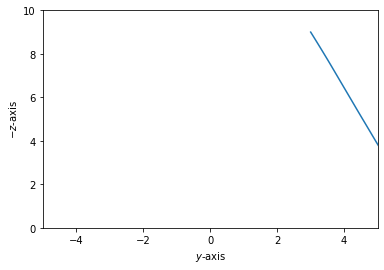

episode: 1/1000, score: -2512.068008263629  Average over last 100 episode: -2398.58 



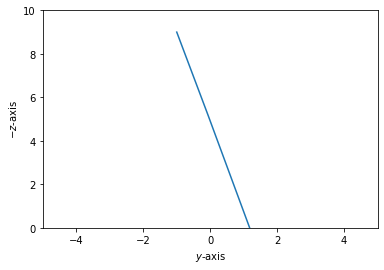

episode: 2/1000, score: -1866.4921953319913  Average over last 100 episode: -2221.22 



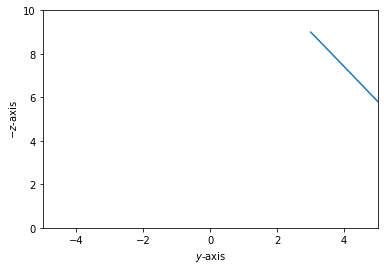

episode: 3/1000, score: -2405.3543436504165  Average over last 100 episode: -2267.25 



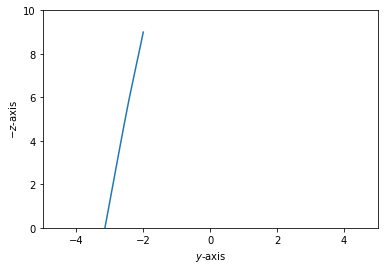

episode: 4/1000, score: -2998.352738683105  Average over last 100 episode: -2413.47 



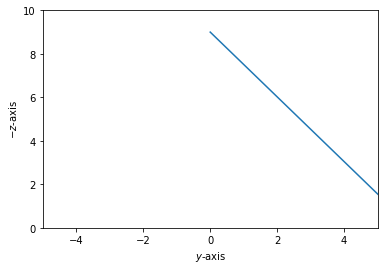

episode: 5/1000, score: -3019.6523719748902  Average over last 100 episode: -2514.50 



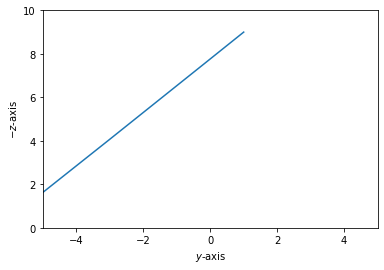

episode: 6/1000, score: -1624.3342775702233  Average over last 100 episode: -2387.34 



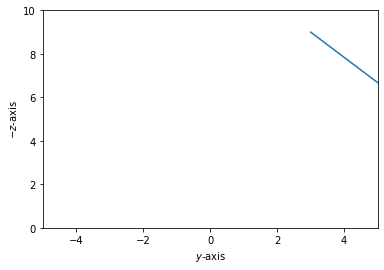

episode: 7/1000, score: -2001.313277290227  Average over last 100 episode: -2339.08 



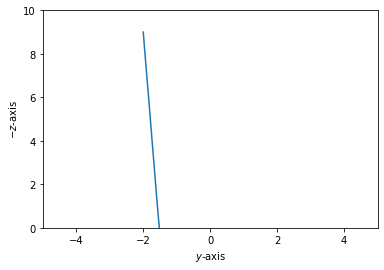

episode: 8/1000, score: -2170.1779714735194  Average over last 100 episode: -2320.32 



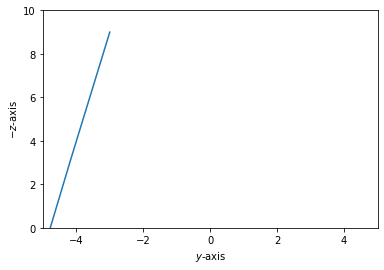

episode: 9/1000, score: -1626.490757627258  Average over last 100 episode: -2250.93 



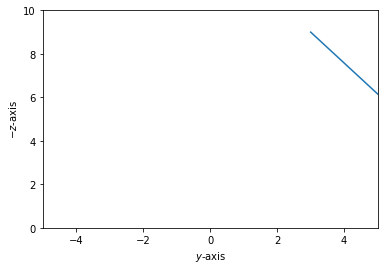

episode: 10/1000, score: -2846.572117434891  Average over last 100 episode: -2305.08 



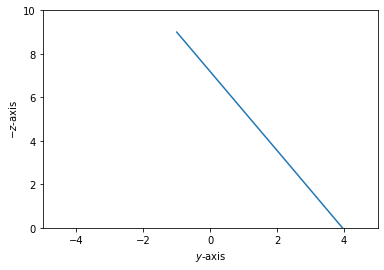

episode: 11/1000, score: -3043.835801010284  Average over last 100 episode: -2366.65 



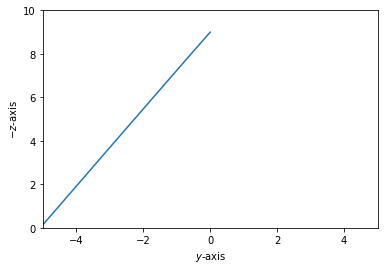

episode: 12/1000, score: -2607.85293818056  Average over last 100 episode: -2385.20 



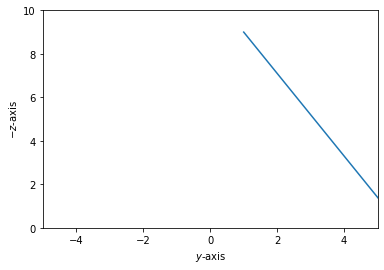

episode: 13/1000, score: -1980.1840340925671  Average over last 100 episode: -2356.27 



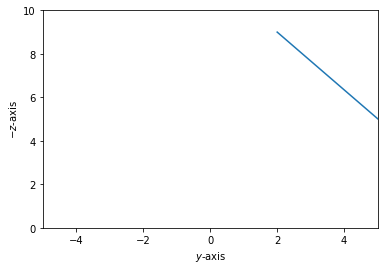

episode: 14/1000, score: -2710.843662949627  Average over last 100 episode: -2379.91 



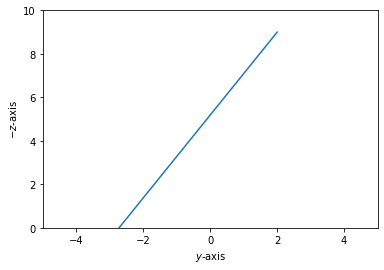

episode: 15/1000, score: -2592.452661672721  Average over last 100 episode: -2393.19 



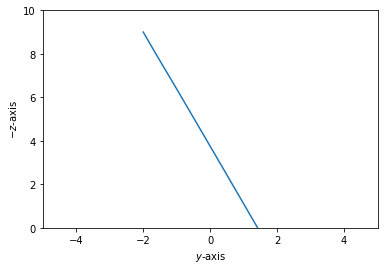

episode: 16/1000, score: -2213.5253286689244  Average over last 100 episode: -2382.62 



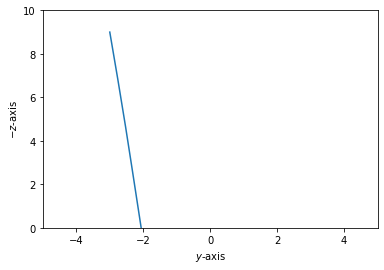

episode: 17/1000, score: -2464.2983910669145  Average over last 100 episode: -2387.16 



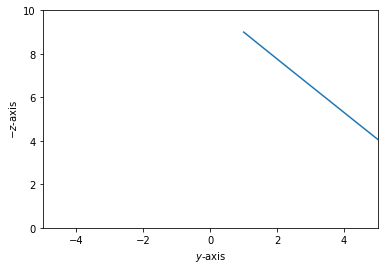

episode: 18/1000, score: -1973.5388103968885  Average over last 100 episode: -2365.39 



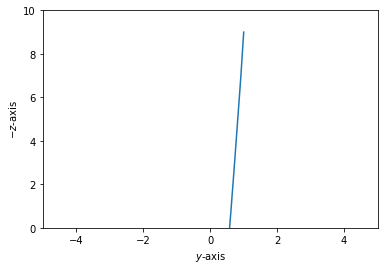

episode: 19/1000, score: -2443.874875257737  Average over last 100 episode: -2369.32 



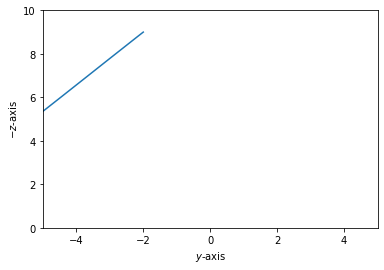

episode: 20/1000, score: -3011.828244131909  Average over last 100 episode: -2399.91 



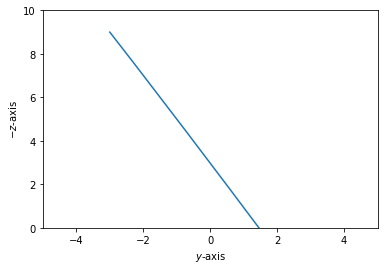

episode: 21/1000, score: -3192.127653446252  Average over last 100 episode: -2435.92 



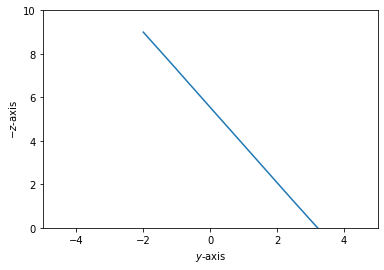

episode: 22/1000, score: -2461.6448221057426  Average over last 100 episode: -2437.04 



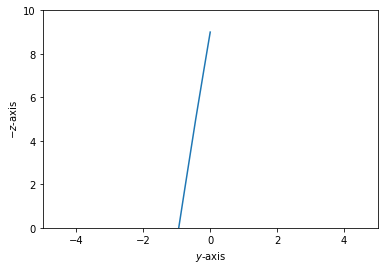

episode: 23/1000, score: -2013.6506563654925  Average over last 100 episode: -2419.40 



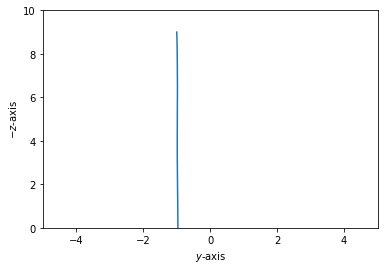

episode: 24/1000, score: -2096.463985142905  Average over last 100 episode: -2406.48 



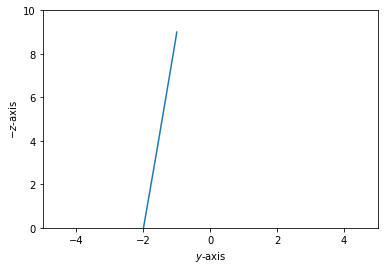

episode: 25/1000, score: -3198.7913081151796  Average over last 100 episode: -2436.95 



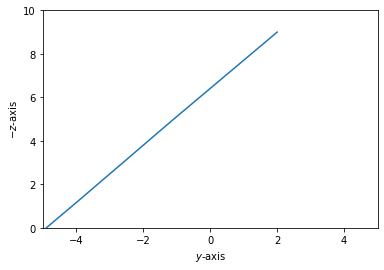

episode: 26/1000, score: -2115.4120964657777  Average over last 100 episode: -2425.05 



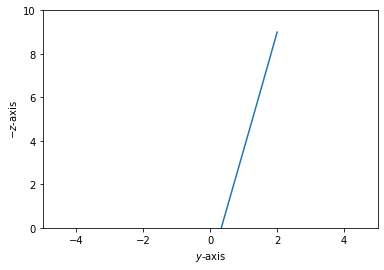

episode: 27/1000, score: -2127.581388982278  Average over last 100 episode: -2414.42 



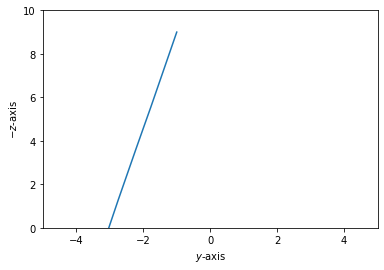

episode: 28/1000, score: -3767.173791078206  Average over last 100 episode: -2461.07 



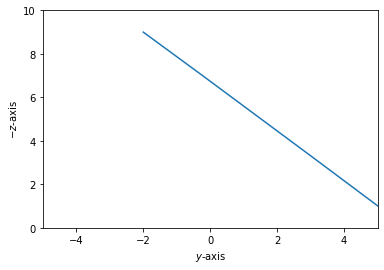

episode: 29/1000, score: -2581.646336790105  Average over last 100 episode: -2465.09 



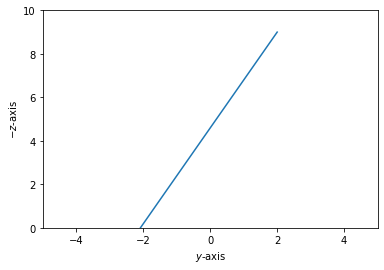

episode: 30/1000, score: -2490.8164532134388  Average over last 100 episode: -2465.92 



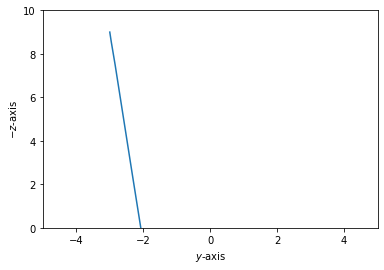

episode: 31/1000, score: -2461.0064792541375  Average over last 100 episode: -2465.76 



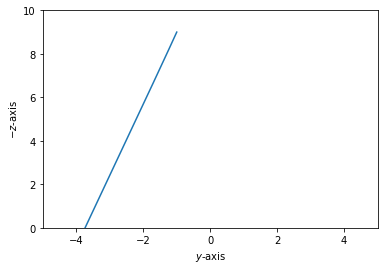

episode: 32/1000, score: -3305.8880219517655  Average over last 100 episode: -2491.22 



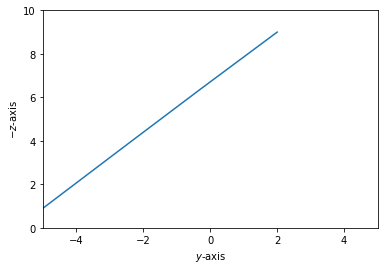

episode: 33/1000, score: -3023.0252229275534  Average over last 100 episode: -2506.86 



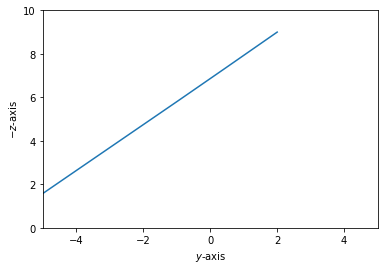

episode: 34/1000, score: -2551.8611904296085  Average over last 100 episode: -2508.15 



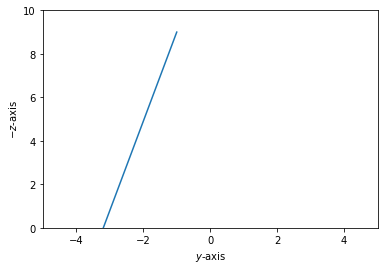

episode: 35/1000, score: -2032.518490719228  Average over last 100 episode: -2494.94 



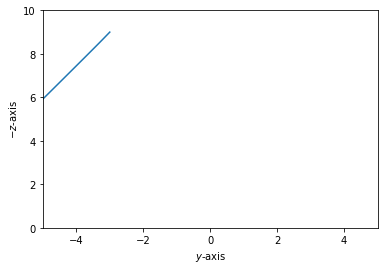

episode: 36/1000, score: -2467.2699341712823  Average over last 100 episode: -2494.19 



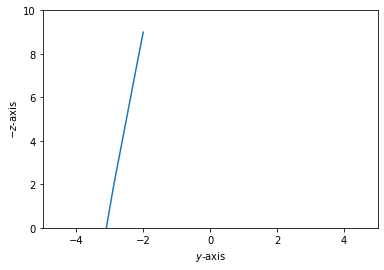

episode: 37/1000, score: -2271.6270794943835  Average over last 100 episode: -2488.33 



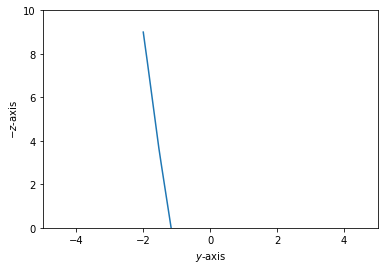

episode: 38/1000, score: -2417.3530925433442  Average over last 100 episode: -2486.51 



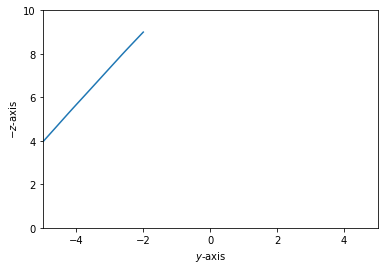

episode: 39/1000, score: -2377.1782850347836  Average over last 100 episode: -2483.78 



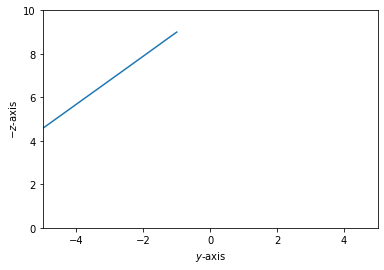

episode: 40/1000, score: -2105.82925067766  Average over last 100 episode: -2474.56 



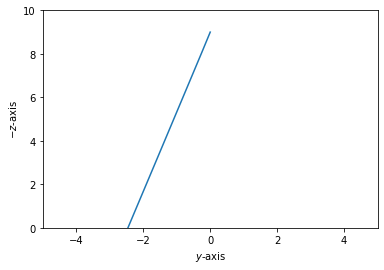

episode: 41/1000, score: -1748.3022849926742  Average over last 100 episode: -2457.27 



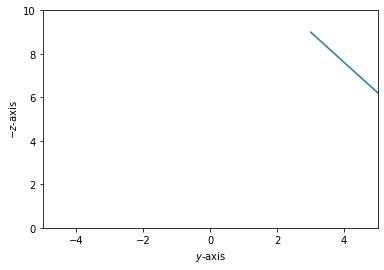

episode: 42/1000, score: -3047.0499017387606  Average over last 100 episode: -2470.99 



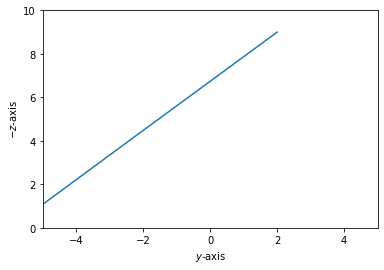

episode: 43/1000, score: -2143.18613215583  Average over last 100 episode: -2463.54 



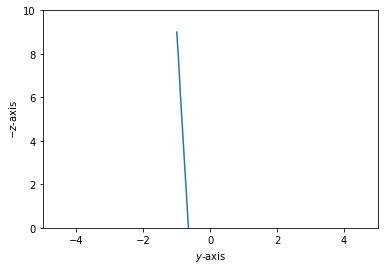

episode: 44/1000, score: -2161.459879007845  Average over last 100 episode: -2456.82 



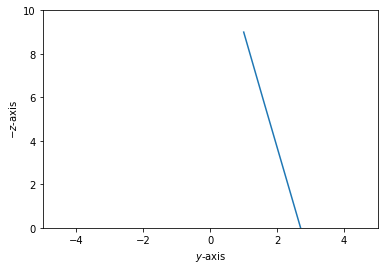

episode: 45/1000, score: -2142.4011940940886  Average over last 100 episode: -2449.99 



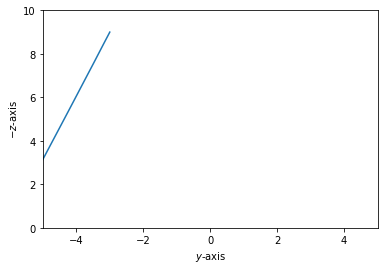

episode: 46/1000, score: -1751.687214341212  Average over last 100 episode: -2435.13 



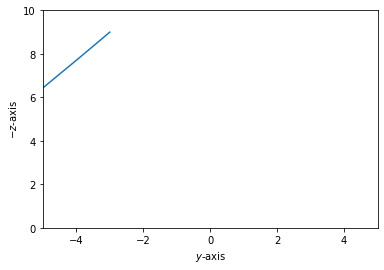

episode: 47/1000, score: -2821.104716230371  Average over last 100 episode: -2443.17 



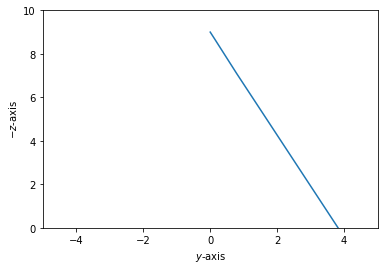

episode: 48/1000, score: -1680.8674211698615  Average over last 100 episode: -2427.61 



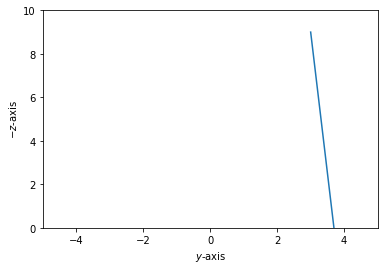

episode: 49/1000, score: -2455.277905482851  Average over last 100 episode: -2428.17 



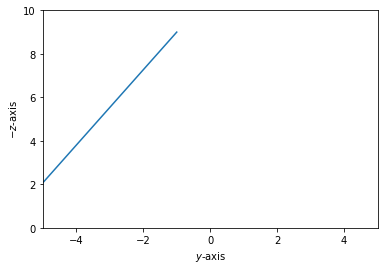

episode: 50/1000, score: -2092.402029384812  Average over last 100 episode: -2421.58 



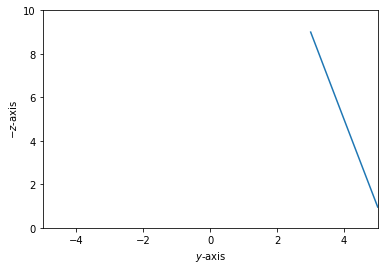

episode: 51/1000, score: -2524.7912034633805  Average over last 100 episode: -2423.57 



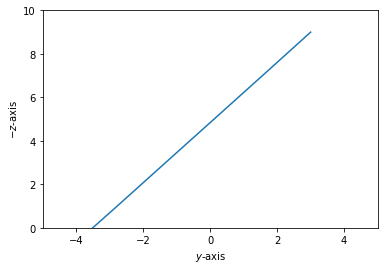

episode: 52/1000, score: -2169.7723092668693  Average over last 100 episode: -2418.78 



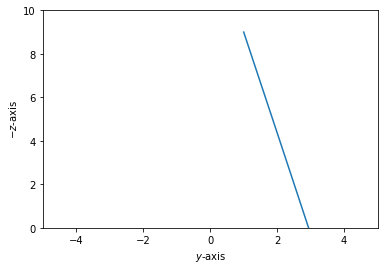

episode: 53/1000, score: -2812.950736666548  Average over last 100 episode: -2426.08 



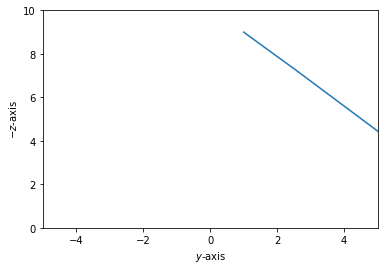

episode: 54/1000, score: -2344.2408305130093  Average over last 100 episode: -2424.59 



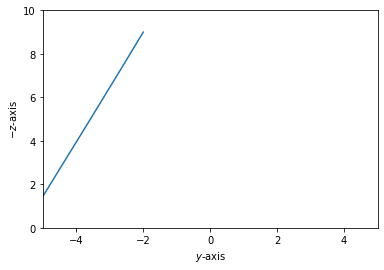

episode: 55/1000, score: -1579.6028160818373  Average over last 100 episode: -2409.50 



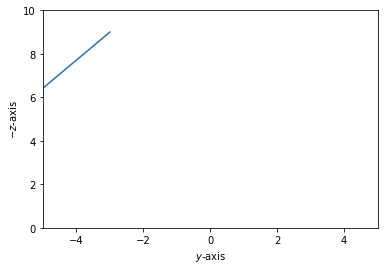

episode: 56/1000, score: -2641.1402335949533  Average over last 100 episode: -2413.57 



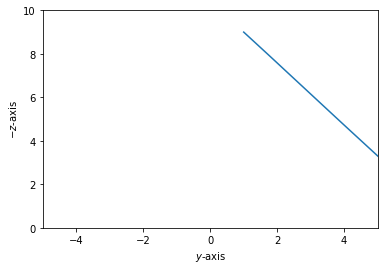

episode: 57/1000, score: -2335.7942973986774  Average over last 100 episode: -2412.22 



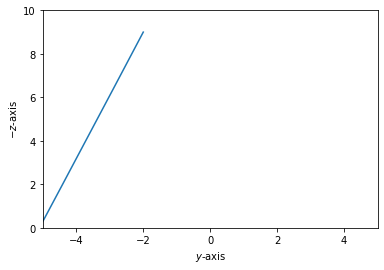

episode: 58/1000, score: -2009.9557085135277  Average over last 100 episode: -2405.41 



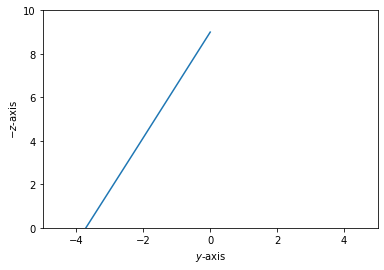

episode: 59/1000, score: -2746.894069977327  Average over last 100 episode: -2411.10 



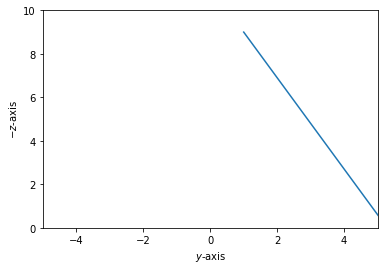

episode: 60/1000, score: -2444.477985821931  Average over last 100 episode: -2411.65 



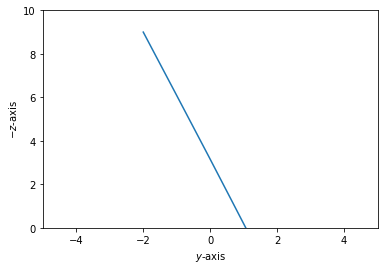

episode: 61/1000, score: -2100.9629879185754  Average over last 100 episode: -2406.63 



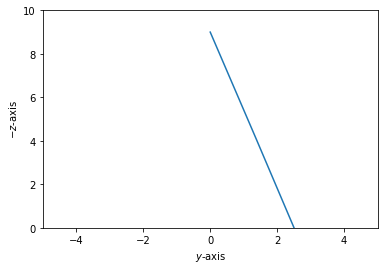

episode: 62/1000, score: -2736.0688382769076  Average over last 100 episode: -2411.86 



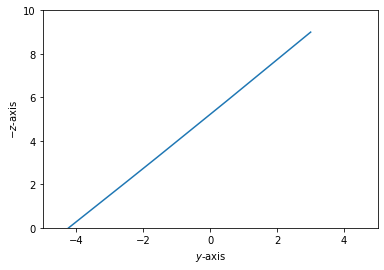

episode: 63/1000, score: -2015.9151381042004  Average over last 100 episode: -2405.68 



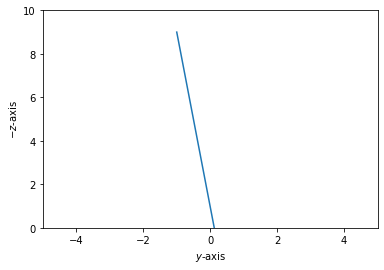

episode: 64/1000, score: -1634.2366300135052  Average over last 100 episode: -2393.81 



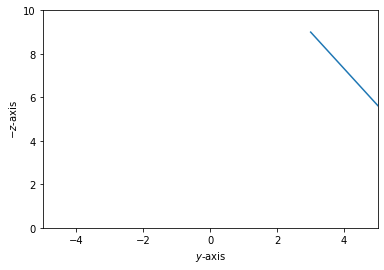

episode: 65/1000, score: -1855.5663871603526  Average over last 100 episode: -2385.65 



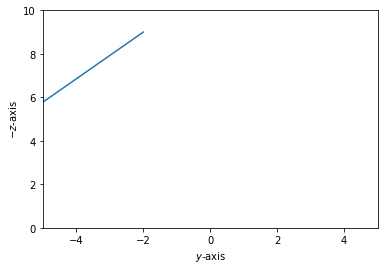

episode: 66/1000, score: -1535.201753801294  Average over last 100 episode: -2372.96 



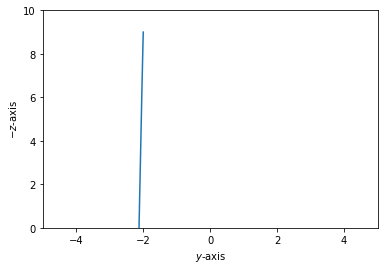

episode: 67/1000, score: -2095.438578480618  Average over last 100 episode: -2368.88 



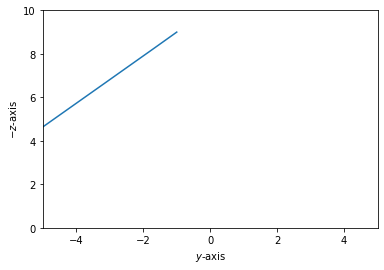

episode: 68/1000, score: -1777.8121351573175  Average over last 100 episode: -2360.31 



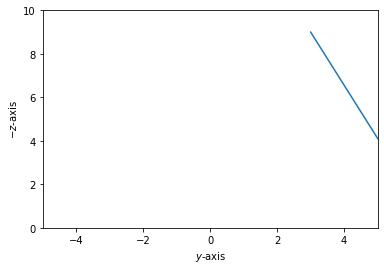

episode: 69/1000, score: -3581.8370341745904  Average over last 100 episode: -2377.76 



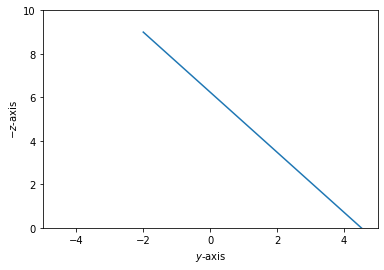

episode: 70/1000, score: -1629.8763221579463  Average over last 100 episode: -2367.23 



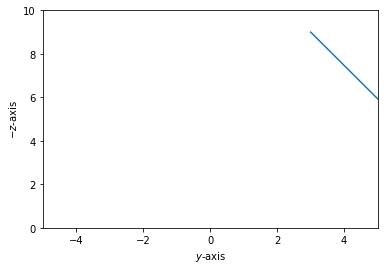

episode: 71/1000, score: -1596.794866389629  Average over last 100 episode: -2356.53 



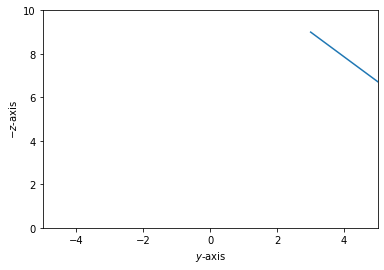

episode: 72/1000, score: -1988.3016488968967  Average over last 100 episode: -2351.48 



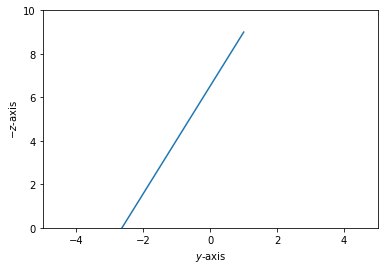

episode: 73/1000, score: -1809.4486017495083  Average over last 100 episode: -2344.16 



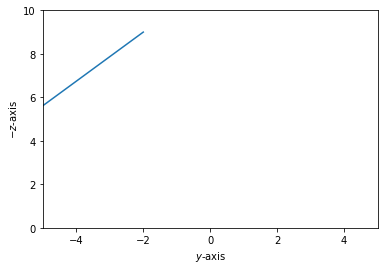

episode: 74/1000, score: -3749.959280970714  Average over last 100 episode: -2362.90 



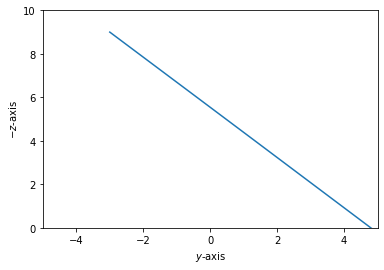

episode: 75/1000, score: -1967.0073604078686  Average over last 100 episode: -2357.69 



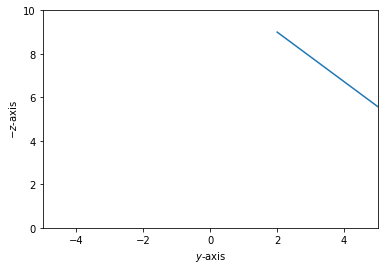

episode: 76/1000, score: -3009.08990858336  Average over last 100 episode: -2366.15 



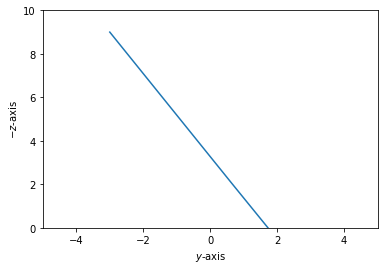

episode: 77/1000, score: -1847.0126602747926  Average over last 100 episode: -2359.50 



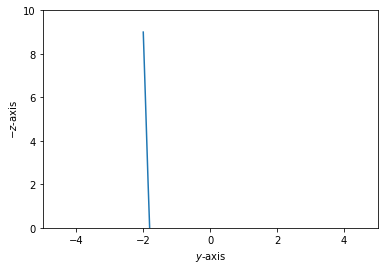

episode: 78/1000, score: -2751.143265898463  Average over last 100 episode: -2364.46 



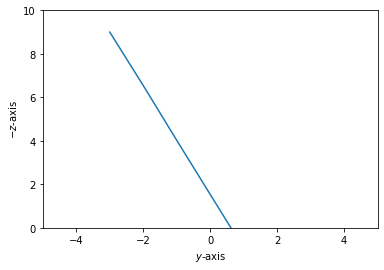

episode: 79/1000, score: -1638.0898752341159  Average over last 100 episode: -2355.38 



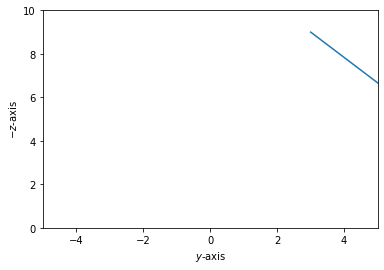

episode: 80/1000, score: -2267.074933303455  Average over last 100 episode: -2354.29 



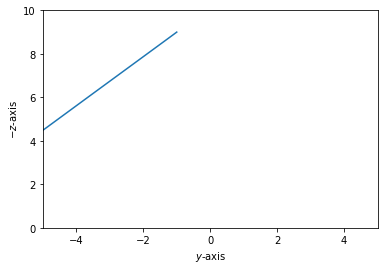

episode: 81/1000, score: -3169.0467028138564  Average over last 100 episode: -2364.22 



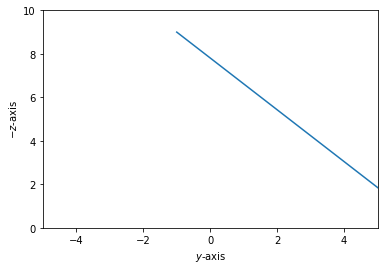

episode: 82/1000, score: -2479.9417998368035  Average over last 100 episode: -2365.62 



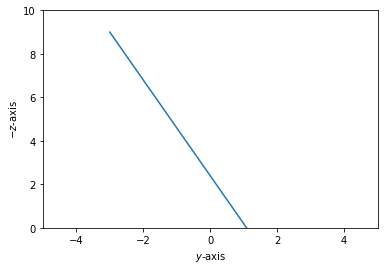

episode: 83/1000, score: -2644.5516506509857  Average over last 100 episode: -2368.94 



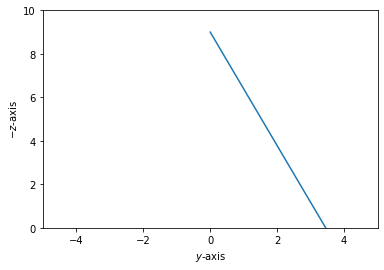

episode: 84/1000, score: -1949.8322457139775  Average over last 100 episode: -2364.01 



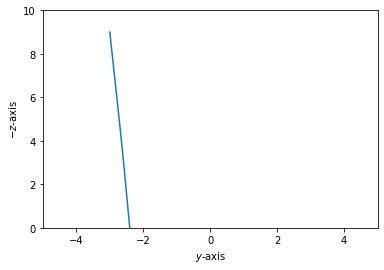

episode: 85/1000, score: -2043.1728309413913  Average over last 100 episode: -2360.28 



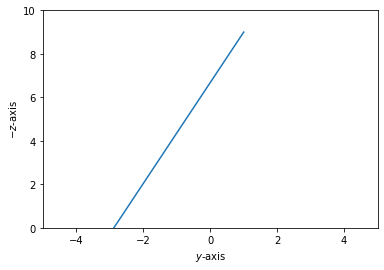

episode: 86/1000, score: -2142.061290961222  Average over last 100 episode: -2357.77 



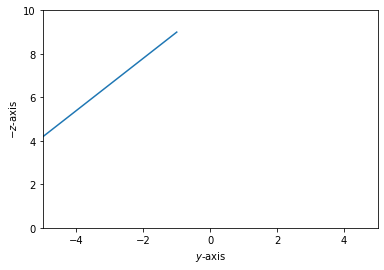

episode: 87/1000, score: -3954.7029844119224  Average over last 100 episode: -2375.91 



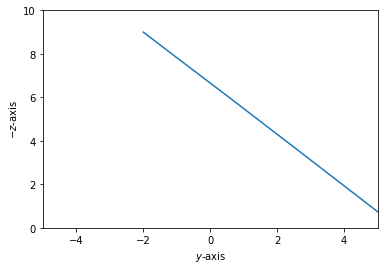

episode: 88/1000, score: -1983.7731479725505  Average over last 100 episode: -2371.51 



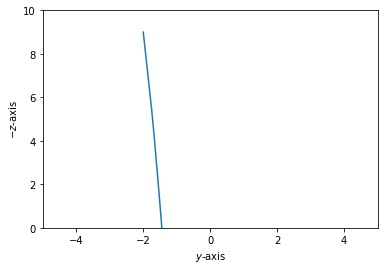

episode: 89/1000, score: -2893.115154399597  Average over last 100 episode: -2377.30 



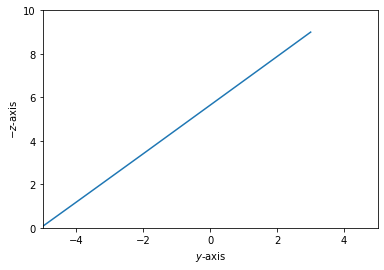

episode: 90/1000, score: -2629.3299337276203  Average over last 100 episode: -2380.07 



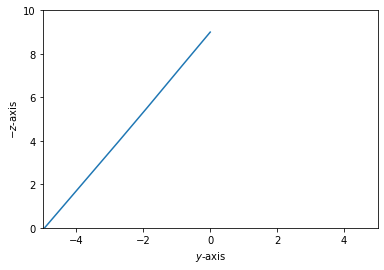

episode: 91/1000, score: -2170.752773928705  Average over last 100 episode: -2377.80 



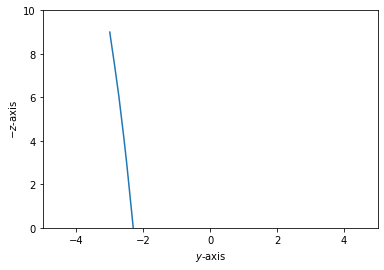

episode: 92/1000, score: -2372.795423417765  Average over last 100 episode: -2377.74 



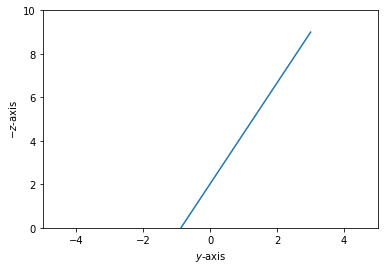

episode: 93/1000, score: -3772.800491089217  Average over last 100 episode: -2392.59 



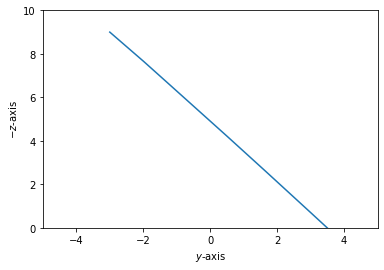

episode: 94/1000, score: -2222.3633363518297  Average over last 100 episode: -2390.79 



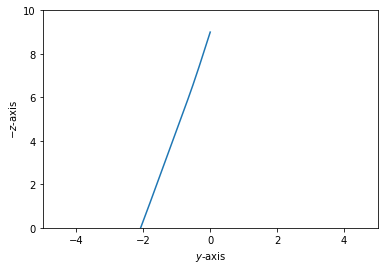

episode: 95/1000, score: -3050.950550596059  Average over last 100 episode: -2397.67 



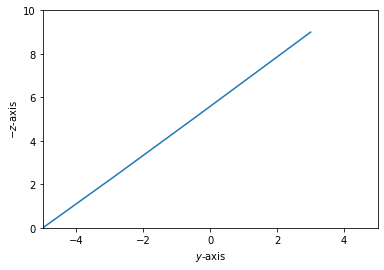

episode: 96/1000, score: -3275.065512668303  Average over last 100 episode: -2406.72 



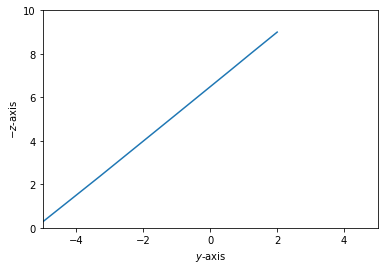

episode: 97/1000, score: -2502.691268716142  Average over last 100 episode: -2407.70 



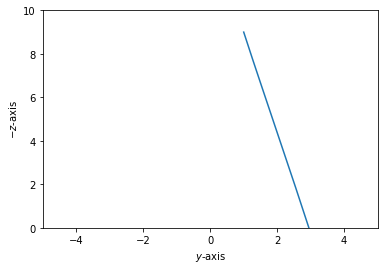

episode: 98/1000, score: -2682.6803949590167  Average over last 100 episode: -2410.47 



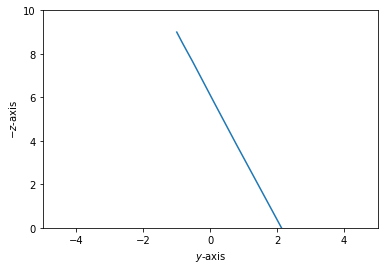

episode: 99/1000, score: -1683.8581428718278  Average over last 100 episode: -2403.21 



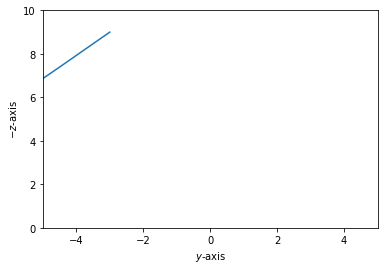

episode: 100/1000, score: -1819.4202672217527  Average over last 100 episode: -2398.55 



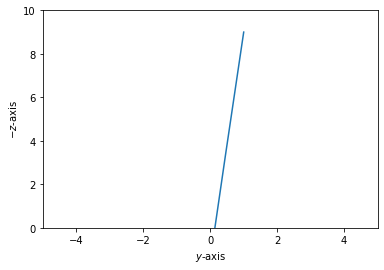

episode: 101/1000, score: -2682.483809567198  Average over last 100 episode: -2400.25 



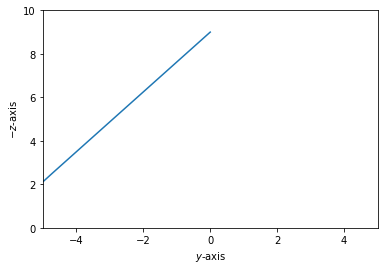

episode: 102/1000, score: -2195.8431339338367  Average over last 100 episode: -2403.55 



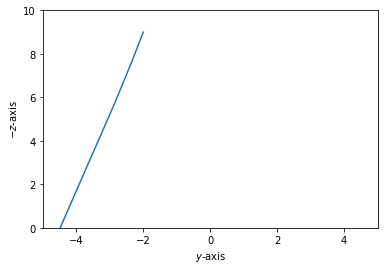

episode: 103/1000, score: -2831.4791431920867  Average over last 100 episode: -2407.81 



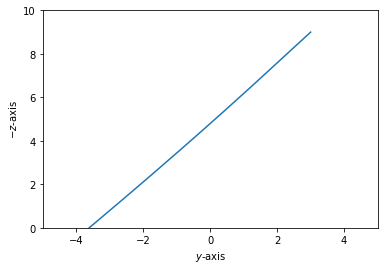

episode: 104/1000, score: -2356.6922595880264  Average over last 100 episode: -2401.39 



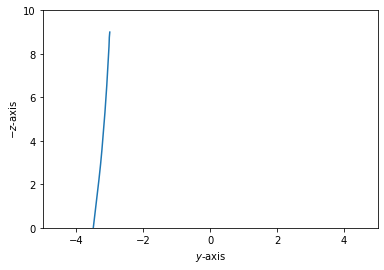

episode: 105/1000, score: -2047.0385048990793  Average over last 100 episode: -2391.67 



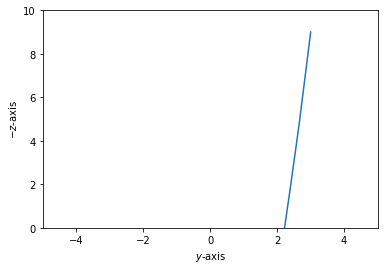

episode: 106/1000, score: -2273.67828134787  Average over last 100 episode: -2398.16 



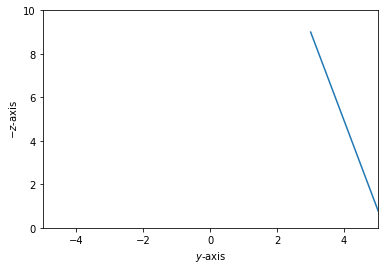

episode: 107/1000, score: -2805.1064784817318  Average over last 100 episode: -2406.20 



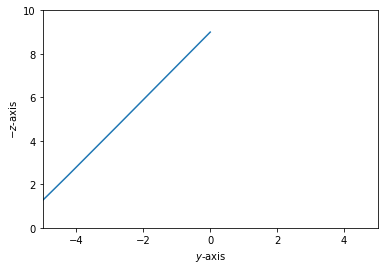

episode: 108/1000, score: -2886.1137816368814  Average over last 100 episode: -2413.36 



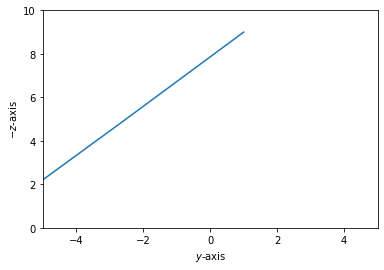

episode: 109/1000, score: -2961.6960598136675  Average over last 100 episode: -2426.71 



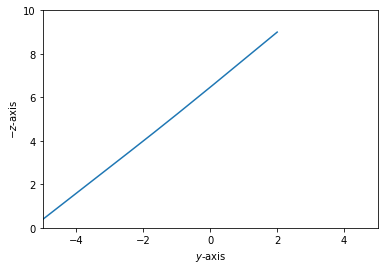

episode: 110/1000, score: -2921.88031463916  Average over last 100 episode: -2427.46 



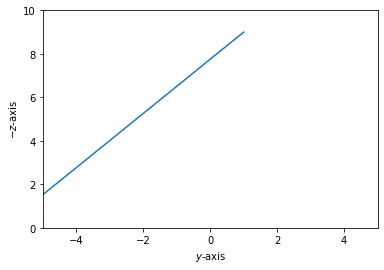

episode: 111/1000, score: -3300.930520364248  Average over last 100 episode: -2430.03 



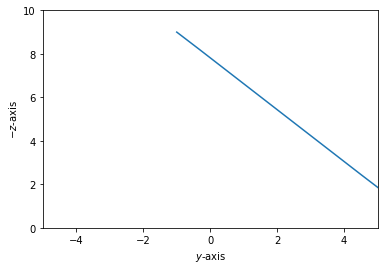

episode: 112/1000, score: -2213.489595261937  Average over last 100 episode: -2426.09 



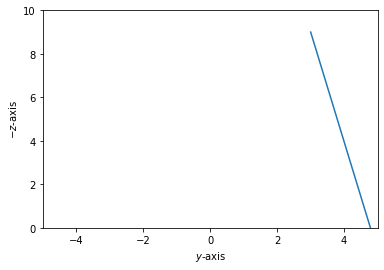

episode: 113/1000, score: -2088.718883487489  Average over last 100 episode: -2427.17 



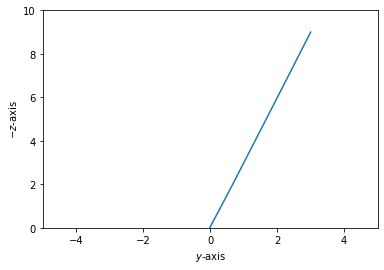

episode: 114/1000, score: -1672.2579459196204  Average over last 100 episode: -2416.79 



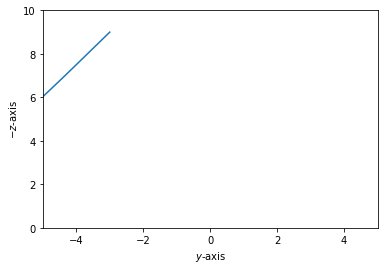

episode: 115/1000, score: -2377.70673940569  Average over last 100 episode: -2414.64 



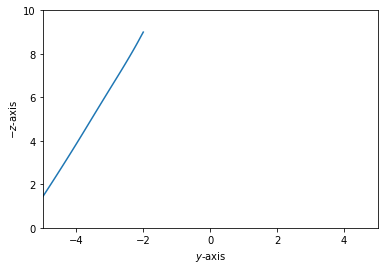

episode: 116/1000, score: -2400.463104134684  Average over last 100 episode: -2416.51 



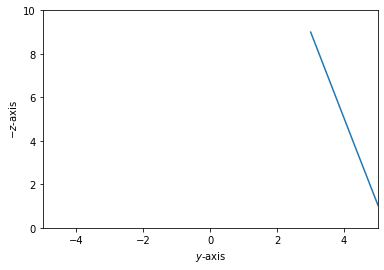

episode: 117/1000, score: -2705.4756215881084  Average over last 100 episode: -2418.92 



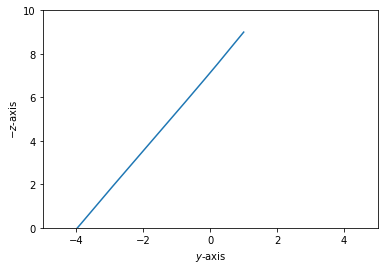

episode: 118/1000, score: -2308.3958769610413  Average over last 100 episode: -2422.27 



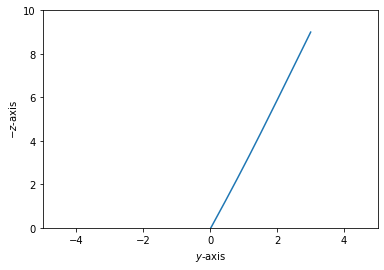

episode: 119/1000, score: -2313.5641438804914  Average over last 100 episode: -2420.97 



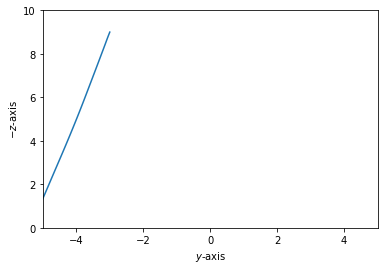

episode: 120/1000, score: -2942.947873646465  Average over last 100 episode: -2420.28 



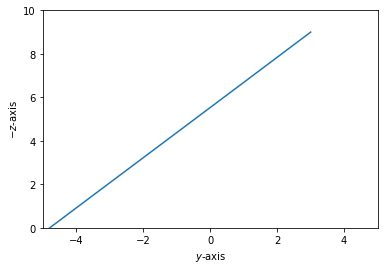

episode: 121/1000, score: -1885.2600950357505  Average over last 100 episode: -2407.21 



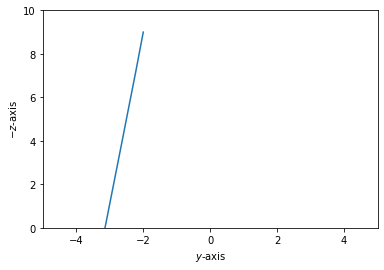

episode: 122/1000, score: -2507.366870429473  Average over last 100 episode: -2407.67 



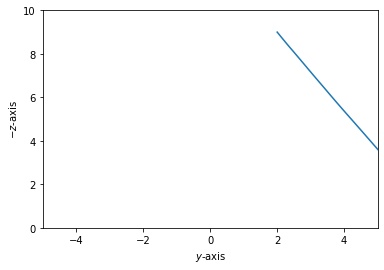

episode: 123/1000, score: -3002.435762422915  Average over last 100 episode: -2417.56 



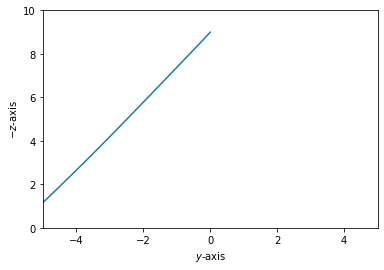

episode: 124/1000, score: -2236.558166443556  Average over last 100 episode: -2418.96 



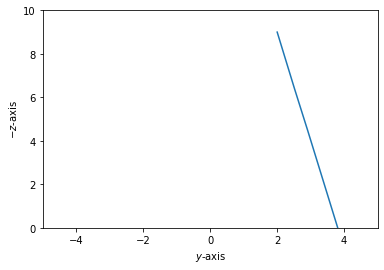

episode: 125/1000, score: -2171.215233650778  Average over last 100 episode: -2408.68 



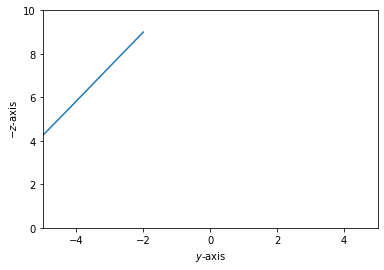

episode: 126/1000, score: -2091.5259338958294  Average over last 100 episode: -2408.44 



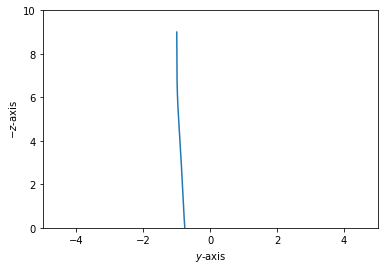

episode: 127/1000, score: -3428.9239447532264  Average over last 100 episode: -2421.46 



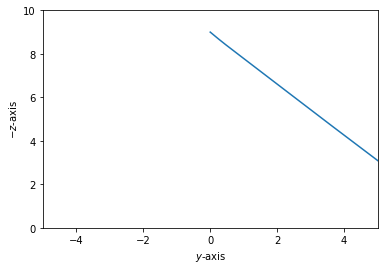

episode: 128/1000, score: -2563.5768864315833  Average over last 100 episode: -2409.42 



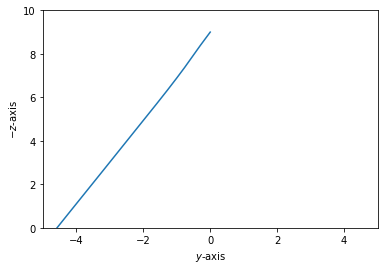

episode: 129/1000, score: -2002.8273411977223  Average over last 100 episode: -2403.63 



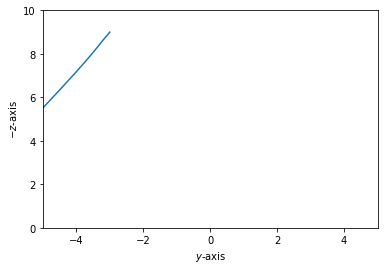

episode: 130/1000, score: -2974.04548881455  Average over last 100 episode: -2408.46 



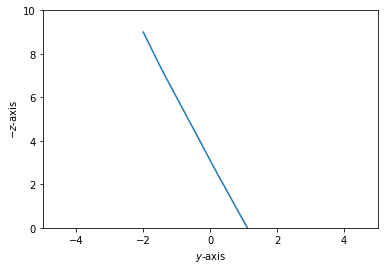

episode: 131/1000, score: -2709.2497558373734  Average over last 100 episode: -2410.95 



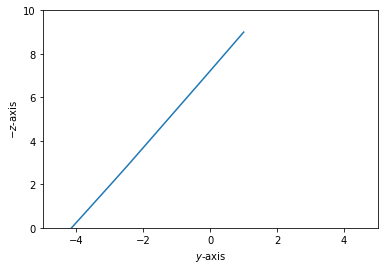

episode: 132/1000, score: -2805.0959173454635  Average over last 100 episode: -2405.94 



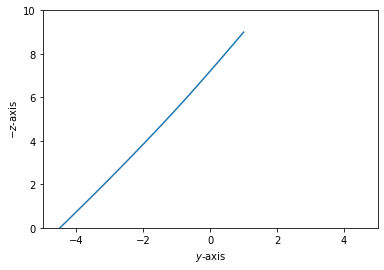

episode: 133/1000, score: -2820.3115231499087  Average over last 100 episode: -2403.91 



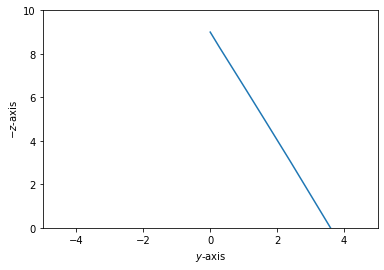

episode: 134/1000, score: -2818.3563362131686  Average over last 100 episode: -2406.58 



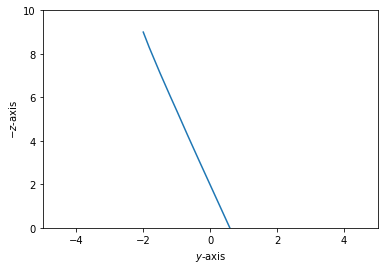

episode: 135/1000, score: -2590.60931125796  Average over last 100 episode: -2412.16 



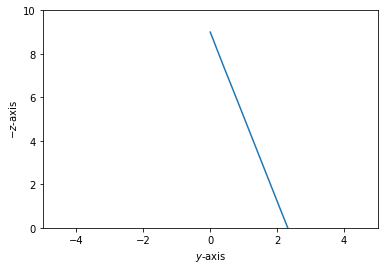

episode: 136/1000, score: -2812.773129423014  Average over last 100 episode: -2415.61 



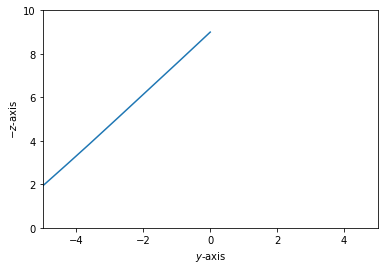

episode: 137/1000, score: -3284.838127625777  Average over last 100 episode: -2425.74 



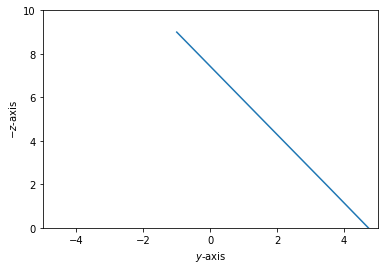

episode: 138/1000, score: -2632.8002513127294  Average over last 100 episode: -2427.90 



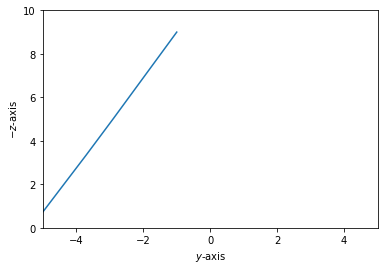

episode: 139/1000, score: -2778.0345458420597  Average over last 100 episode: -2431.91 



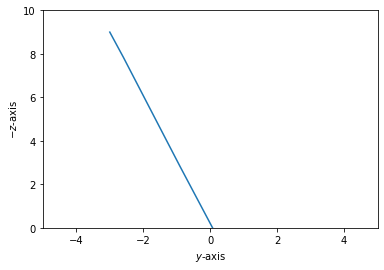

episode: 140/1000, score: -3297.295310169649  Average over last 100 episode: -2443.82 



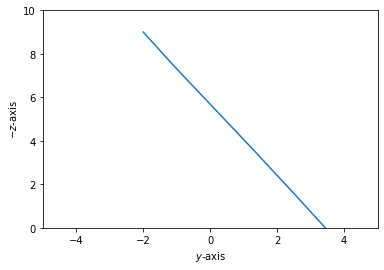

episode: 141/1000, score: -2877.4919572470094  Average over last 100 episode: -2455.11 



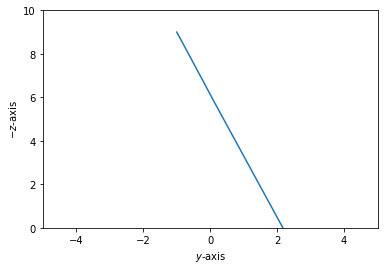

episode: 142/1000, score: -2217.3992877516125  Average over last 100 episode: -2446.82 



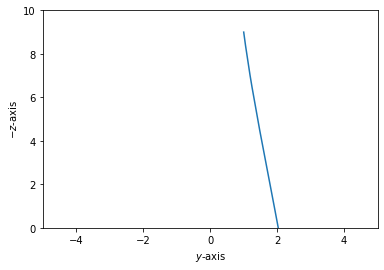

episode: 143/1000, score: -3203.28064751037  Average over last 100 episode: -2457.42 



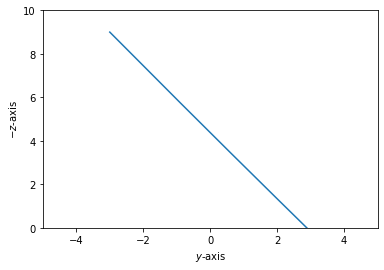

episode: 144/1000, score: -2435.6055545991558  Average over last 100 episode: -2460.16 



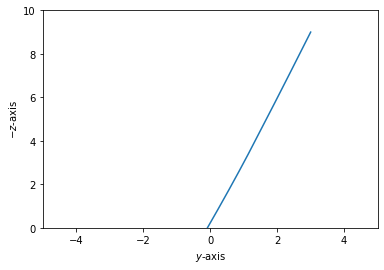

episode: 145/1000, score: -3759.781515430252  Average over last 100 episode: -2476.33 



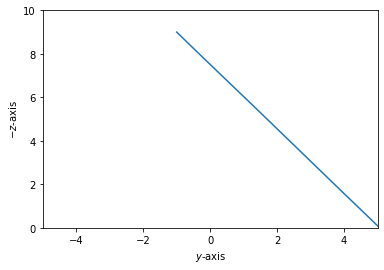

episode: 146/1000, score: -2773.0252300098737  Average over last 100 episode: -2486.55 



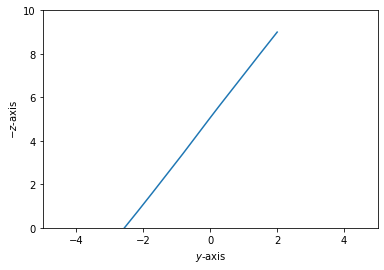

episode: 147/1000, score: -2147.844994263214  Average over last 100 episode: -2479.81 



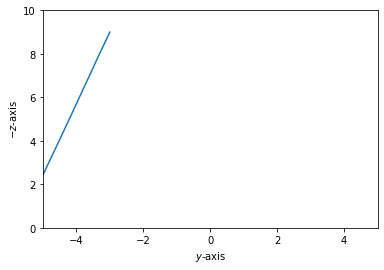

episode: 148/1000, score: -2807.65877847439  Average over last 100 episode: -2491.08 



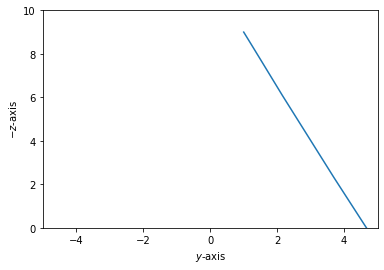

episode: 149/1000, score: -2682.224466753304  Average over last 100 episode: -2493.35 



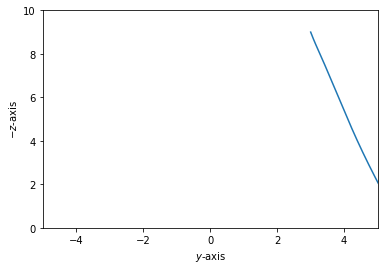

episode: 150/1000, score: -2302.73506664713  Average over last 100 episode: -2495.45 



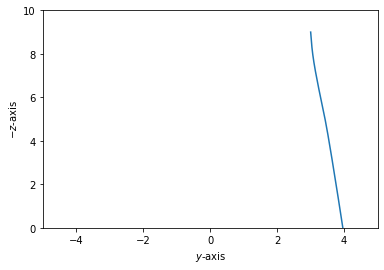

episode: 151/1000, score: -2039.0494108770877  Average over last 100 episode: -2490.60 



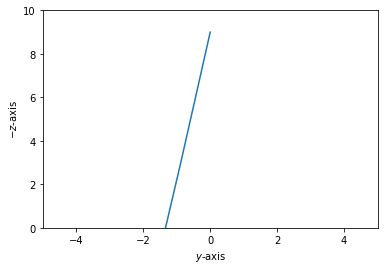

episode: 152/1000, score: -2294.38672212451  Average over last 100 episode: -2491.84 



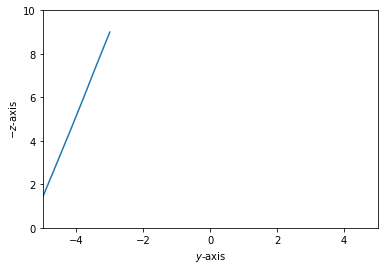

episode: 153/1000, score: -1858.1866259819337  Average over last 100 episode: -2482.30 



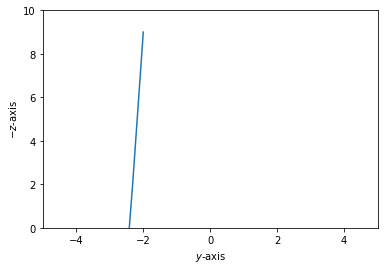

episode: 154/1000, score: -2599.586891189426  Average over last 100 episode: -2484.85 



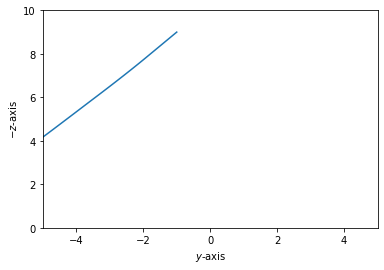

episode: 155/1000, score: -3044.9392179762344  Average over last 100 episode: -2499.50 



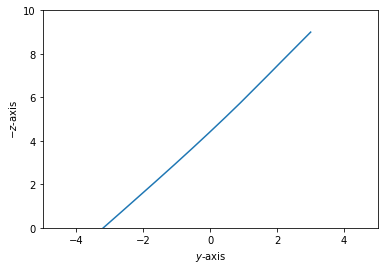

episode: 156/1000, score: -3299.963830921879  Average over last 100 episode: -2506.09 



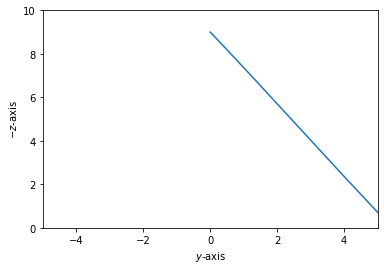

episode: 157/1000, score: -2789.7368157750097  Average over last 100 episode: -2510.63 



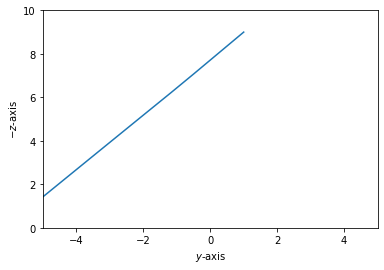

episode: 158/1000, score: -2092.1026584846654  Average over last 100 episode: -2511.45 



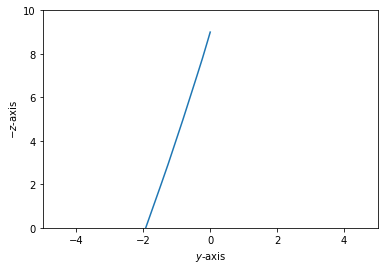

episode: 159/1000, score: -2286.868631346791  Average over last 100 episode: -2506.85 



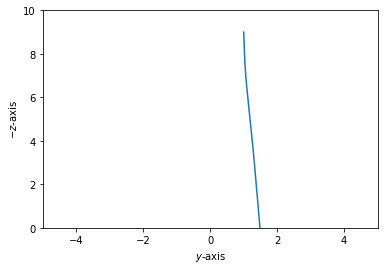

episode: 160/1000, score: -1999.689033600457  Average over last 100 episode: -2502.40 



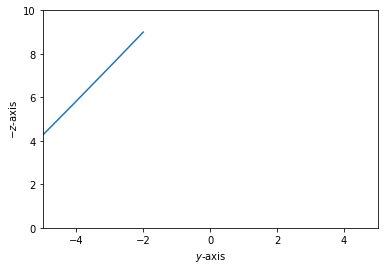

episode: 161/1000, score: -2274.1652030861987  Average over last 100 episode: -2504.14 



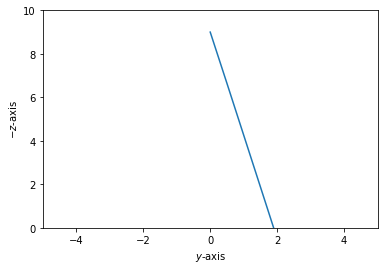

episode: 162/1000, score: -3038.6326512231904  Average over last 100 episode: -2507.16 



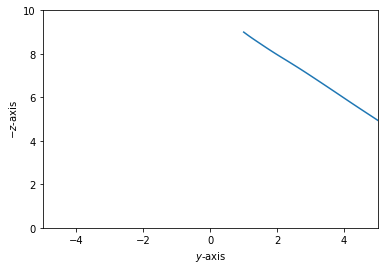

episode: 163/1000, score: -1837.6818453076035  Average over last 100 episode: -2505.38 



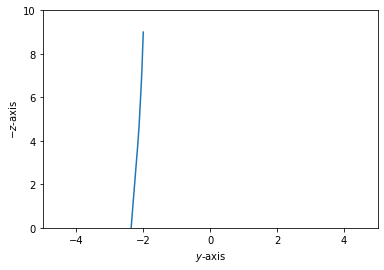

episode: 164/1000, score: -2021.826513498158  Average over last 100 episode: -2509.25 



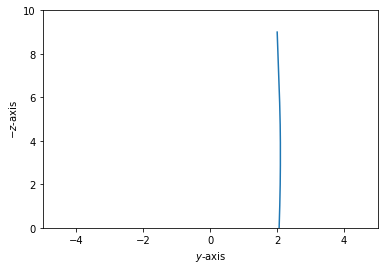

episode: 165/1000, score: -2069.6582504471057  Average over last 100 episode: -2511.40 



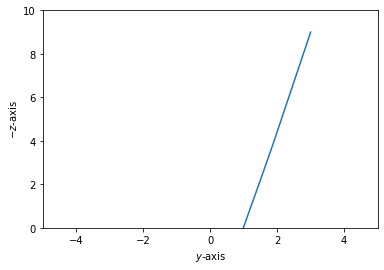

episode: 166/1000, score: -2441.3140658826765  Average over last 100 episode: -2520.46 



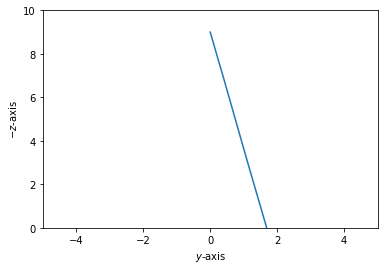

episode: 167/1000, score: -2677.175936929812  Average over last 100 episode: -2526.27 



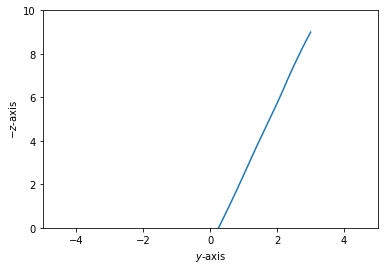

episode: 168/1000, score: -2076.3637807502378  Average over last 100 episode: -2529.26 



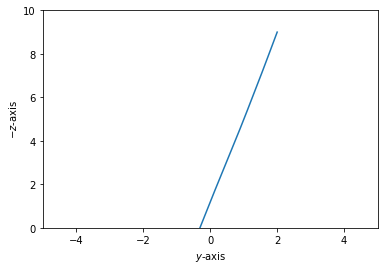

episode: 169/1000, score: -2656.4260884314413  Average over last 100 episode: -2520.01 



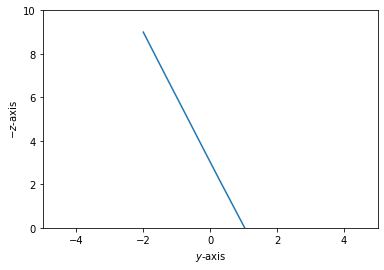

episode: 170/1000, score: -2332.1925838774105  Average over last 100 episode: -2527.03 



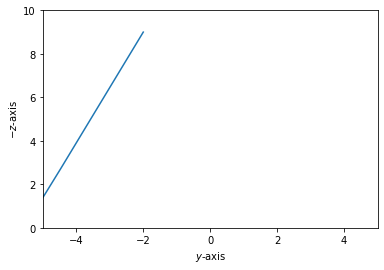

episode: 171/1000, score: -2772.8855651571366  Average over last 100 episode: -2538.79 



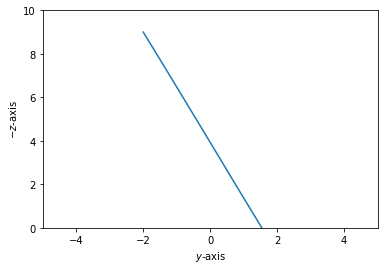

episode: 172/1000, score: -2246.246840636787  Average over last 100 episode: -2541.37 



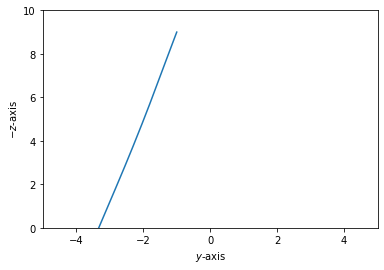

episode: 173/1000, score: -3472.5174105181845  Average over last 100 episode: -2558.00 



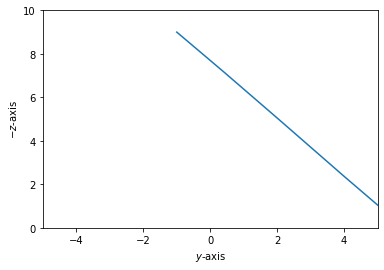

episode: 174/1000, score: -2888.953670894623  Average over last 100 episode: -2549.39 



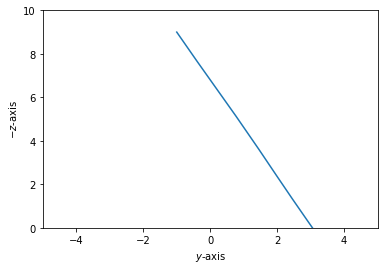

episode: 175/1000, score: -1864.6859714037828  Average over last 100 episode: -2548.37 



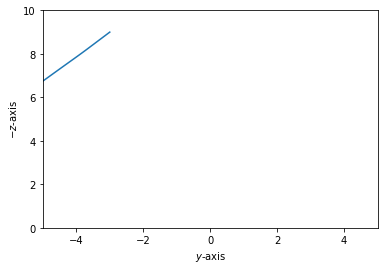

episode: 176/1000, score: -3027.171446275045  Average over last 100 episode: -2548.55 



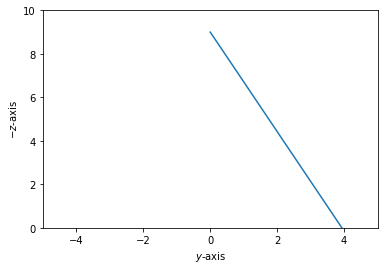

episode: 177/1000, score: -2615.5147802995316  Average over last 100 episode: -2556.23 



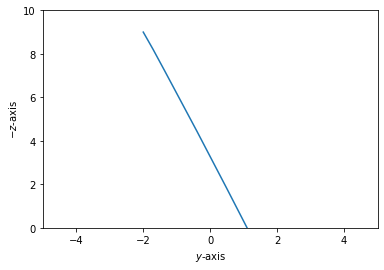

episode: 178/1000, score: -2926.0503718747564  Average over last 100 episode: -2557.98 



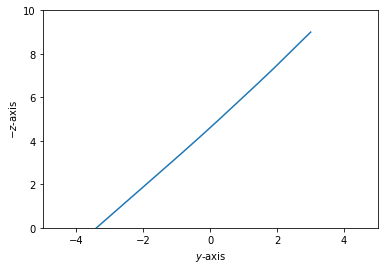

episode: 179/1000, score: -2135.6636222203974  Average over last 100 episode: -2562.96 



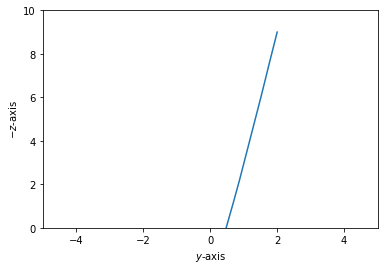

episode: 180/1000, score: -2105.0404622805227  Average over last 100 episode: -2561.34 



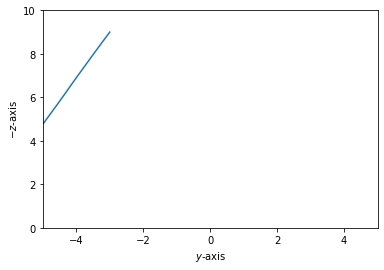

episode: 181/1000, score: -3189.81240869556  Average over last 100 episode: -2561.54 



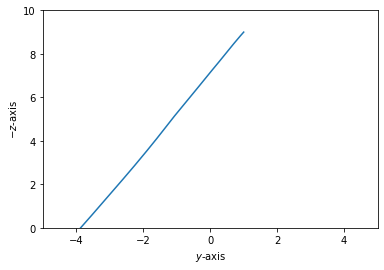

episode: 182/1000, score: -2126.475257948551  Average over last 100 episode: -2558.01 



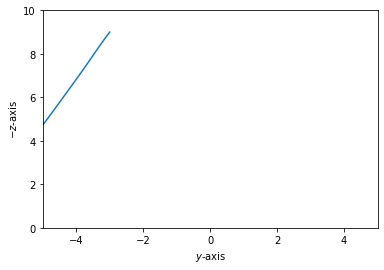

episode: 183/1000, score: -2351.4371220949706  Average over last 100 episode: -2555.08 



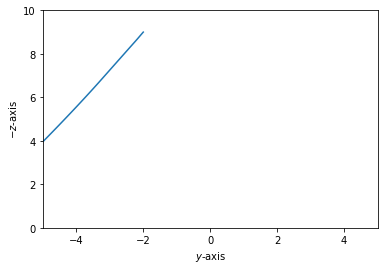

episode: 184/1000, score: -2748.5928628011634  Average over last 100 episode: -2563.07 



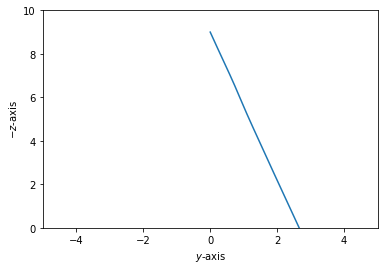

episode: 185/1000, score: -3109.9484074144457  Average over last 100 episode: -2573.73 



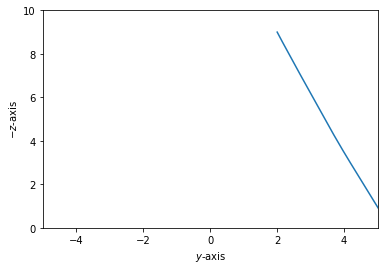

episode: 186/1000, score: -3301.1563999401997  Average over last 100 episode: -2585.33 



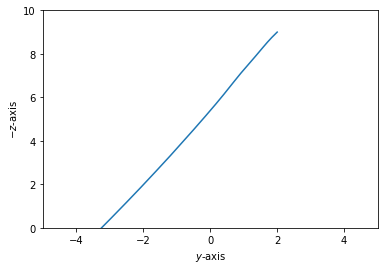

episode: 187/1000, score: -2350.4516820194012  Average over last 100 episode: -2569.28 



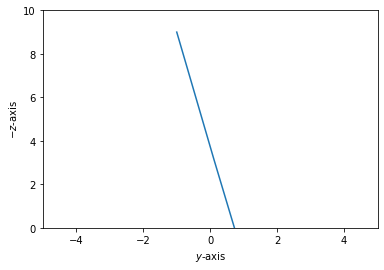

episode: 188/1000, score: -2383.5065038466305  Average over last 100 episode: -2573.28 



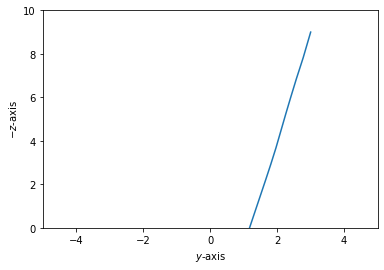

episode: 189/1000, score: -2917.774539845263  Average over last 100 episode: -2573.53 



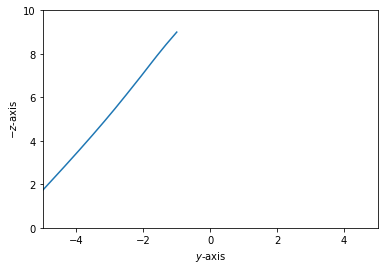

episode: 190/1000, score: -3685.0424576289524  Average over last 100 episode: -2584.08 



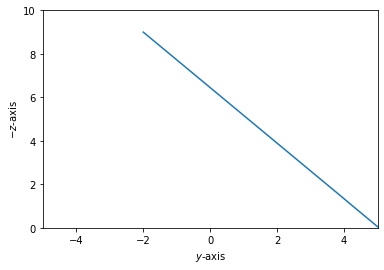

episode: 191/1000, score: -2836.7609269823847  Average over last 100 episode: -2590.74 



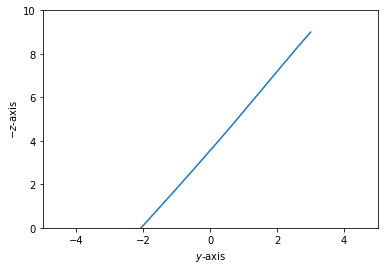

episode: 192/1000, score: -2669.3650209070674  Average over last 100 episode: -2593.71 



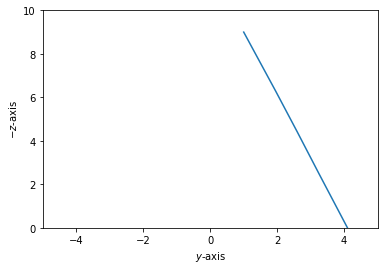

episode: 193/1000, score: -2865.3276775806225  Average over last 100 episode: -2584.63 



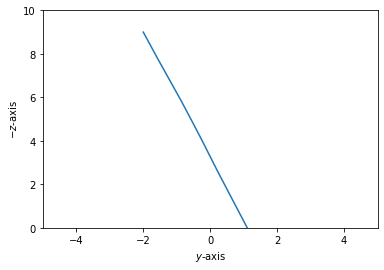

episode: 194/1000, score: -2494.093491544095  Average over last 100 episode: -2587.35 



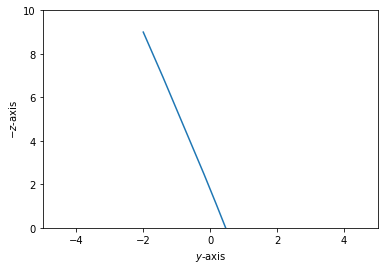

episode: 195/1000, score: -2025.5434271050228  Average over last 100 episode: -2577.10 



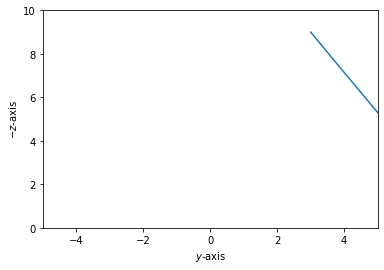

episode: 196/1000, score: -4000.6205170533985  Average over last 100 episode: -2584.35 



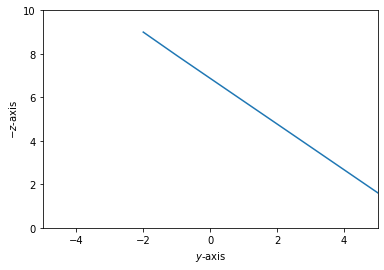

episode: 197/1000, score: -3912.084492453331  Average over last 100 episode: -2598.45 



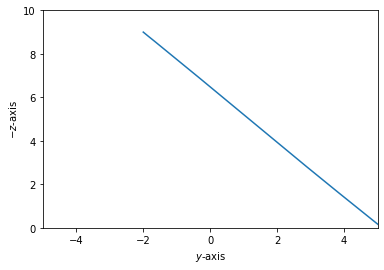

episode: 198/1000, score: -2061.9000894172195  Average over last 100 episode: -2592.24 



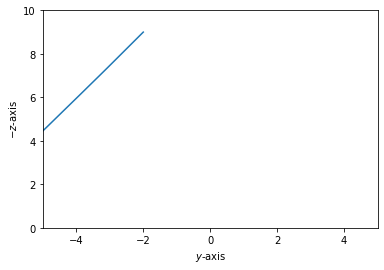

episode: 199/1000, score: -2171.188371063009  Average over last 100 episode: -2597.11 



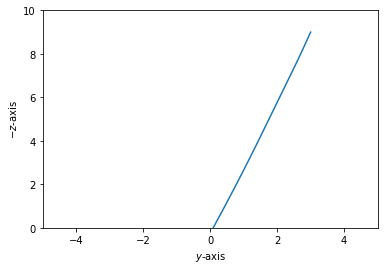

episode: 200/1000, score: -3172.898128075234  Average over last 100 episode: -2610.65 



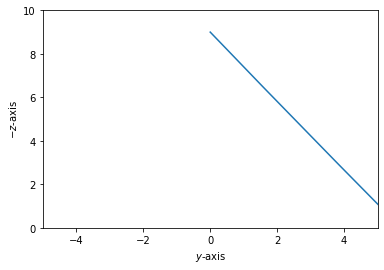

episode: 201/1000, score: -2196.6567752247984  Average over last 100 episode: -2605.79 



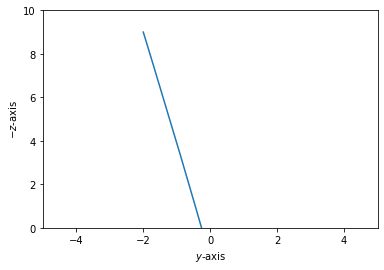

episode: 202/1000, score: -2100.4399296419438  Average over last 100 episode: -2604.84 



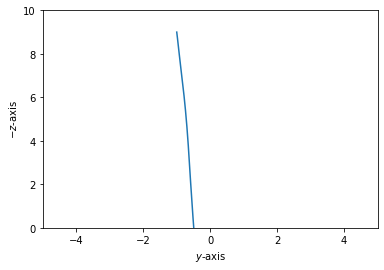

episode: 203/1000, score: -2092.055202422277  Average over last 100 episode: -2597.44 



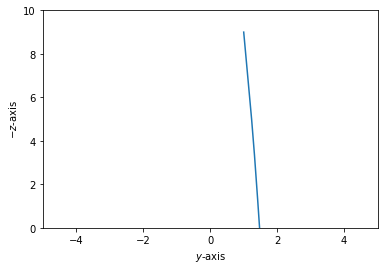

episode: 204/1000, score: -2449.984061777156  Average over last 100 episode: -2598.37 



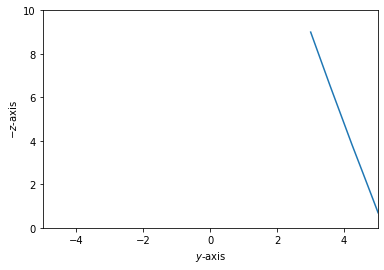

episode: 205/1000, score: -2609.5444617548847  Average over last 100 episode: -2604.00 



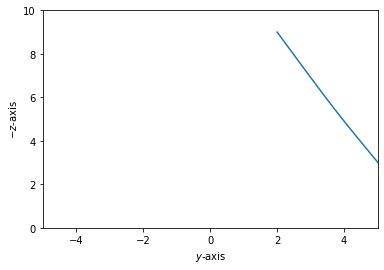

episode: 206/1000, score: -2108.13532916255  Average over last 100 episode: -2602.34 



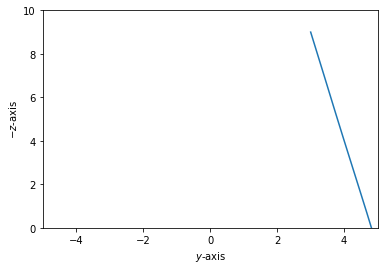

episode: 207/1000, score: -2702.560319400098  Average over last 100 episode: -2601.32 



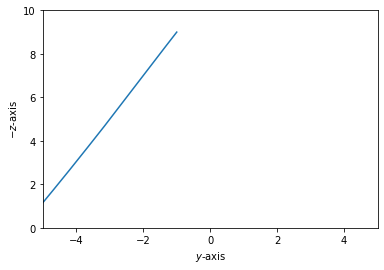

episode: 208/1000, score: -1978.6427145819655  Average over last 100 episode: -2592.24 



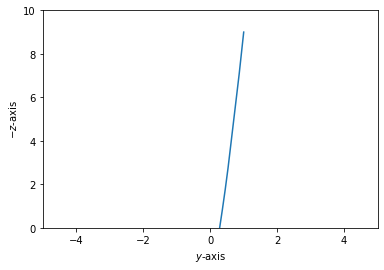

episode: 209/1000, score: -2094.2200117167413  Average over last 100 episode: -2583.57 



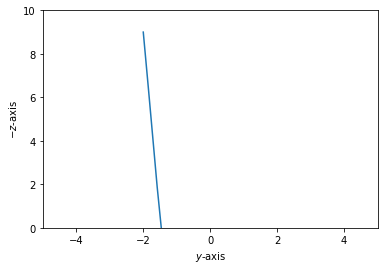

episode: 210/1000, score: -3230.93439238859  Average over last 100 episode: -2586.66 



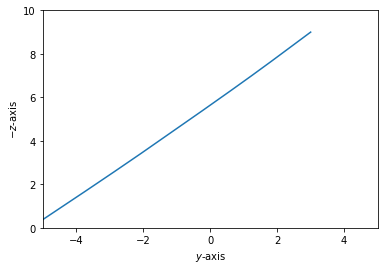

episode: 211/1000, score: -2250.7136470064606  Average over last 100 episode: -2576.16 



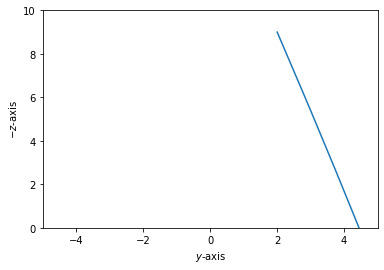

episode: 212/1000, score: -2555.3957280062095  Average over last 100 episode: -2579.58 



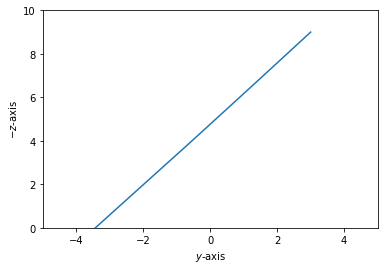

episode: 213/1000, score: -1974.4938682181353  Average over last 100 episode: -2578.43 



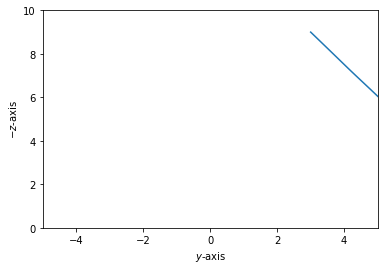

episode: 214/1000, score: -2302.557004863644  Average over last 100 episode: -2584.74 



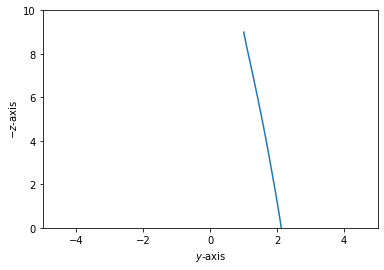

episode: 215/1000, score: -2056.9717060787  Average over last 100 episode: -2581.53 



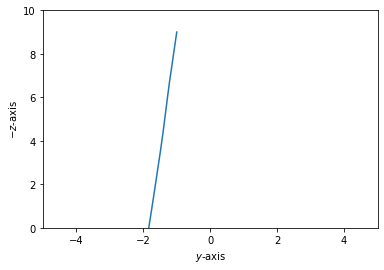

episode: 216/1000, score: -2593.6389623388  Average over last 100 episode: -2583.46 



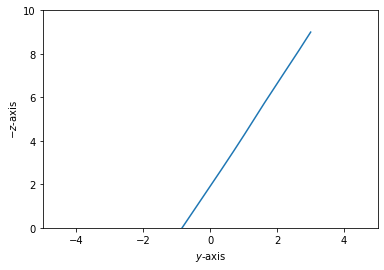

episode: 217/1000, score: -2680.5587482469386  Average over last 100 episode: -2583.21 



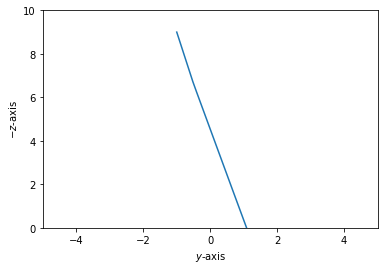

episode: 218/1000, score: -3003.629175726714  Average over last 100 episode: -2590.16 



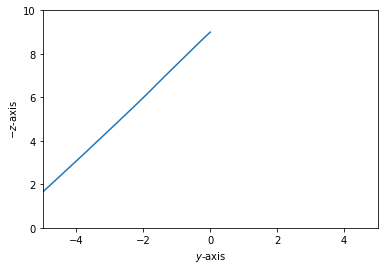

episode: 219/1000, score: -2237.088315480378  Average over last 100 episode: -2589.40 



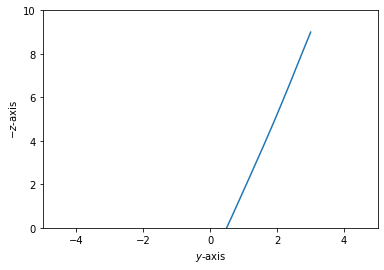

episode: 220/1000, score: -1890.2047816228317  Average over last 100 episode: -2578.87 



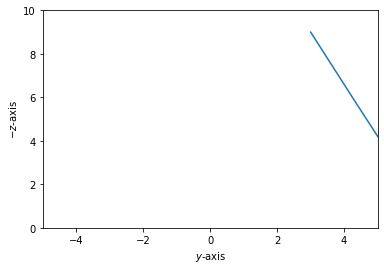

episode: 221/1000, score: -2466.5207982929064  Average over last 100 episode: -2584.68 



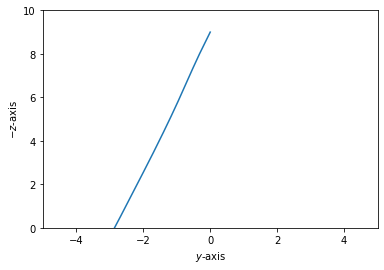

episode: 222/1000, score: -3497.310213309991  Average over last 100 episode: -2594.58 



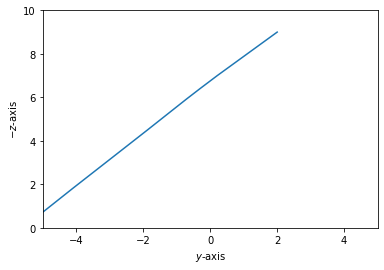

episode: 223/1000, score: -2779.2524348608677  Average over last 100 episode: -2592.35 



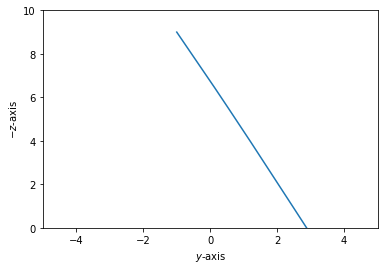

episode: 224/1000, score: -2595.907416283587  Average over last 100 episode: -2595.95 



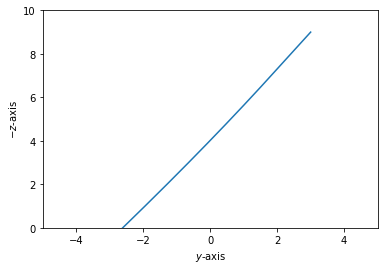

episode: 225/1000, score: -2408.976882472069  Average over last 100 episode: -2598.32 



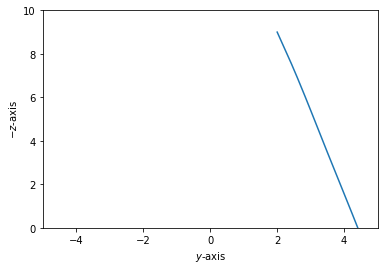

episode: 226/1000, score: -2056.021425059431  Average over last 100 episode: -2597.97 



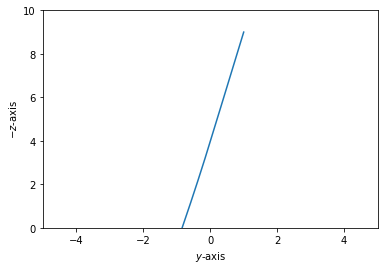

episode: 227/1000, score: -2851.9481030485886  Average over last 100 episode: -2592.20 



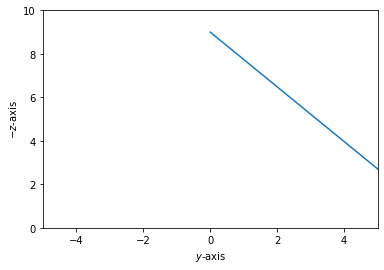

episode: 228/1000, score: -3048.768310443977  Average over last 100 episode: -2597.05 



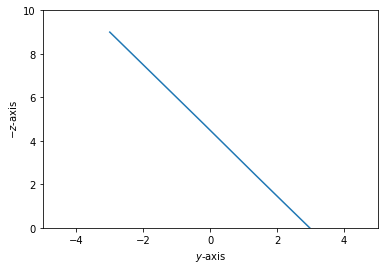

episode: 229/1000, score: -2393.3174255121517  Average over last 100 episode: -2600.96 



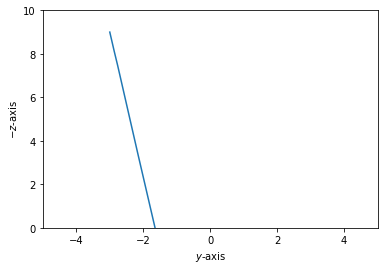

episode: 230/1000, score: -2480.017706053797  Average over last 100 episode: -2596.02 



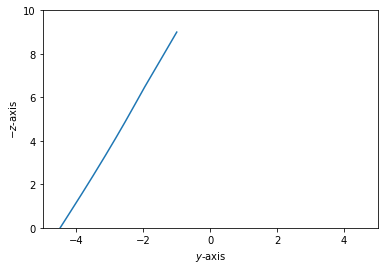

episode: 231/1000, score: -2133.763574754138  Average over last 100 episode: -2590.26 



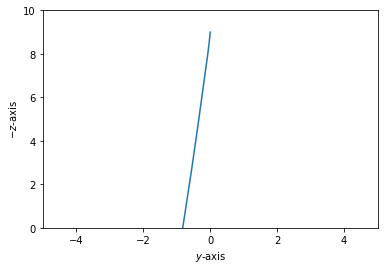

episode: 232/1000, score: -2913.4151612533433  Average over last 100 episode: -2591.34 



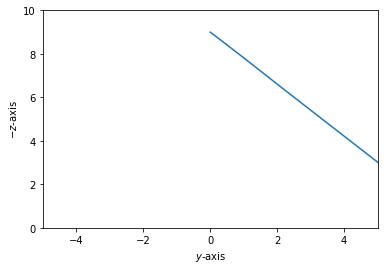

episode: 233/1000, score: -2684.792113910277  Average over last 100 episode: -2589.99 



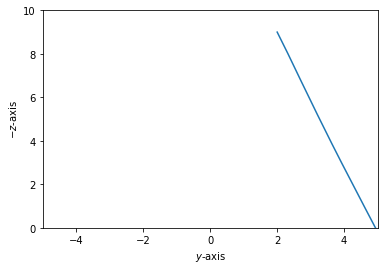

episode: 234/1000, score: -2771.7781273282462  Average over last 100 episode: -2589.52 



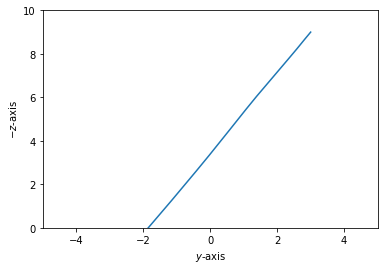

episode: 235/1000, score: -2969.0143512921204  Average over last 100 episode: -2593.31 



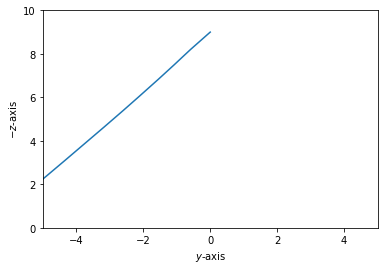

episode: 236/1000, score: -1779.292644622153  Average over last 100 episode: -2582.97 



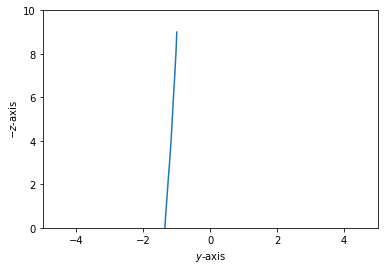

episode: 237/1000, score: -1806.8109983599575  Average over last 100 episode: -2568.19 



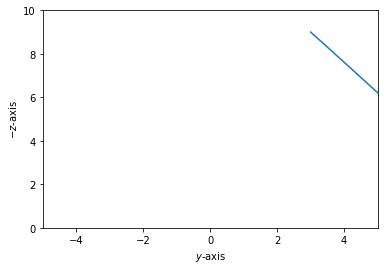

episode: 238/1000, score: -1988.0900397094745  Average over last 100 episode: -2561.74 



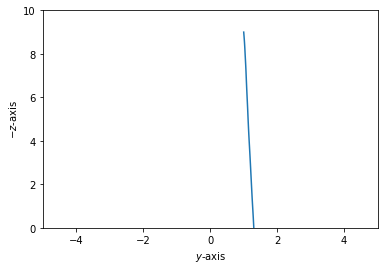

episode: 239/1000, score: -2913.682986539895  Average over last 100 episode: -2563.10 



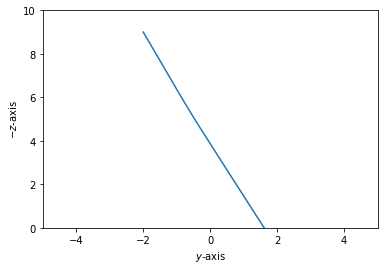

episode: 240/1000, score: -2891.553284998643  Average over last 100 episode: -2559.04 



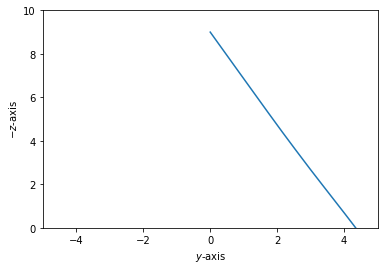

episode: 241/1000, score: -2032.987321935421  Average over last 100 episode: -2550.60 



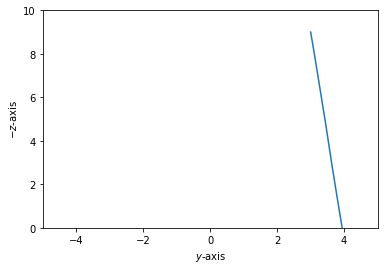

episode: 242/1000, score: -1930.8884175624771  Average over last 100 episode: -2547.73 



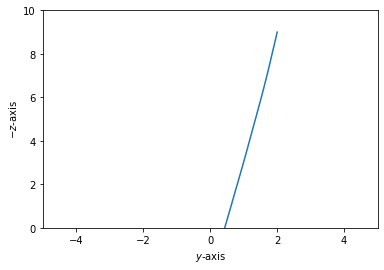

episode: 243/1000, score: -2014.6862368311806  Average over last 100 episode: -2535.85 



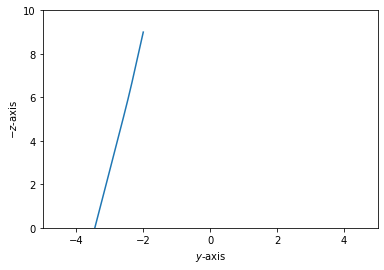

episode: 244/1000, score: -2165.2673790820218  Average over last 100 episode: -2533.14 



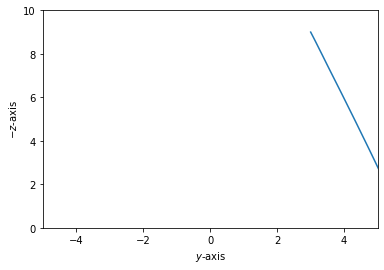

episode: 245/1000, score: -2771.972846892111  Average over last 100 episode: -2523.27 



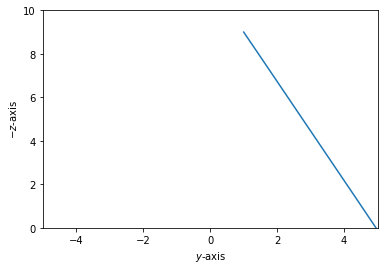

episode: 246/1000, score: -2737.8776072801897  Average over last 100 episode: -2522.91 



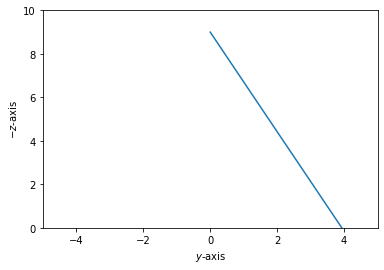

episode: 247/1000, score: -2480.9536684775503  Average over last 100 episode: -2526.25 



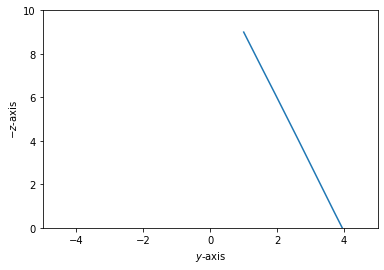

episode: 248/1000, score: -2672.0498229800505  Average over last 100 episode: -2524.89 



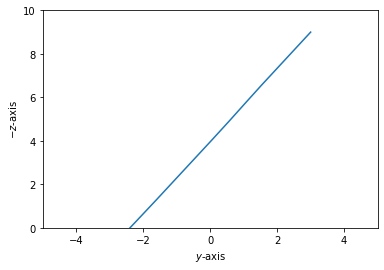

episode: 249/1000, score: -2227.112190032723  Average over last 100 episode: -2520.34 



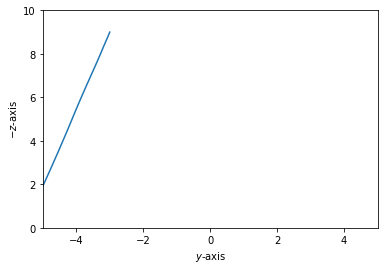

episode: 250/1000, score: -2435.2540211507708  Average over last 100 episode: -2521.66 



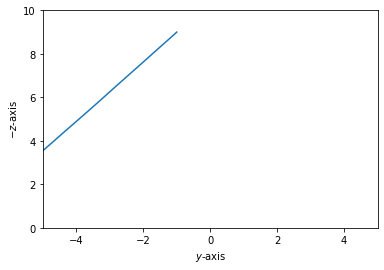

episode: 251/1000, score: -2636.985228931078  Average over last 100 episode: -2527.64 



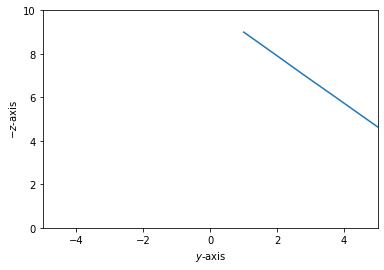

episode: 252/1000, score: -3319.7054752801832  Average over last 100 episode: -2537.90 



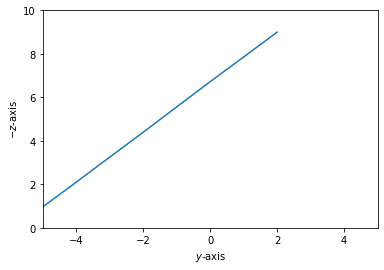

episode: 253/1000, score: -2101.5433946737853  Average over last 100 episode: -2540.33 



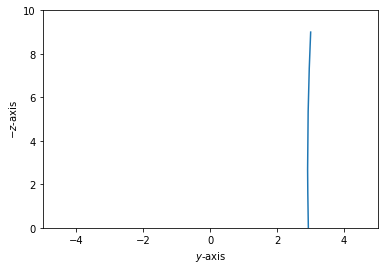

episode: 254/1000, score: -2179.512196852384  Average over last 100 episode: -2536.13 



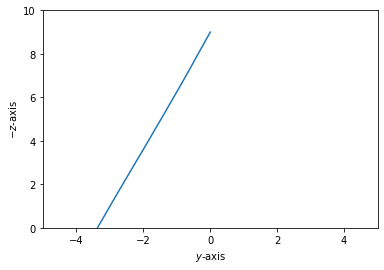

episode: 255/1000, score: -3581.606711303509  Average over last 100 episode: -2541.50 



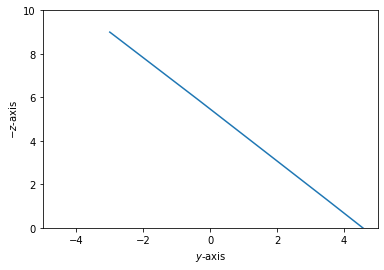

episode: 256/1000, score: -2198.7172447348007  Average over last 100 episode: -2530.48 



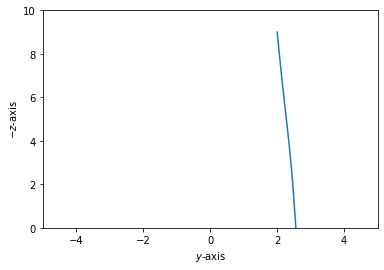

episode: 257/1000, score: -3769.903610324514  Average over last 100 episode: -2540.28 



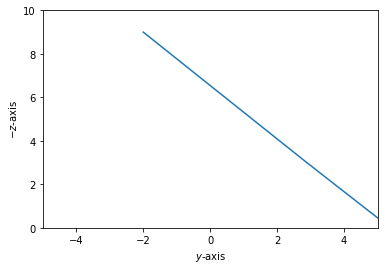

episode: 258/1000, score: -1915.0702327712095  Average over last 100 episode: -2538.51 



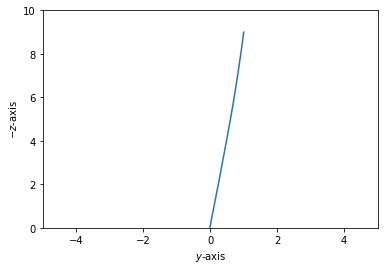

episode: 259/1000, score: -2073.340477974246  Average over last 100 episode: -2536.38 



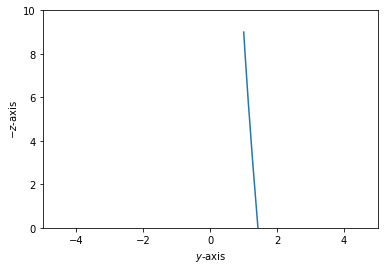

episode: 260/1000, score: -2134.677982343596  Average over last 100 episode: -2537.73 



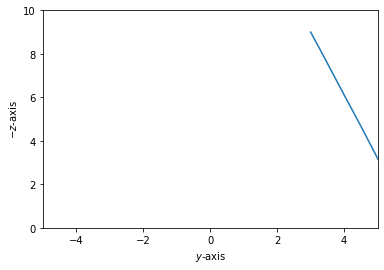

episode: 261/1000, score: -1918.5886213853146  Average over last 100 episode: -2534.17 



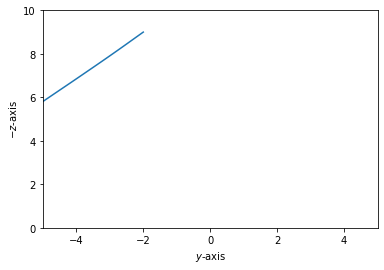

episode: 262/1000, score: -2460.86473101519  Average over last 100 episode: -2528.40 



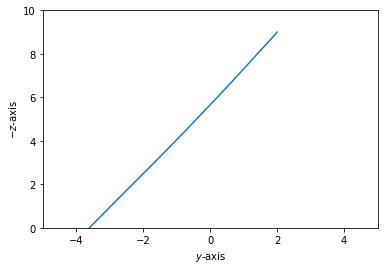

episode: 263/1000, score: -2028.7211368466806  Average over last 100 episode: -2530.31 



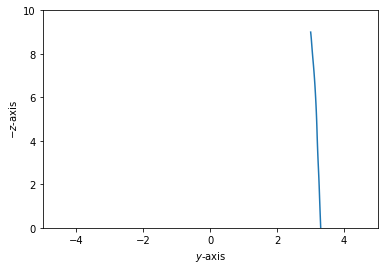

episode: 264/1000, score: -2283.25530313272  Average over last 100 episode: -2532.92 



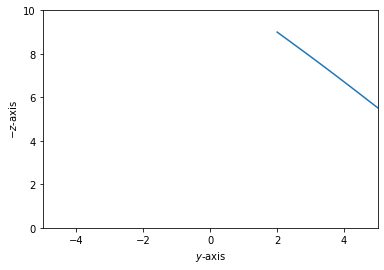

episode: 265/1000, score: -3254.279811899797  Average over last 100 episode: -2544.77 



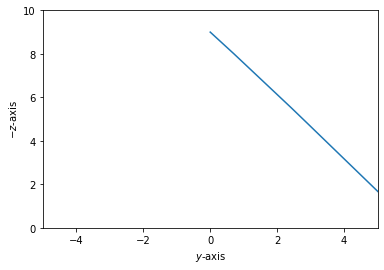

episode: 266/1000, score: -2295.266426903031  Average over last 100 episode: -2543.31 



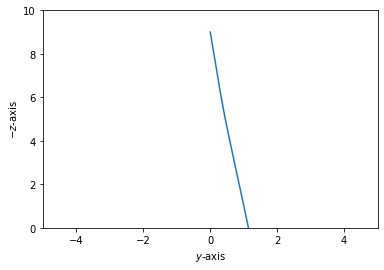

episode: 267/1000, score: -2148.374537662635  Average over last 100 episode: -2538.02 



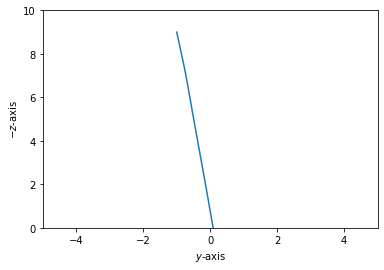

episode: 268/1000, score: -3048.005203757549  Average over last 100 episode: -2547.73 



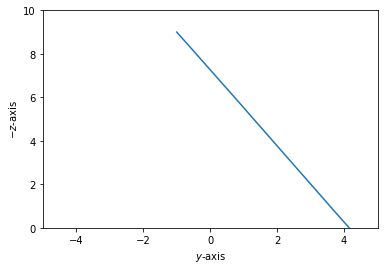

episode: 269/1000, score: -2317.701767719724  Average over last 100 episode: -2544.35 



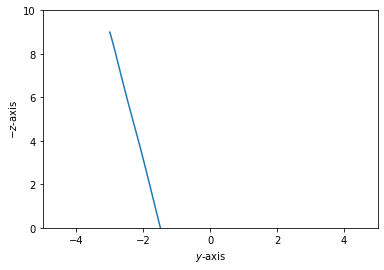

episode: 270/1000, score: -2940.4664170849787  Average over last 100 episode: -2550.43 



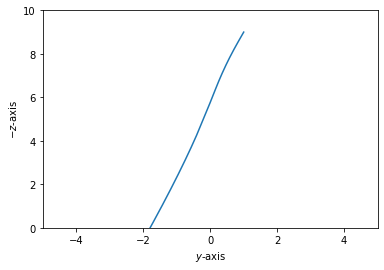

episode: 271/1000, score: -2892.130064673771  Average over last 100 episode: -2551.62 



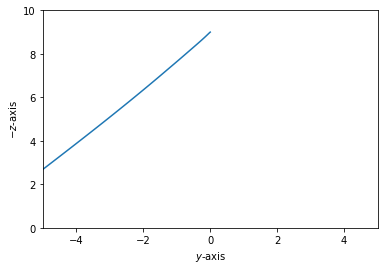

episode: 272/1000, score: -3137.267619005907  Average over last 100 episode: -2560.53 



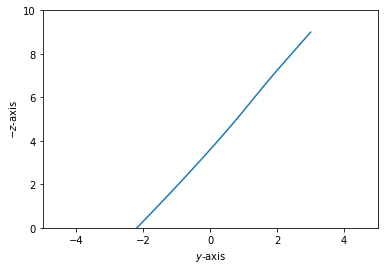

episode: 273/1000, score: -3603.8980054348035  Average over last 100 episode: -2561.85 



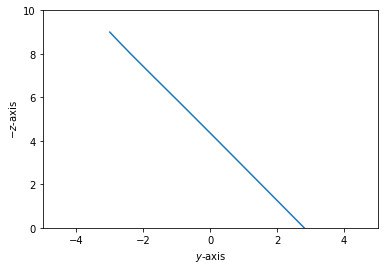

episode: 274/1000, score: -2654.5203275546132  Average over last 100 episode: -2559.50 



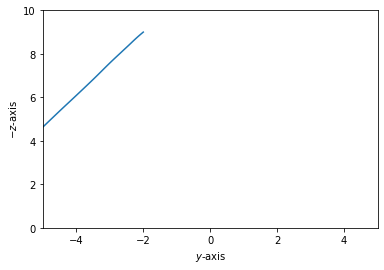

episode: 275/1000, score: -3710.21158557079  Average over last 100 episode: -2577.96 



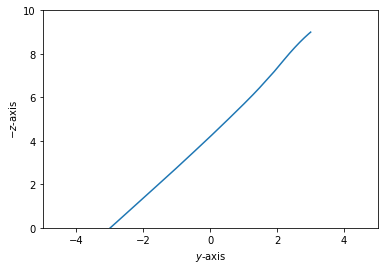

episode: 276/1000, score: -2489.150238306203  Average over last 100 episode: -2572.58 



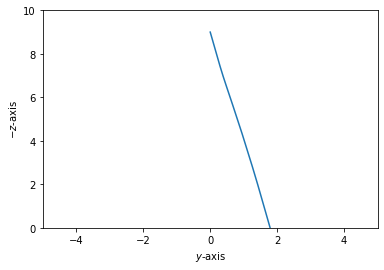

episode: 277/1000, score: -2569.9298670447643  Average over last 100 episode: -2572.12 



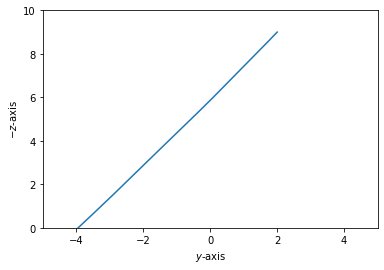

episode: 278/1000, score: -2789.12171049787  Average over last 100 episode: -2570.75 



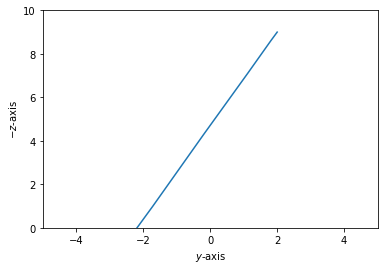

episode: 279/1000, score: -1927.2929322148368  Average over last 100 episode: -2568.67 



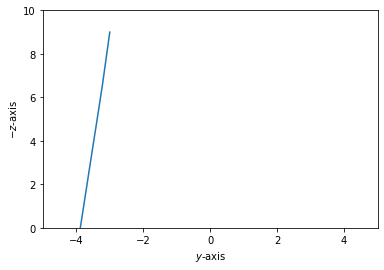

episode: 280/1000, score: -2064.1231168231197  Average over last 100 episode: -2568.26 



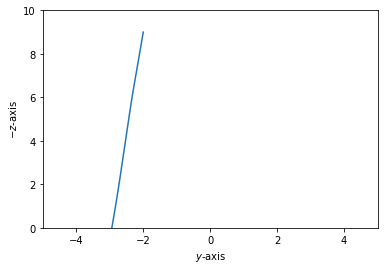

episode: 281/1000, score: -2899.5736810501553  Average over last 100 episode: -2565.36 



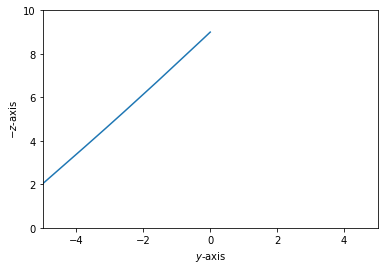

episode: 282/1000, score: -2657.0919117671833  Average over last 100 episode: -2570.66 



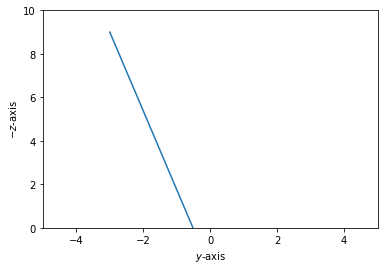

episode: 283/1000, score: -2890.625700353889  Average over last 100 episode: -2576.05 



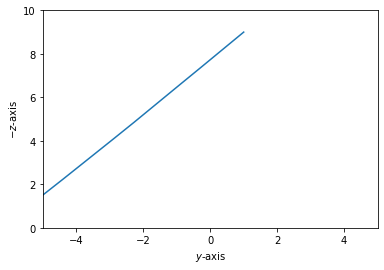

episode: 284/1000, score: -1896.961100923134  Average over last 100 episode: -2567.54 



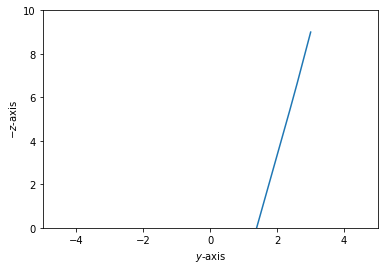

episode: 285/1000, score: -2761.0895214560505  Average over last 100 episode: -2564.05 



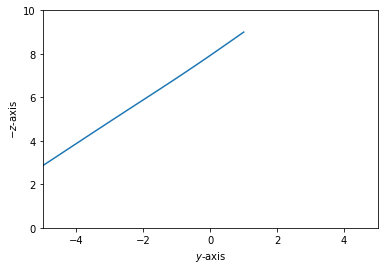

episode: 286/1000, score: -1864.6893677755586  Average over last 100 episode: -2549.69 



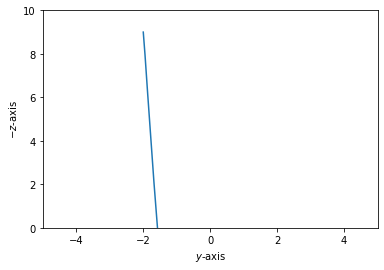

episode: 287/1000, score: -2075.685658865097  Average over last 100 episode: -2546.94 



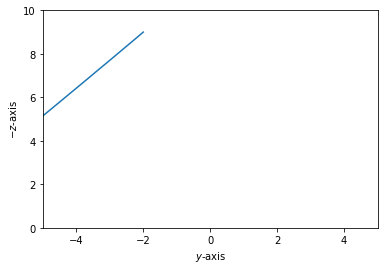

episode: 288/1000, score: -2180.5979738235856  Average over last 100 episode: -2544.91 



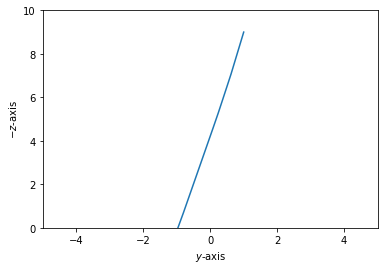

episode: 289/1000, score: -2354.2100787969475  Average over last 100 episode: -2539.27 



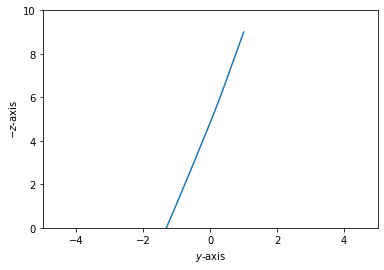

episode: 290/1000, score: -2640.5069773616374  Average over last 100 episode: -2528.83 



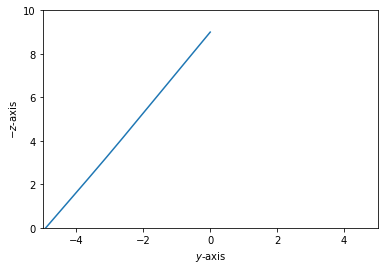

episode: 291/1000, score: -3467.8903394582685  Average over last 100 episode: -2535.14 



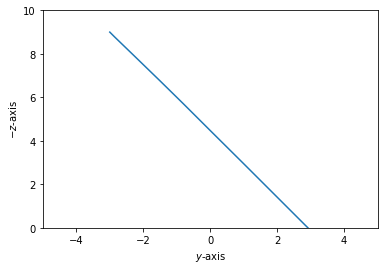

episode: 292/1000, score: -2203.4112044474773  Average over last 100 episode: -2530.48 



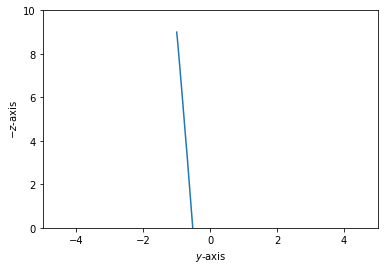

episode: 293/1000, score: -2161.391319167077  Average over last 100 episode: -2523.44 



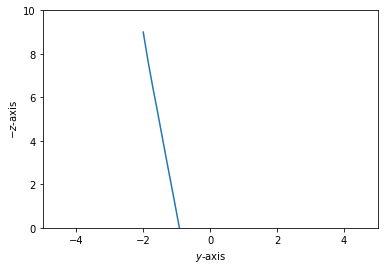

episode: 294/1000, score: -2846.9072668138006  Average over last 100 episode: -2526.97 



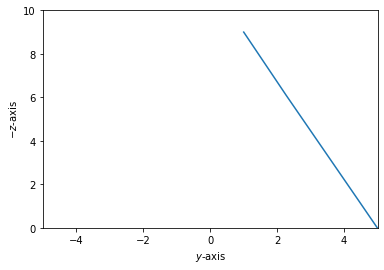

episode: 295/1000, score: -2095.959607207265  Average over last 100 episode: -2527.67 



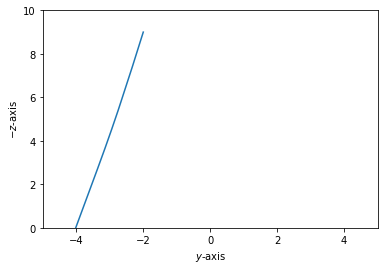

episode: 296/1000, score: -2418.936867178015  Average over last 100 episode: -2511.86 



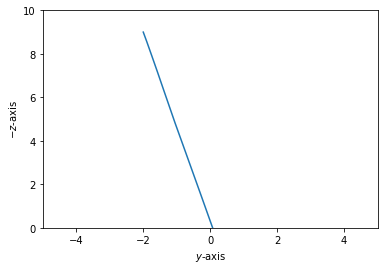

episode: 297/1000, score: -2058.90238948398  Average over last 100 episode: -2493.32 



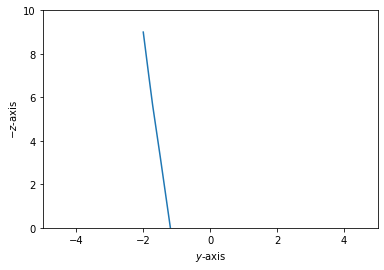

episode: 298/1000, score: -2828.0102897897  Average over last 100 episode: -2500.98 



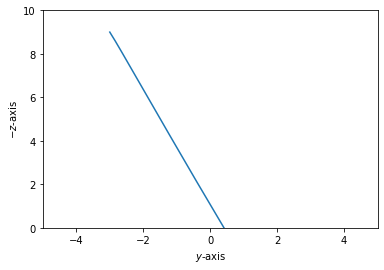

episode: 299/1000, score: -3168.7588229991197  Average over last 100 episode: -2510.96 



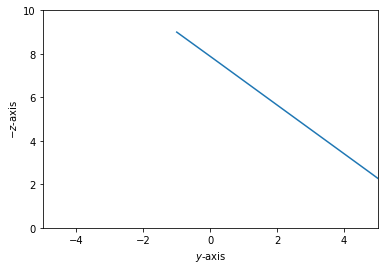

episode: 300/1000, score: -3035.198349818464  Average over last 100 episode: -2509.58 



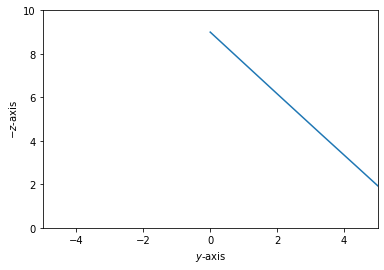

episode: 301/1000, score: -1920.5583135127838  Average over last 100 episode: -2506.82 



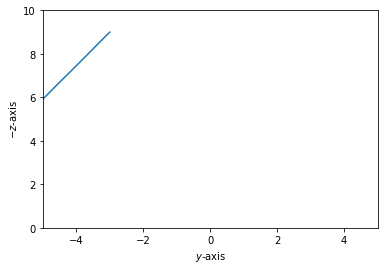

episode: 302/1000, score: -1982.1809525941794  Average over last 100 episode: -2505.64 



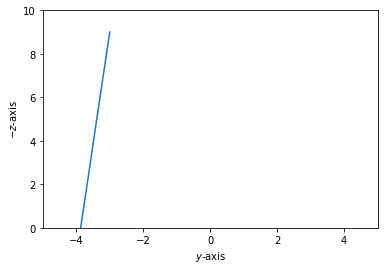

episode: 303/1000, score: -2213.0486569768786  Average over last 100 episode: -2506.85 



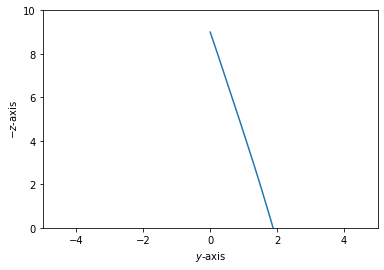

episode: 304/1000, score: -2107.0273144281696  Average over last 100 episode: -2503.42 



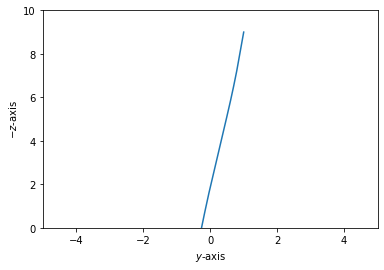

episode: 305/1000, score: -1928.876899116251  Average over last 100 episode: -2496.61 



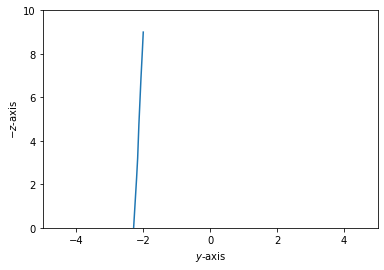

episode: 306/1000, score: -2752.524459694197  Average over last 100 episode: -2503.06 



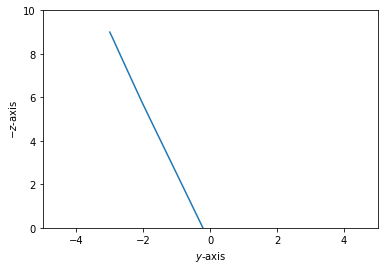

episode: 307/1000, score: -2724.505768239016  Average over last 100 episode: -2503.28 



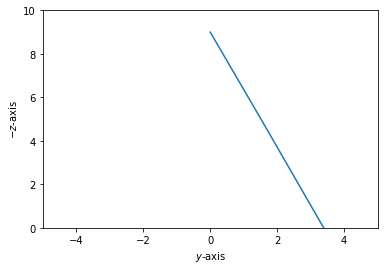

episode: 308/1000, score: -2504.1316619399613  Average over last 100 episode: -2508.53 



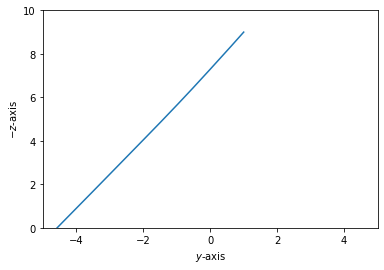

episode: 309/1000, score: -2735.783888683115  Average over last 100 episode: -2514.95 



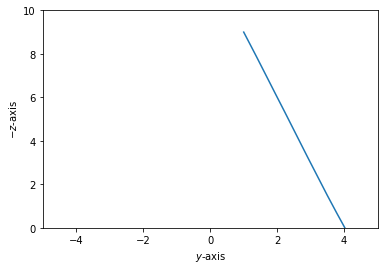

episode: 310/1000, score: -2017.482417369123  Average over last 100 episode: -2502.81 



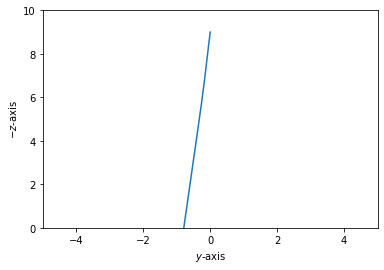

episode: 311/1000, score: -2842.9429044512767  Average over last 100 episode: -2508.74 



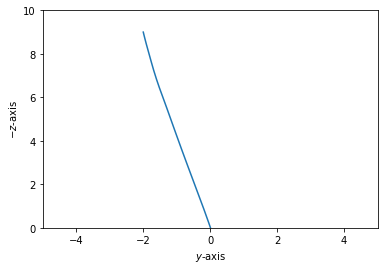

episode: 312/1000, score: -2736.3988911228457  Average over last 100 episode: -2510.55 



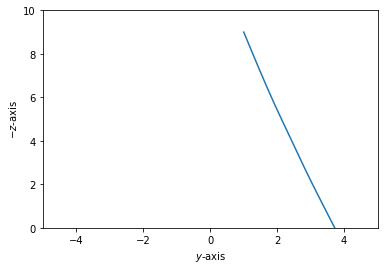

episode: 313/1000, score: -2969.5658370481497  Average over last 100 episode: -2520.50 



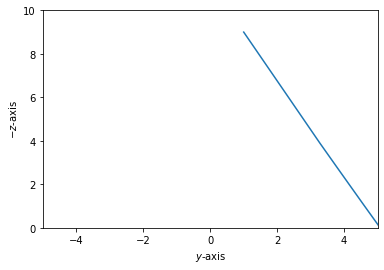

episode: 314/1000, score: -3494.419349272996  Average over last 100 episode: -2532.41 



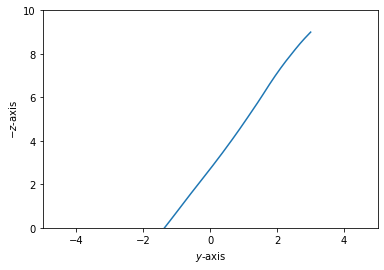

episode: 315/1000, score: -2123.4625145925625  Average over last 100 episode: -2533.08 



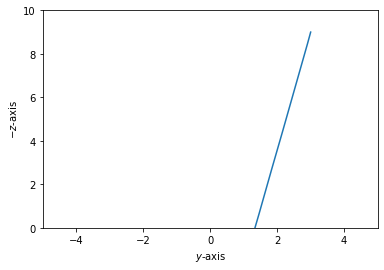

episode: 316/1000, score: -2153.4367342750775  Average over last 100 episode: -2528.68 



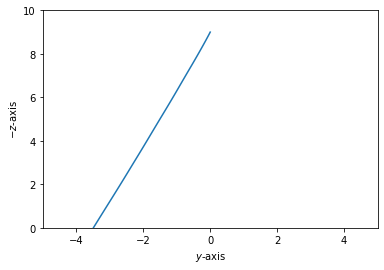

episode: 317/1000, score: -1773.820853029229  Average over last 100 episode: -2519.61 



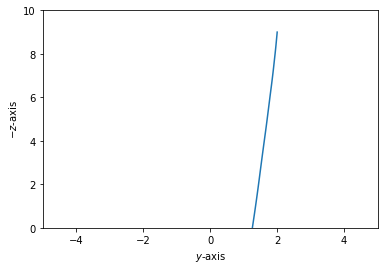

episode: 318/1000, score: -1960.4209612345219  Average over last 100 episode: -2509.18 



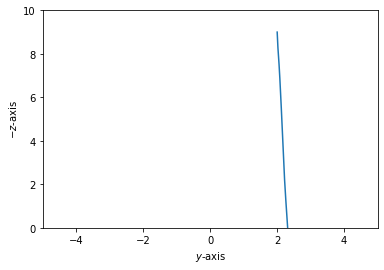

episode: 319/1000, score: -2525.1920142323306  Average over last 100 episode: -2512.06 



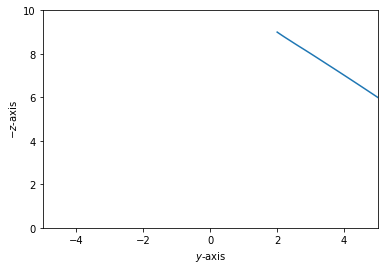

episode: 320/1000, score: -2088.1717367980564  Average over last 100 episode: -2514.04 



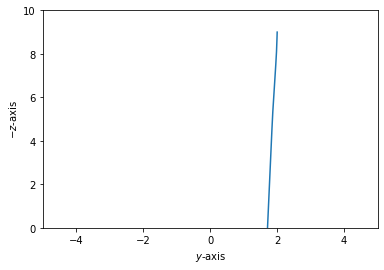

episode: 321/1000, score: -2758.473134180886  Average over last 100 episode: -2516.96 



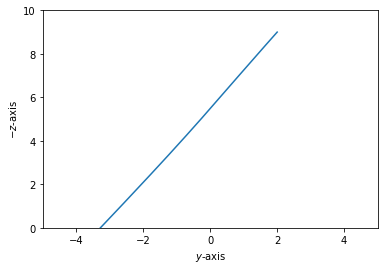

episode: 322/1000, score: -2094.044148579247  Average over last 100 episode: -2502.93 



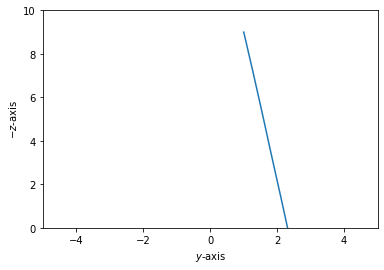

episode: 323/1000, score: -3329.855838084638  Average over last 100 episode: -2508.43 



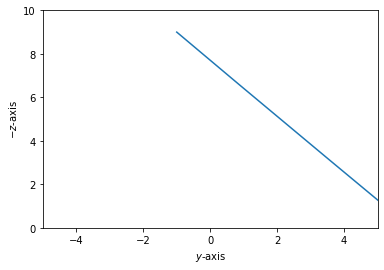

episode: 324/1000, score: -2172.251699359558  Average over last 100 episode: -2504.20 



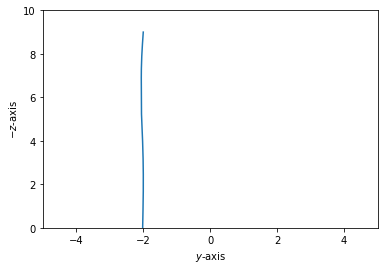

episode: 325/1000, score: -2696.7633418786845  Average over last 100 episode: -2507.07 



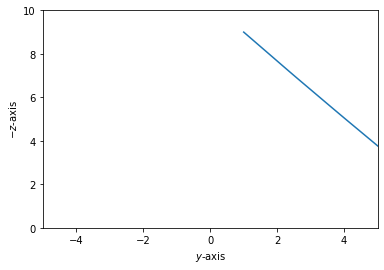

episode: 326/1000, score: -2444.891565327447  Average over last 100 episode: -2510.96 



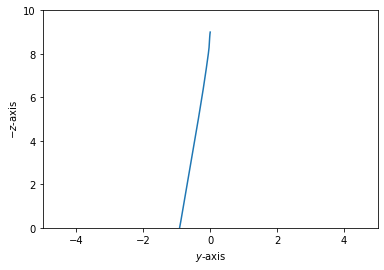

episode: 327/1000, score: -2121.2960023631654  Average over last 100 episode: -2503.66 



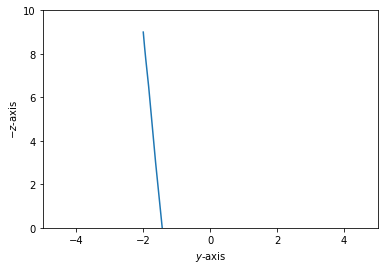

episode: 328/1000, score: -2963.9860977342755  Average over last 100 episode: -2502.81 



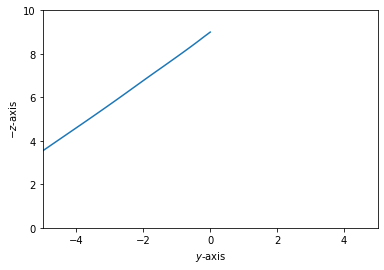

episode: 329/1000, score: -2108.9247563423087  Average over last 100 episode: -2499.96 



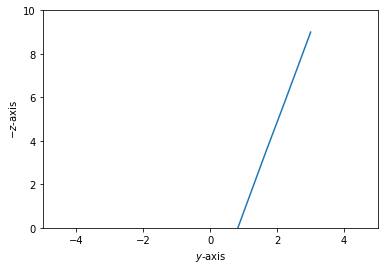

episode: 330/1000, score: -2267.1002932160163  Average over last 100 episode: -2497.83 



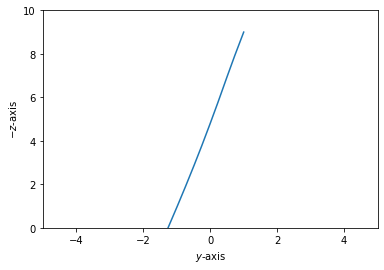

episode: 331/1000, score: -1804.5330455643787  Average over last 100 episode: -2494.54 



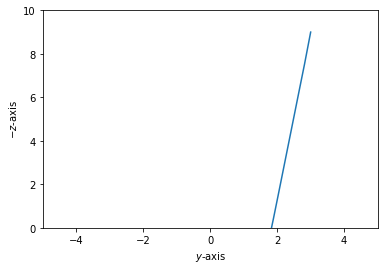

episode: 332/1000, score: -3470.895824428019  Average over last 100 episode: -2500.12 



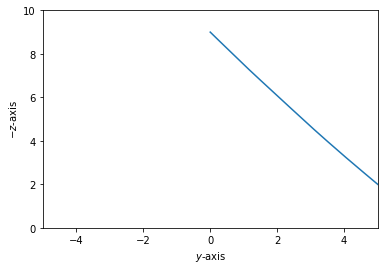

episode: 333/1000, score: -2356.3401666283  Average over last 100 episode: -2496.83 



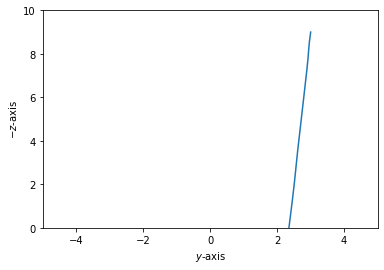

episode: 334/1000, score: -2959.8853476266427  Average over last 100 episode: -2498.71 



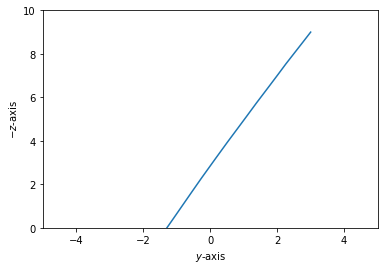

episode: 335/1000, score: -3236.316594639504  Average over last 100 episode: -2501.39 



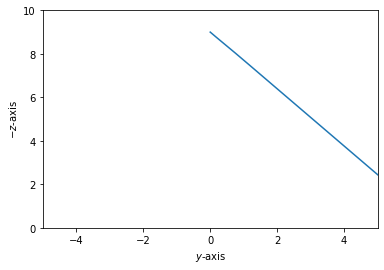

episode: 336/1000, score: -2129.592319029293  Average over last 100 episode: -2504.89 



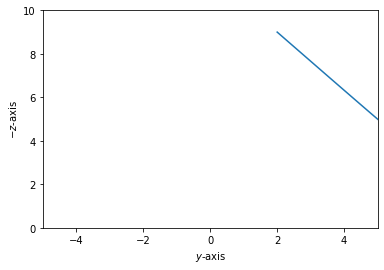

episode: 337/1000, score: -2488.572890486738  Average over last 100 episode: -2511.71 



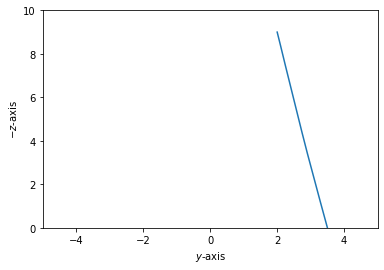

episode: 338/1000, score: -2361.0516709382164  Average over last 100 episode: -2515.44 



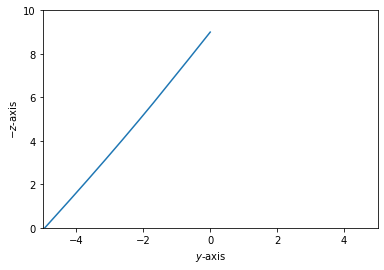

episode: 339/1000, score: -2505.6900937741925  Average over last 100 episode: -2511.36 



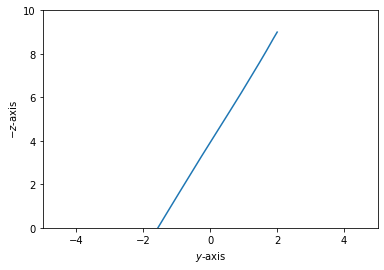

episode: 340/1000, score: -2640.6936178667665  Average over last 100 episode: -2508.85 



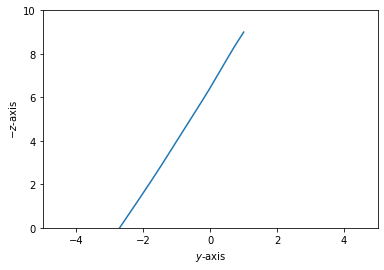

episode: 341/1000, score: -1976.2744276360704  Average over last 100 episode: -2508.28 



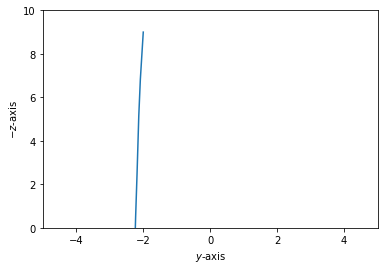

episode: 342/1000, score: -2368.543397357746  Average over last 100 episode: -2512.66 



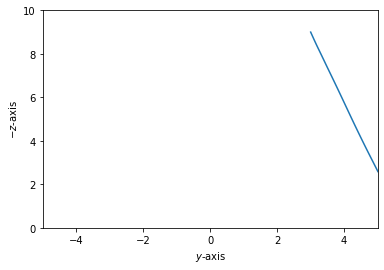

episode: 343/1000, score: -2493.547670426656  Average over last 100 episode: -2517.45 



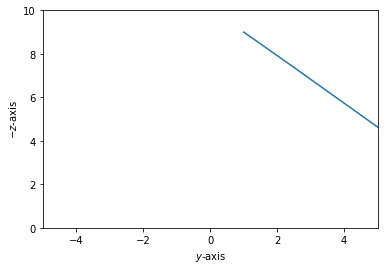

episode: 344/1000, score: -2744.060752772746  Average over last 100 episode: -2523.23 



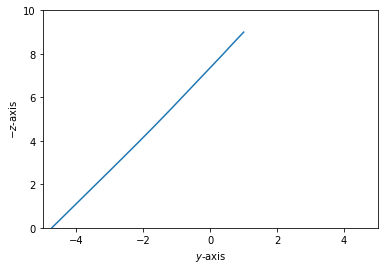

episode: 345/1000, score: -2157.9397494655655  Average over last 100 episode: -2517.09 



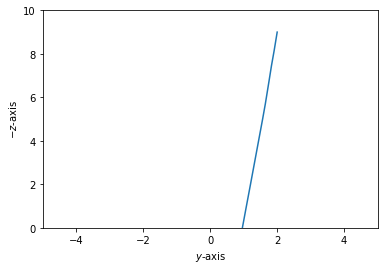

episode: 346/1000, score: -1928.651215854826  Average over last 100 episode: -2509.00 



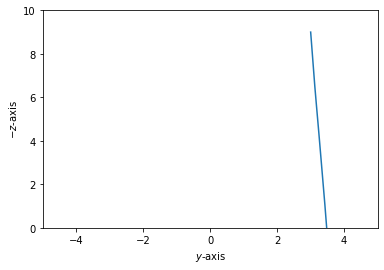

episode: 347/1000, score: -2169.2849291356674  Average over last 100 episode: -2505.88 



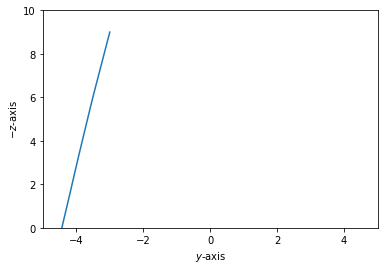

episode: 348/1000, score: -2865.895470468008  Average over last 100 episode: -2507.82 



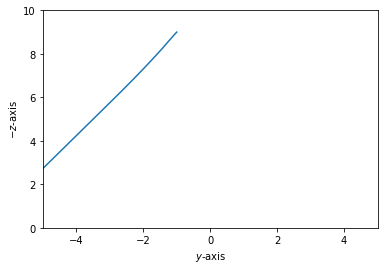

episode: 349/1000, score: -1938.0947858219922  Average over last 100 episode: -2504.93 



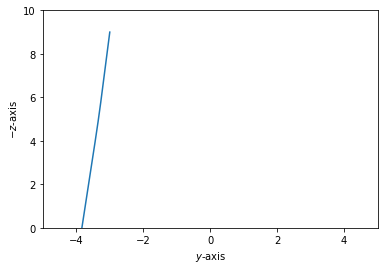

episode: 350/1000, score: -2225.4320965042884  Average over last 100 episode: -2502.83 



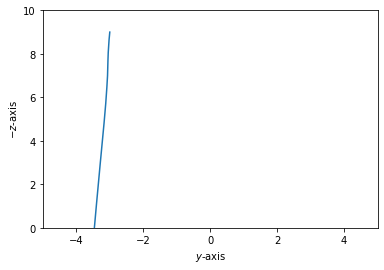

episode: 351/1000, score: -1920.7875985210833  Average over last 100 episode: -2495.67 



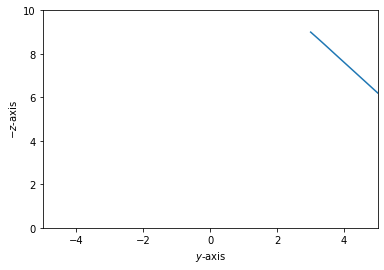

episode: 352/1000, score: -2807.1810915261194  Average over last 100 episode: -2490.55 



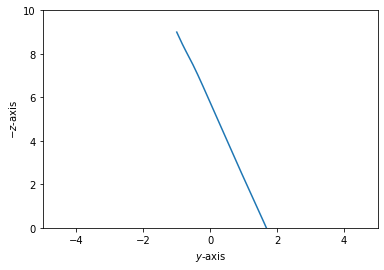

episode: 353/1000, score: -3209.3782503091593  Average over last 100 episode: -2501.63 



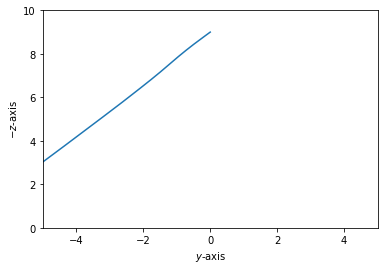

episode: 354/1000, score: -3004.9162724721127  Average over last 100 episode: -2509.88 



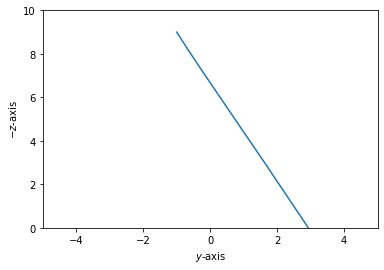

episode: 355/1000, score: -3336.1995850446197  Average over last 100 episode: -2507.43 



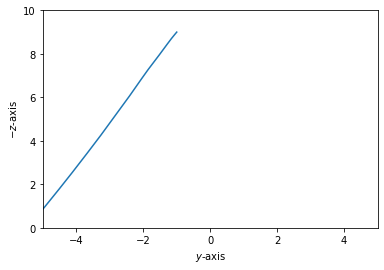

episode: 356/1000, score: -2451.984193851788  Average over last 100 episode: -2509.96 



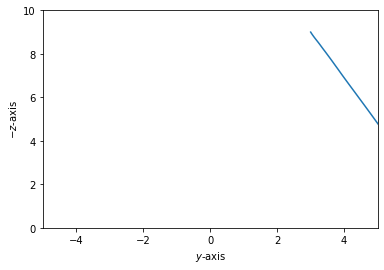

episode: 357/1000, score: -3321.758377169441  Average over last 100 episode: -2505.48 



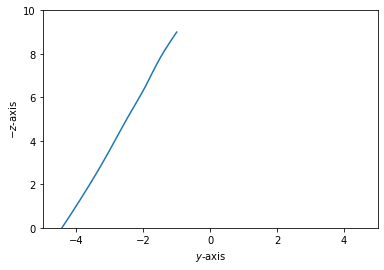

episode: 358/1000, score: -1999.7974139186974  Average over last 100 episode: -2506.32 



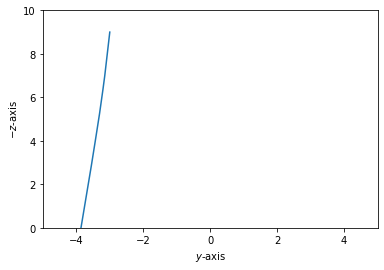

episode: 359/1000, score: -2837.897456624632  Average over last 100 episode: -2513.97 



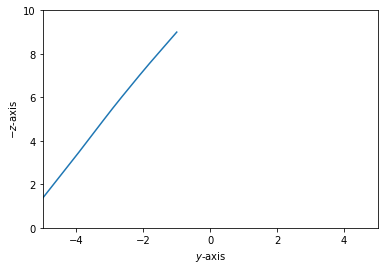

episode: 360/1000, score: -1872.2876478628186  Average over last 100 episode: -2511.35 



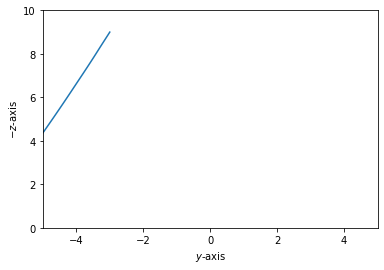

episode: 361/1000, score: -3192.244839348355  Average over last 100 episode: -2524.08 



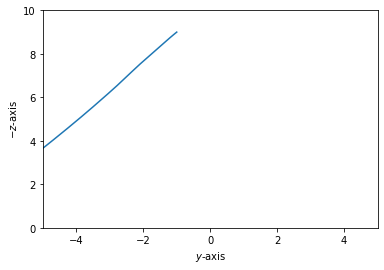

episode: 362/1000, score: -3227.091701711167  Average over last 100 episode: -2531.74 



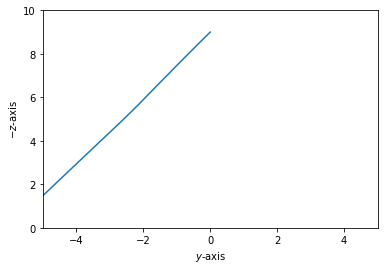

episode: 363/1000, score: -3528.2883205643084  Average over last 100 episode: -2546.74 



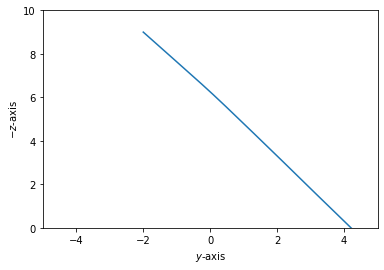

episode: 364/1000, score: -3281.6259025794907  Average over last 100 episode: -2556.72 



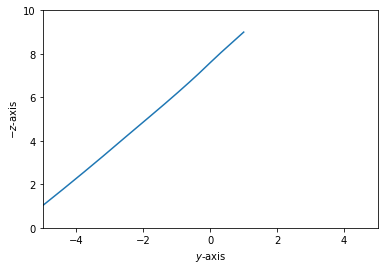

episode: 365/1000, score: -2311.0188087149722  Average over last 100 episode: -2547.29 



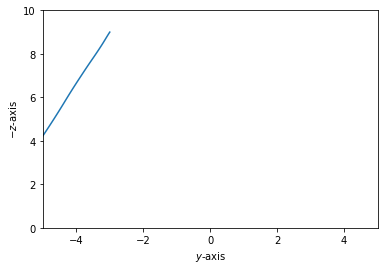

episode: 366/1000, score: -2748.109560437906  Average over last 100 episode: -2551.82 



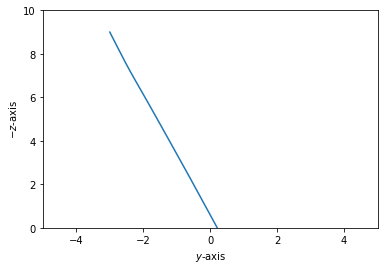

episode: 367/1000, score: -2955.418856409044  Average over last 100 episode: -2559.89 



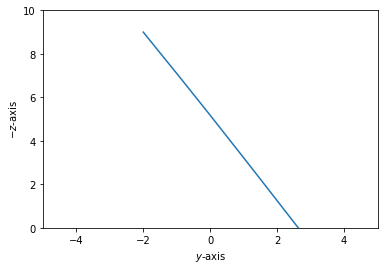

episode: 368/1000, score: -2553.3619816610635  Average over last 100 episode: -2554.94 



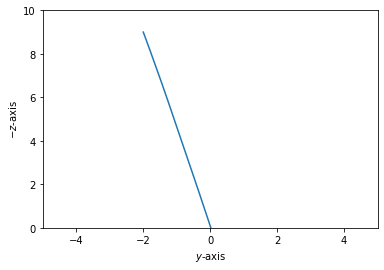

episode: 369/1000, score: -2541.3732491677997  Average over last 100 episode: -2557.18 



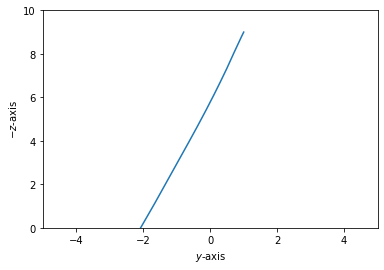

episode: 370/1000, score: -2014.2569666935024  Average over last 100 episode: -2547.92 



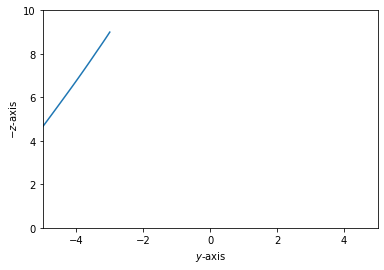

episode: 371/1000, score: -2094.183426410885  Average over last 100 episode: -2539.94 



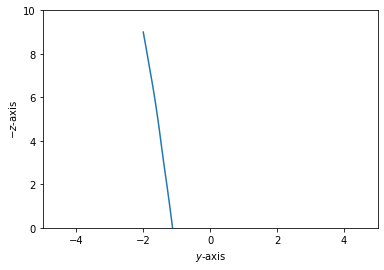

episode: 372/1000, score: -3144.9597033140662  Average over last 100 episode: -2540.02 



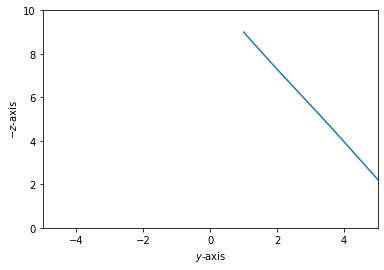

episode: 373/1000, score: -2047.5097769199895  Average over last 100 episode: -2524.45 



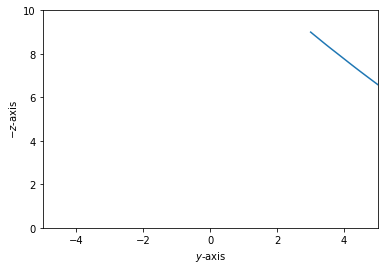

episode: 374/1000, score: -2198.8227939162043  Average over last 100 episode: -2519.90 



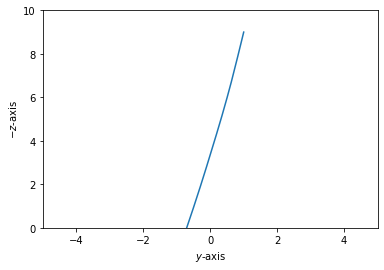

episode: 375/1000, score: -1735.6674526421696  Average over last 100 episode: -2500.15 



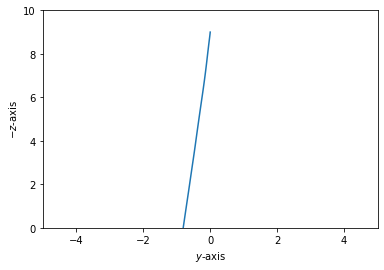

episode: 376/1000, score: -2101.1165999962864  Average over last 100 episode: -2496.27 



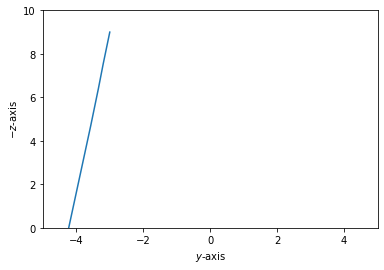

episode: 377/1000, score: -3173.2899370831674  Average over last 100 episode: -2502.30 



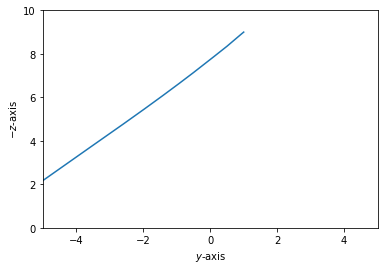

episode: 378/1000, score: -2885.719039997174  Average over last 100 episode: -2503.27 



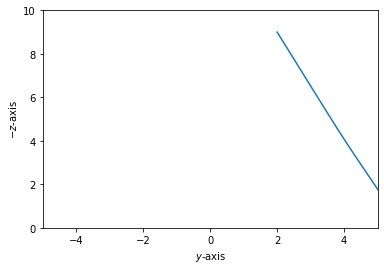

episode: 379/1000, score: -2791.0554034830297  Average over last 100 episode: -2511.91 



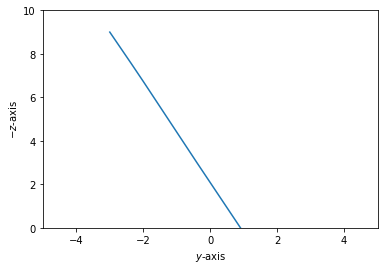

episode: 380/1000, score: -2231.0567555792654  Average over last 100 episode: -2513.58 



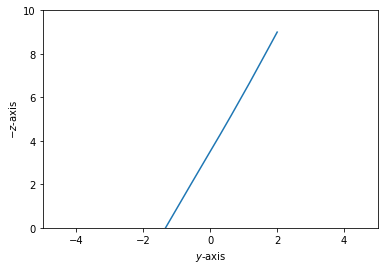

episode: 381/1000, score: -3202.244825345546  Average over last 100 episode: -2516.60 



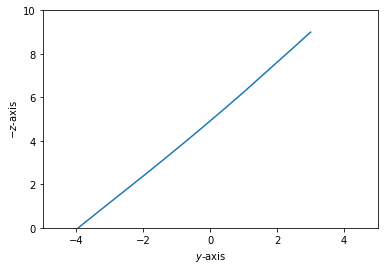

episode: 382/1000, score: -3842.342796089391  Average over last 100 episode: -2528.46 



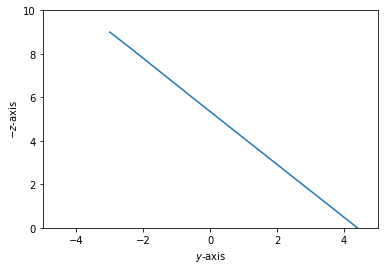

episode: 383/1000, score: -2094.7077547425015  Average over last 100 episode: -2520.50 



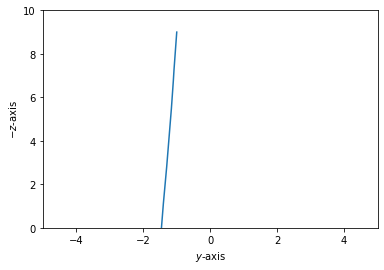

episode: 384/1000, score: -3608.488060226747  Average over last 100 episode: -2537.61 



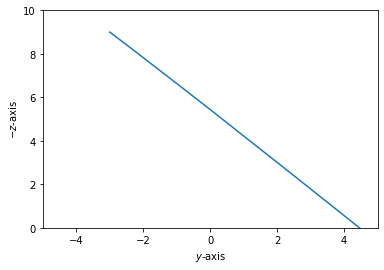

episode: 385/1000, score: -3034.888312709098  Average over last 100 episode: -2540.35 



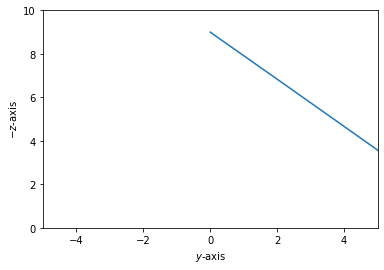

episode: 386/1000, score: -2451.807729253938  Average over last 100 episode: -2546.22 



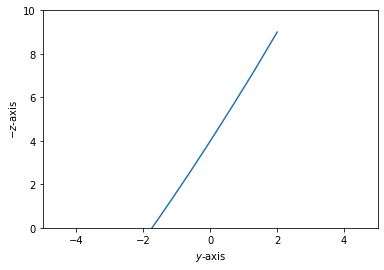

episode: 387/1000, score: -2118.4245095901874  Average over last 100 episode: -2546.65 



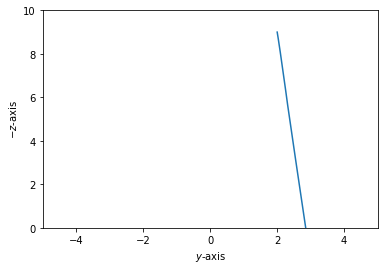

episode: 388/1000, score: -2321.12365050054  Average over last 100 episode: -2548.05 



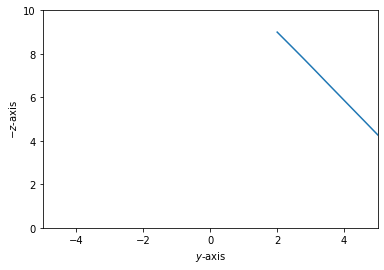

episode: 389/1000, score: -2620.68934967335  Average over last 100 episode: -2550.72 



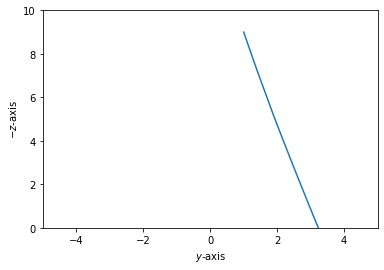

episode: 390/1000, score: -2230.773181036033  Average over last 100 episode: -2546.62 



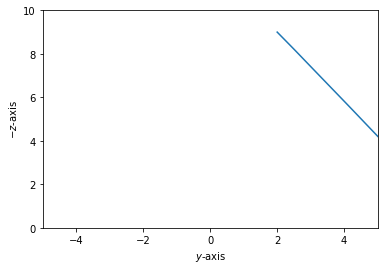

episode: 391/1000, score: -2733.796538180365  Average over last 100 episode: -2539.28 



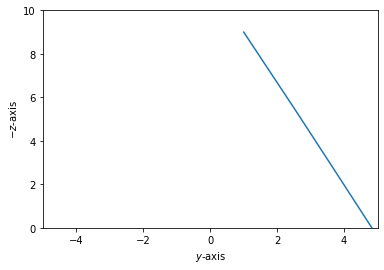

episode: 392/1000, score: -2782.8531800486  Average over last 100 episode: -2545.07 



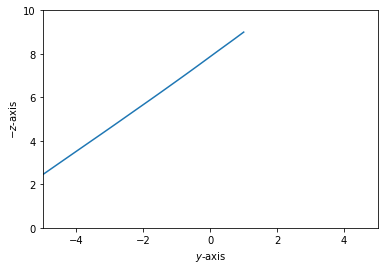

episode: 393/1000, score: -2013.7341563686682  Average over last 100 episode: -2543.60 



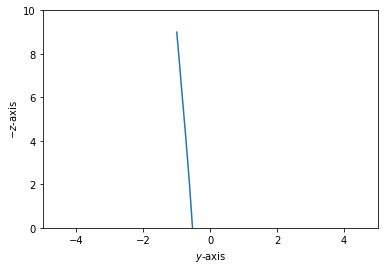

episode: 394/1000, score: -2586.0539648919544  Average over last 100 episode: -2540.99 



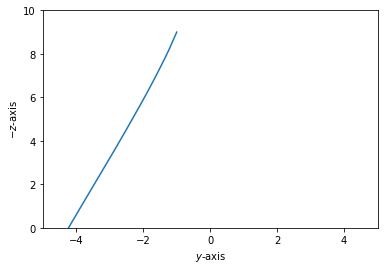

episode: 395/1000, score: -2241.098287049753  Average over last 100 episode: -2542.44 



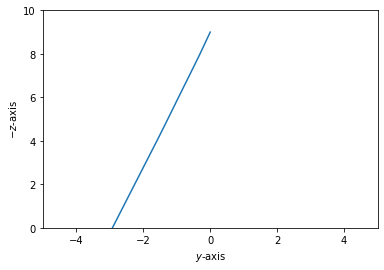

episode: 396/1000, score: -2002.1685468959372  Average over last 100 episode: -2538.27 



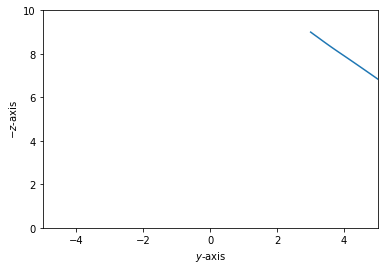

episode: 397/1000, score: -2258.9098157610674  Average over last 100 episode: -2540.27 



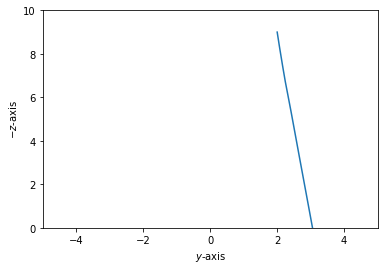

episode: 398/1000, score: -2116.884969737664  Average over last 100 episode: -2533.16 



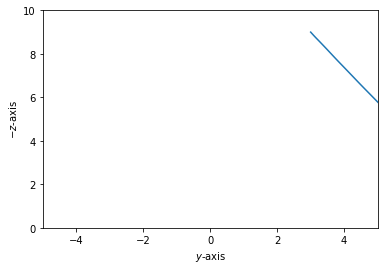

episode: 399/1000, score: -2727.5902855775166  Average over last 100 episode: -2528.75 



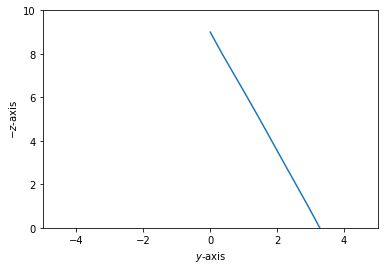

episode: 400/1000, score: -2354.789429408316  Average over last 100 episode: -2521.95 



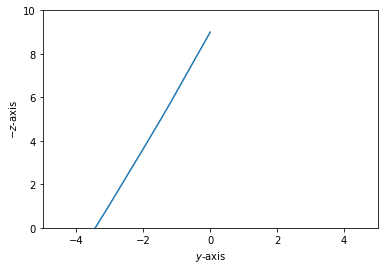

episode: 401/1000, score: -3533.8082903327686  Average over last 100 episode: -2538.08 



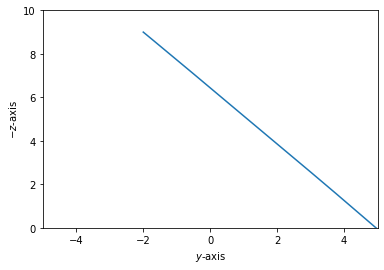

episode: 402/1000, score: -2448.798715997351  Average over last 100 episode: -2542.74 



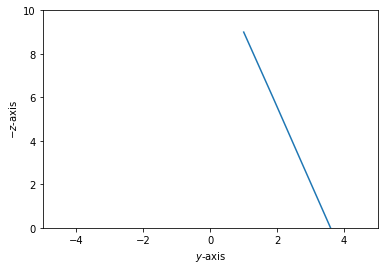

episode: 403/1000, score: -1923.309803768697  Average over last 100 episode: -2539.85 



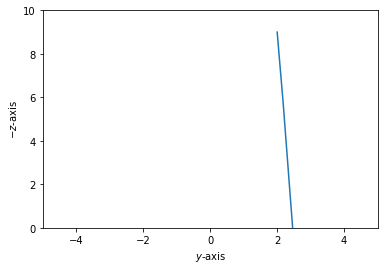

episode: 404/1000, score: -1960.31197572527  Average over last 100 episode: -2538.38 



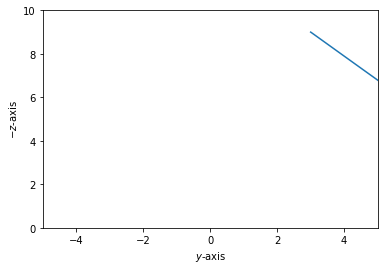

episode: 405/1000, score: -3206.412377912425  Average over last 100 episode: -2551.16 



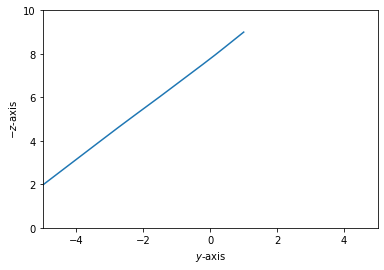

episode: 406/1000, score: -2190.4331725452134  Average over last 100 episode: -2545.53 



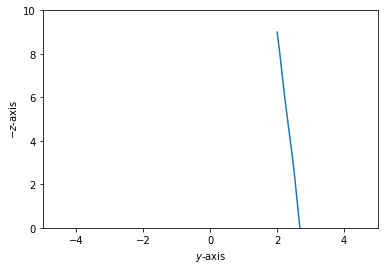

episode: 407/1000, score: -1723.6055586272446  Average over last 100 episode: -2535.53 



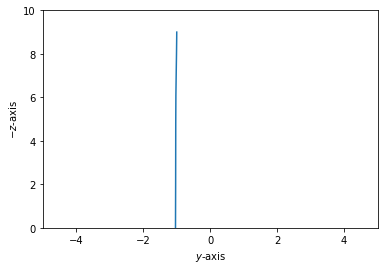

episode: 408/1000, score: -2584.1136169675588  Average over last 100 episode: -2536.33 



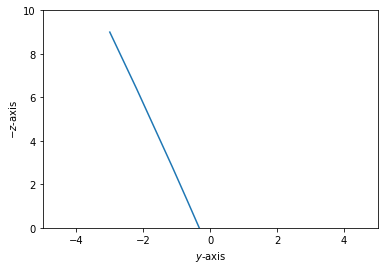

episode: 409/1000, score: -2385.6355234551265  Average over last 100 episode: -2532.82 



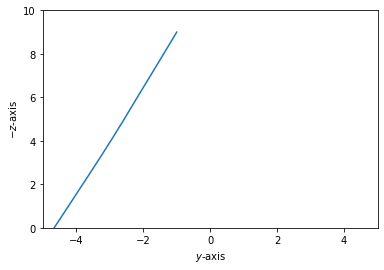

episode: 410/1000, score: -2488.0678914809355  Average over last 100 episode: -2537.53 



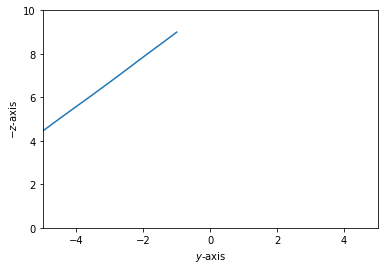

episode: 411/1000, score: -2749.777566898256  Average over last 100 episode: -2536.60 



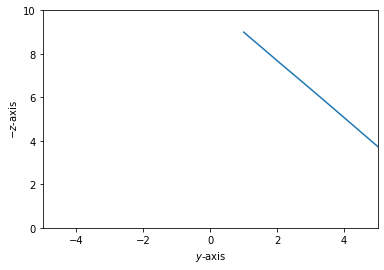

episode: 412/1000, score: -2466.312555200582  Average over last 100 episode: -2533.90 



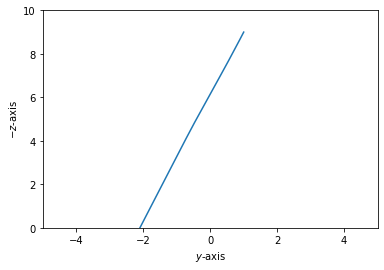

episode: 413/1000, score: -3219.5997192484842  Average over last 100 episode: -2536.40 



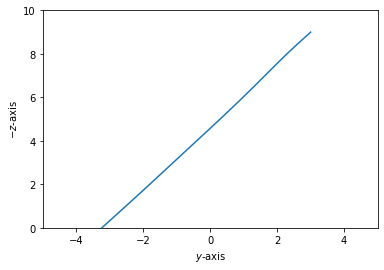

episode: 414/1000, score: -3220.461202301819  Average over last 100 episode: -2533.66 



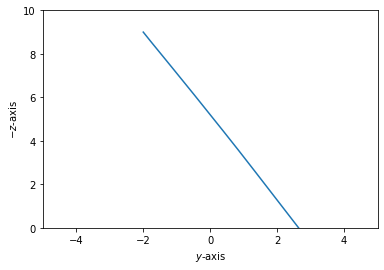

episode: 415/1000, score: -2298.4872570516354  Average over last 100 episode: -2535.41 



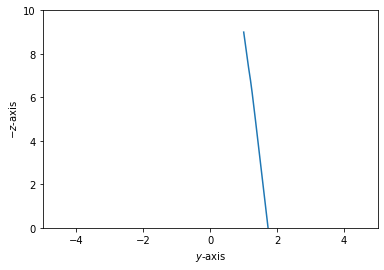

episode: 416/1000, score: -1913.00649975975  Average over last 100 episode: -2533.00 



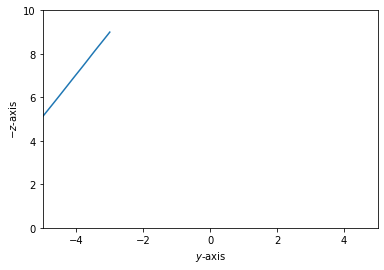

episode: 417/1000, score: -2141.768432401975  Average over last 100 episode: -2536.68 



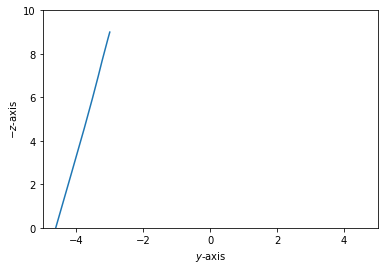

episode: 418/1000, score: -1991.739866467846  Average over last 100 episode: -2537.00 



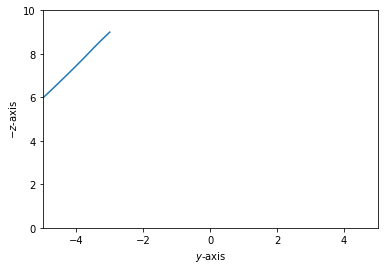

episode: 419/1000, score: -2627.807336505238  Average over last 100 episode: -2538.02 



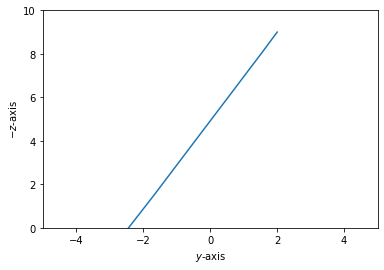

episode: 420/1000, score: -2396.961664362413  Average over last 100 episode: -2541.11 



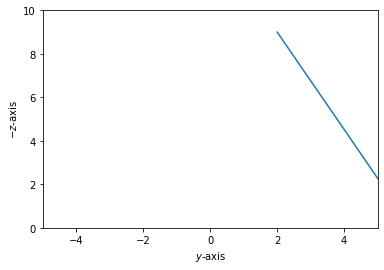

episode: 421/1000, score: -2485.5862143446916  Average over last 100 episode: -2538.38 



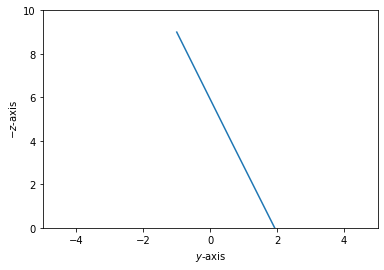

episode: 422/1000, score: -2481.3404491911792  Average over last 100 episode: -2542.25 



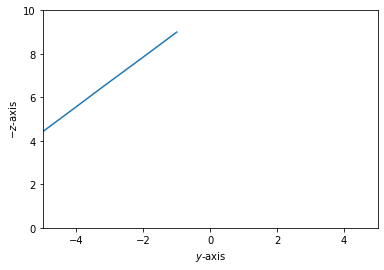

episode: 423/1000, score: -2464.381771231004  Average over last 100 episode: -2533.60 



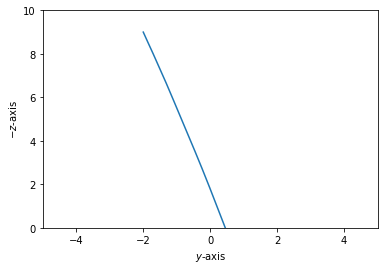

episode: 424/1000, score: -2594.3413665922953  Average over last 100 episode: -2537.82 



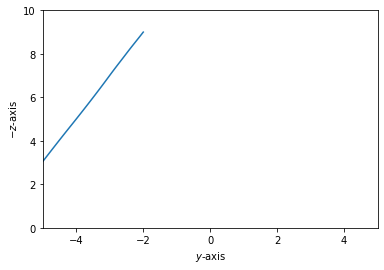

episode: 425/1000, score: -2071.7095174179294  Average over last 100 episode: -2531.57 



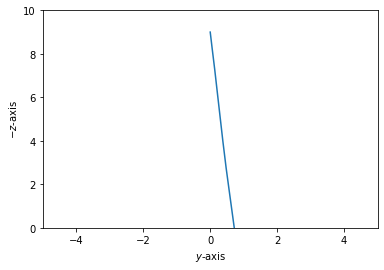

episode: 426/1000, score: -3171.815965129665  Average over last 100 episode: -2538.84 



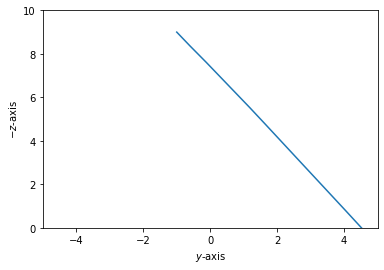

episode: 427/1000, score: -2519.9828784318183  Average over last 100 episode: -2542.83 



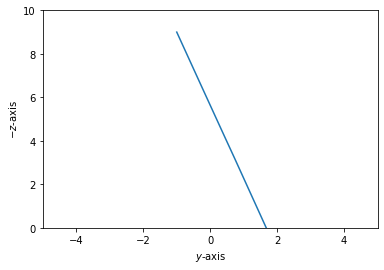

episode: 428/1000, score: -2585.667638720539  Average over last 100 episode: -2539.04 



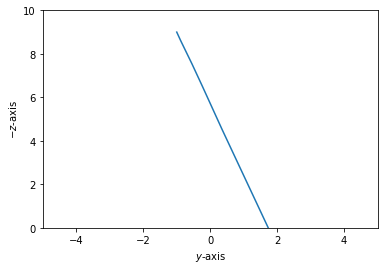

episode: 429/1000, score: -3177.9018042324515  Average over last 100 episode: -2549.73 



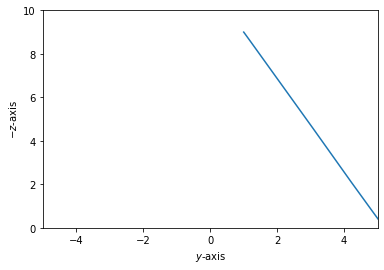

episode: 430/1000, score: -2307.01499062251  Average over last 100 episode: -2550.13 



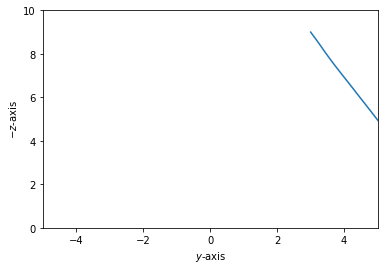

episode: 431/1000, score: -2645.497126588097  Average over last 100 episode: -2558.54 



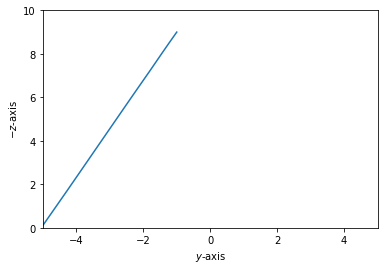

episode: 432/1000, score: -2663.593909399815  Average over last 100 episode: -2550.47 



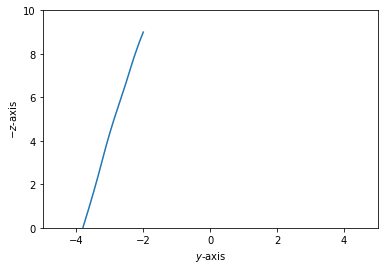

episode: 433/1000, score: -2636.6554615594714  Average over last 100 episode: -2553.27 



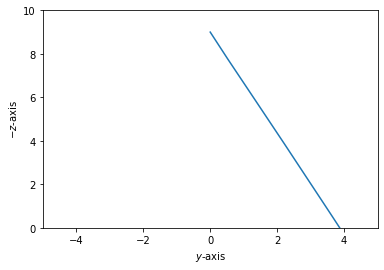

episode: 434/1000, score: -1922.205470851418  Average over last 100 episode: -2542.89 



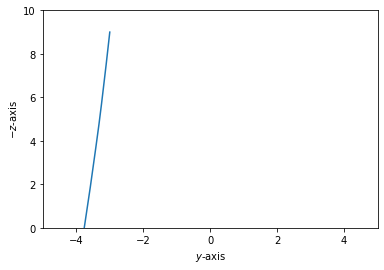

episode: 435/1000, score: -2181.9598350854812  Average over last 100 episode: -2532.35 



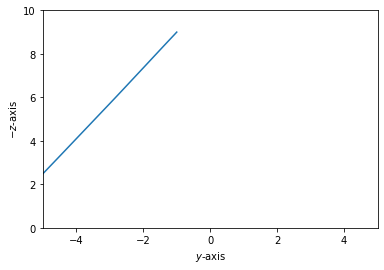

episode: 436/1000, score: -1814.1930009477217  Average over last 100 episode: -2529.20 



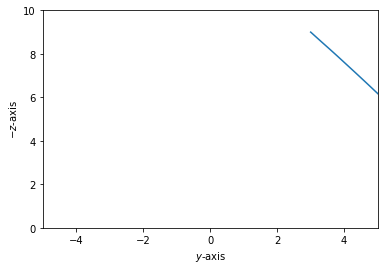

episode: 437/1000, score: -2055.2456322663725  Average over last 100 episode: -2524.86 



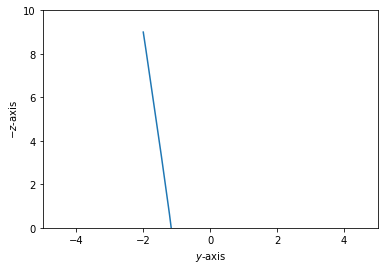

episode: 438/1000, score: -2376.591543778749  Average over last 100 episode: -2525.02 



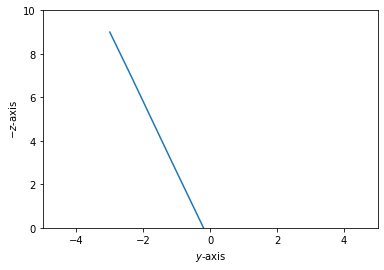

episode: 439/1000, score: -2388.317854805457  Average over last 100 episode: -2523.85 



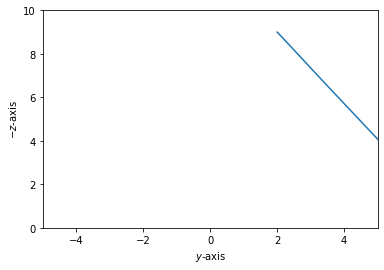

episode: 440/1000, score: -2292.064039590777  Average over last 100 episode: -2520.36 



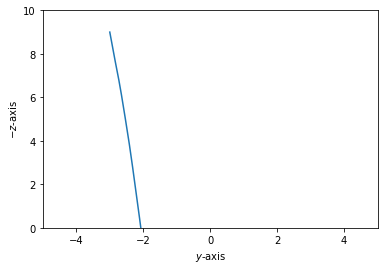

episode: 441/1000, score: -1924.4421811681184  Average over last 100 episode: -2519.84 



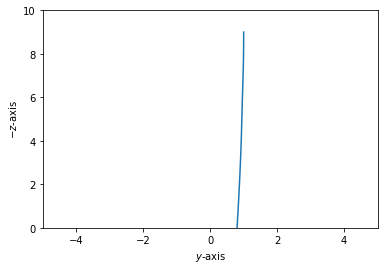

episode: 442/1000, score: -2259.8977021425044  Average over last 100 episode: -2518.75 



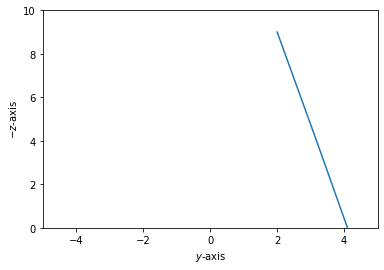

episode: 443/1000, score: -2114.8259541264147  Average over last 100 episode: -2514.97 



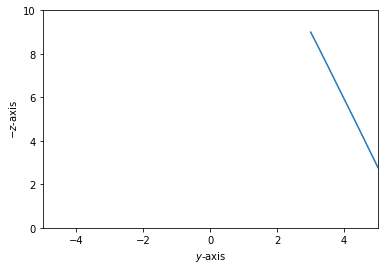

episode: 444/1000, score: -2772.1834383588966  Average over last 100 episode: -2515.25 



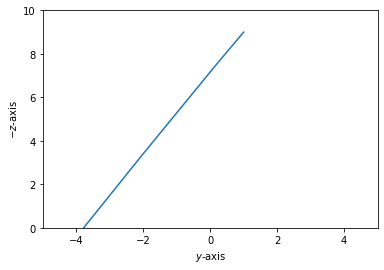

episode: 445/1000, score: -1893.6659576286388  Average over last 100 episode: -2512.61 



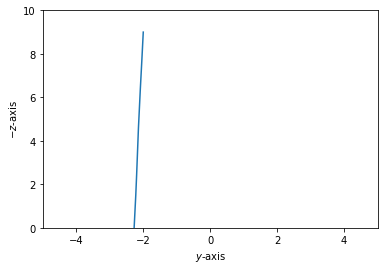

episode: 446/1000, score: -2247.920762297663  Average over last 100 episode: -2515.80 



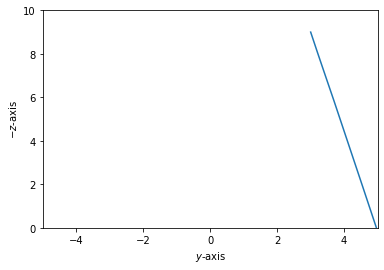

episode: 447/1000, score: -2757.3412410640663  Average over last 100 episode: -2521.68 



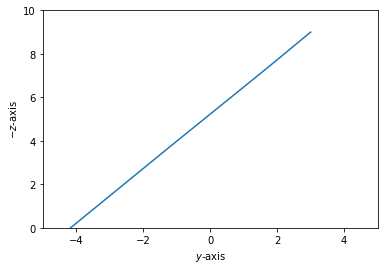

episode: 448/1000, score: -2021.601502986902  Average over last 100 episode: -2513.24 



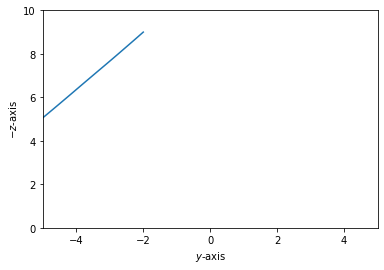

episode: 449/1000, score: -2977.624272057493  Average over last 100 episode: -2523.63 



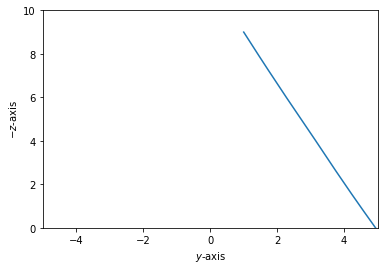

episode: 450/1000, score: -2024.6596238651368  Average over last 100 episode: -2521.62 



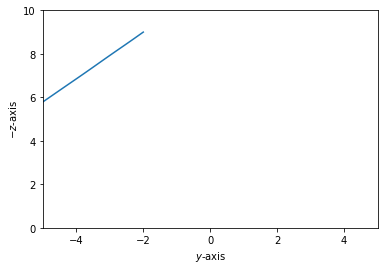

episode: 451/1000, score: -1860.504194876602  Average over last 100 episode: -2521.02 



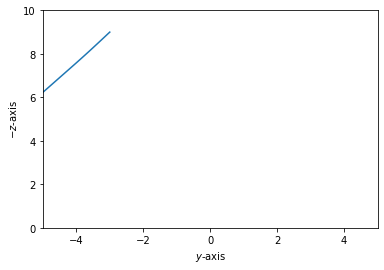

episode: 452/1000, score: -2156.657385407299  Average over last 100 episode: -2514.52 



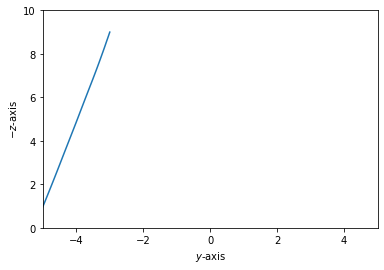

episode: 453/1000, score: -1879.7224106434016  Average over last 100 episode: -2501.22 



episode: 454/1000, score: -3564.246568547404  Average over last 100 episode: -2506.81 



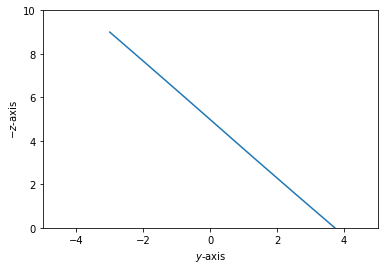

episode: 455/1000, score: -1872.418318850353  Average over last 100 episode: -2492.17 



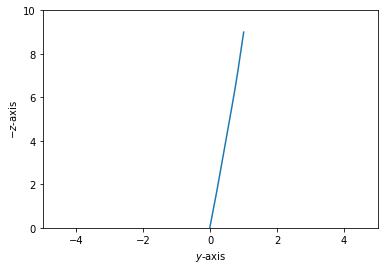

episode: 456/1000, score: -2022.1770781840282  Average over last 100 episode: -2487.88 



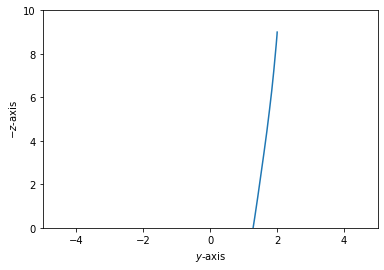

episode: 457/1000, score: -2111.3775002444654  Average over last 100 episode: -2475.77 



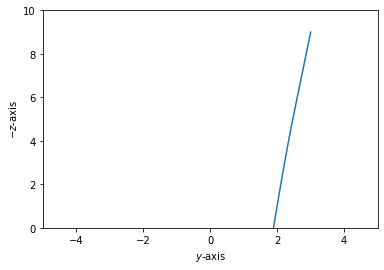

episode: 458/1000, score: -2489.4829799405384  Average over last 100 episode: -2480.67 



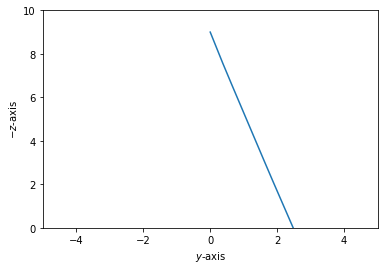

episode: 459/1000, score: -2224.8236834924082  Average over last 100 episode: -2474.54 



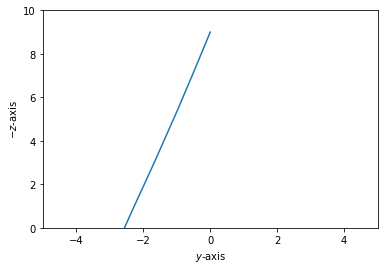

episode: 460/1000, score: -2892.7696206901905  Average over last 100 episode: -2484.74 



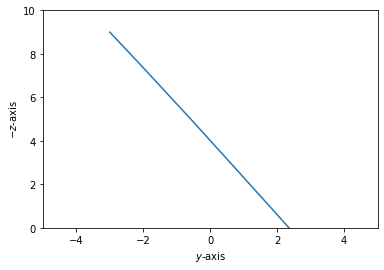

episode: 461/1000, score: -2826.263461192212  Average over last 100 episode: -2481.08 



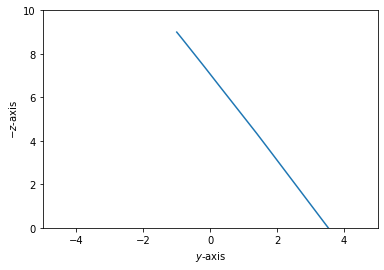

episode: 462/1000, score: -2401.1330255656726  Average over last 100 episode: -2472.82 



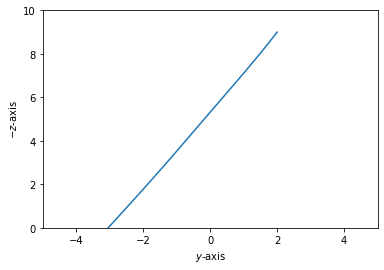

episode: 463/1000, score: -2839.2027981216124  Average over last 100 episode: -2465.93 



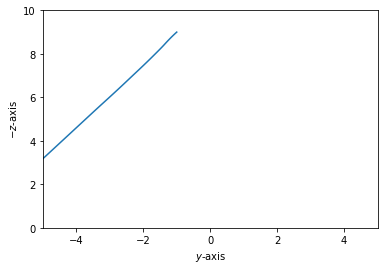

episode: 464/1000, score: -2344.995662285166  Average over last 100 episode: -2456.57 



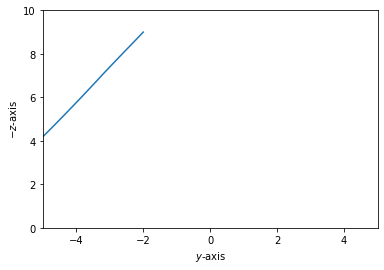

episode: 465/1000, score: -2362.8696255583236  Average over last 100 episode: -2457.09 



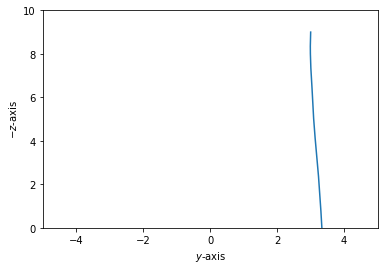

episode: 466/1000, score: -2056.6303039601453  Average over last 100 episode: -2450.17 



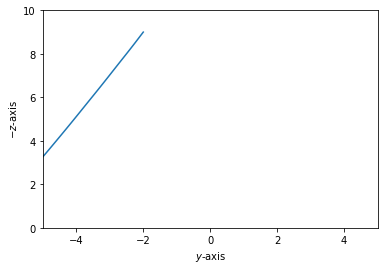

episode: 467/1000, score: -3185.673197852462  Average over last 100 episode: -2452.47 



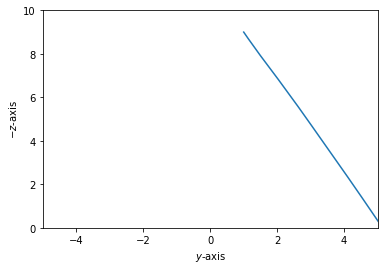

episode: 468/1000, score: -2955.205751469699  Average over last 100 episode: -2456.49 



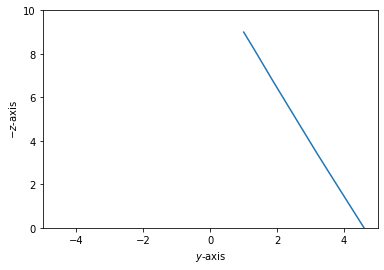

episode: 469/1000, score: -2254.088087563156  Average over last 100 episode: -2453.62 



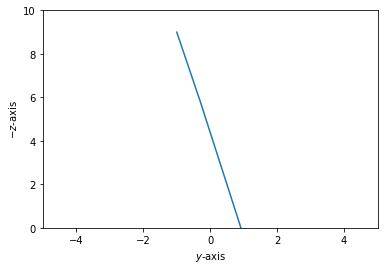

episode: 470/1000, score: -2750.636255633349  Average over last 100 episode: -2460.98 



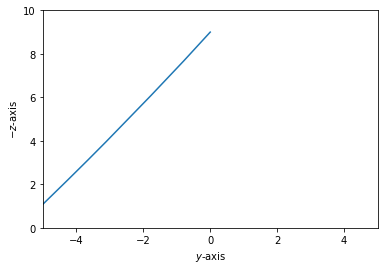

episode: 471/1000, score: -2174.0054345021576  Average over last 100 episode: -2461.78 



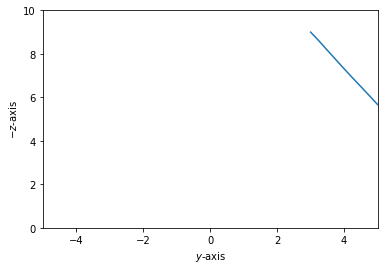

episode: 472/1000, score: -2081.1368794451564  Average over last 100 episode: -2451.14 



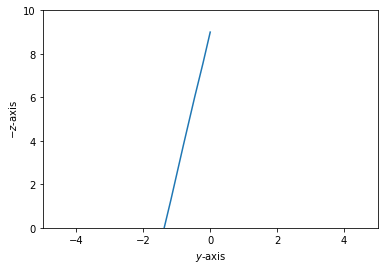

episode: 473/1000, score: -1737.9875203883835  Average over last 100 episode: -2448.05 



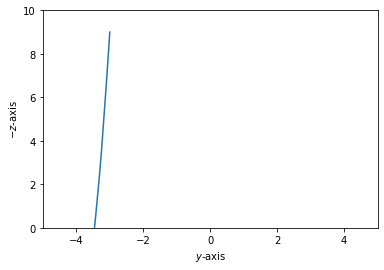

episode: 474/1000, score: -2278.35805912244  Average over last 100 episode: -2448.84 



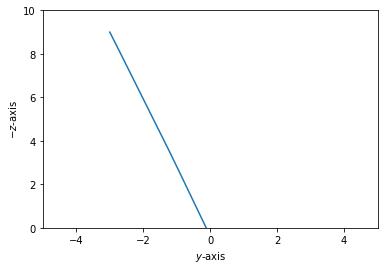

episode: 475/1000, score: -3404.7297867284665  Average over last 100 episode: -2465.53 



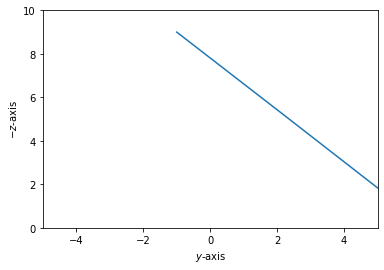

episode: 476/1000, score: -2824.7901932125637  Average over last 100 episode: -2472.77 



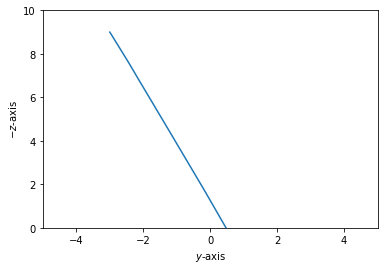

episode: 477/1000, score: -3001.9615418085286  Average over last 100 episode: -2471.06 



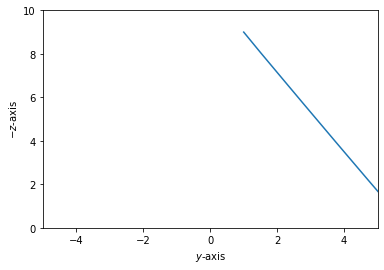

episode: 478/1000, score: -2271.418054144798  Average over last 100 episode: -2464.91 



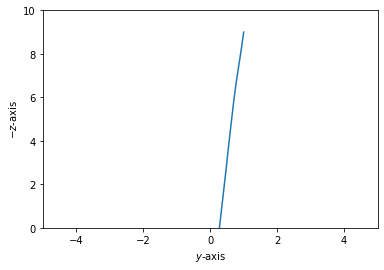

episode: 479/1000, score: -2287.960049832272  Average over last 100 episode: -2459.88 



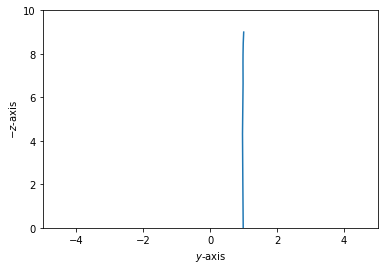

episode: 480/1000, score: -3474.8907879389567  Average over last 100 episode: -2472.32 



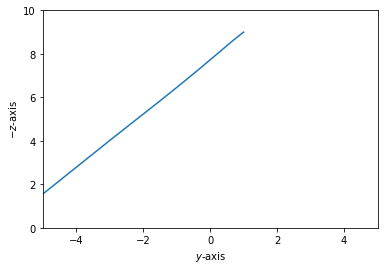

episode: 481/1000, score: -3261.6295183440398  Average over last 100 episode: -2472.92 



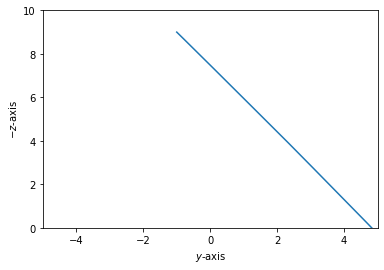

episode: 482/1000, score: -3003.971330344352  Average over last 100 episode: -2464.53 



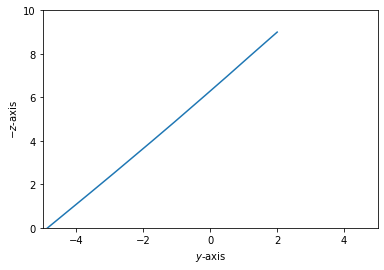

episode: 483/1000, score: -2786.699642871164  Average over last 100 episode: -2471.45 



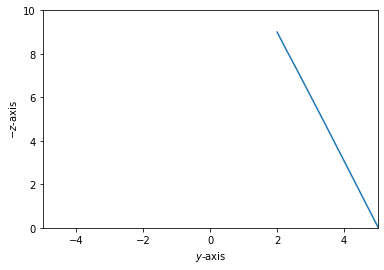

episode: 484/1000, score: -2502.643652122828  Average over last 100 episode: -2460.39 



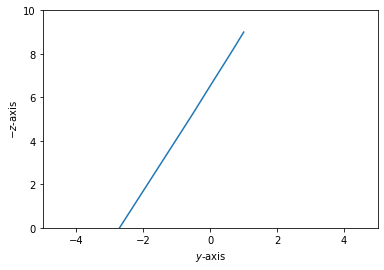

episode: 485/1000, score: -2139.3641358356895  Average over last 100 episode: -2451.44 



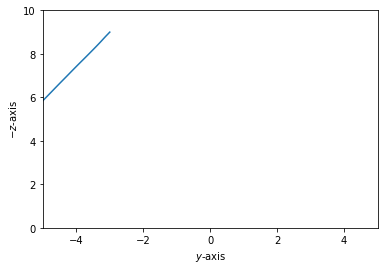

episode: 486/1000, score: -2302.387461410907  Average over last 100 episode: -2449.94 



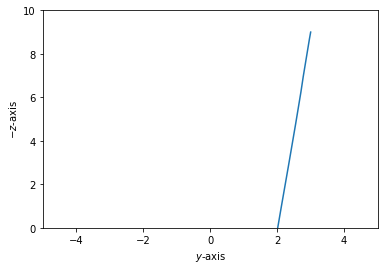

episode: 487/1000, score: -3174.6430798068027  Average over last 100 episode: -2460.51 



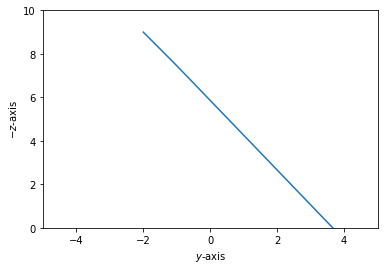

episode: 488/1000, score: -2111.5300046254506  Average over last 100 episode: -2458.41 



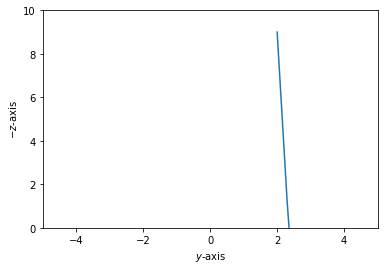

episode: 489/1000, score: -2323.971094749546  Average over last 100 episode: -2455.44 



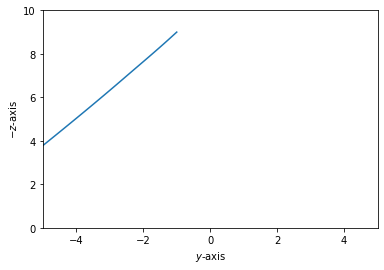

episode: 490/1000, score: -2103.633989839041  Average over last 100 episode: -2454.17 



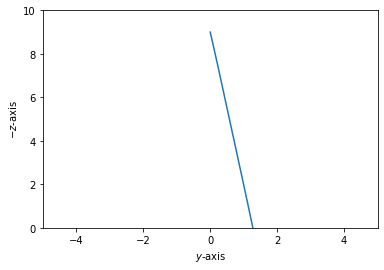

episode: 491/1000, score: -2663.621726139843  Average over last 100 episode: -2453.47 



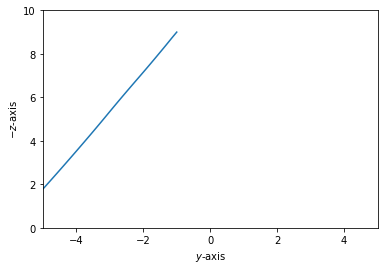

episode: 492/1000, score: -2161.7388441487783  Average over last 100 episode: -2447.26 



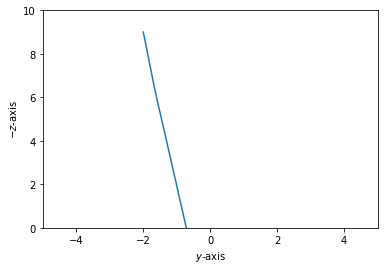

episode: 493/1000, score: -3139.0847793930348  Average over last 100 episode: -2458.51 



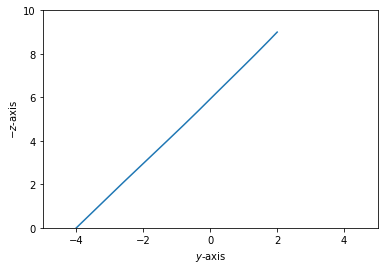

episode: 494/1000, score: -1932.810255353294  Average over last 100 episode: -2451.98 



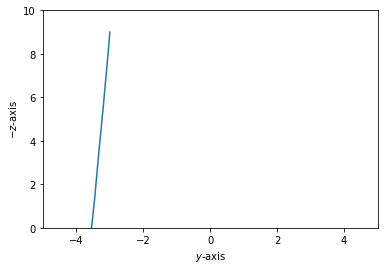

episode: 495/1000, score: -2181.9925311010943  Average over last 100 episode: -2451.39 



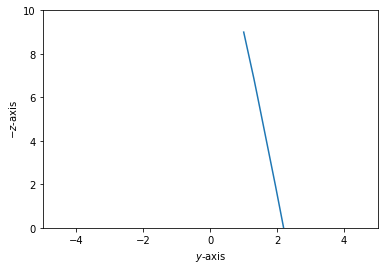

episode: 496/1000, score: -3099.650299244984  Average over last 100 episode: -2462.36 



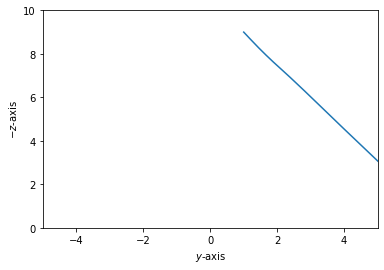

episode: 497/1000, score: -3070.861633372794  Average over last 100 episode: -2470.48 



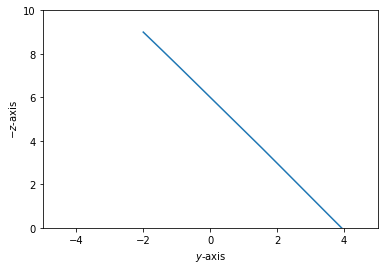

episode: 498/1000, score: -2659.536918317579  Average over last 100 episode: -2475.91 



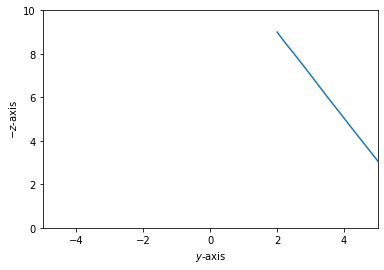

episode: 499/1000, score: -2290.0890794506527  Average over last 100 episode: -2471.53 



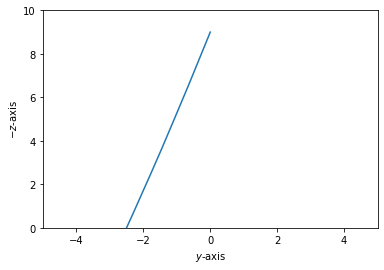

episode: 500/1000, score: -3494.222646500286  Average over last 100 episode: -2482.93 



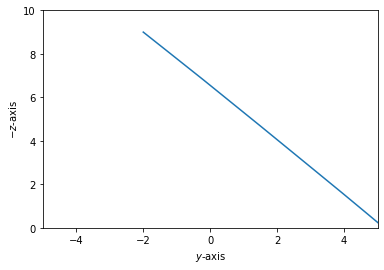

episode: 501/1000, score: -2259.811475880434  Average over last 100 episode: -2470.19 



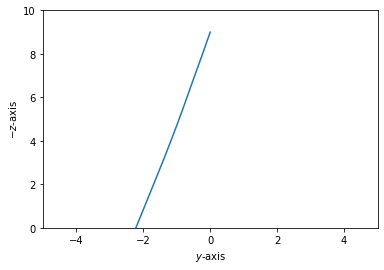

episode: 502/1000, score: -2339.7820475880662  Average over last 100 episode: -2469.10 



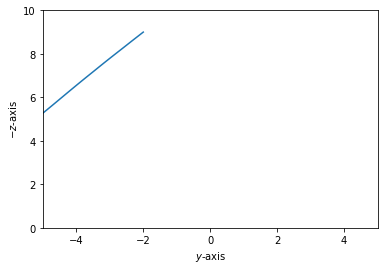

episode: 503/1000, score: -2057.4689621608536  Average over last 100 episode: -2470.44 



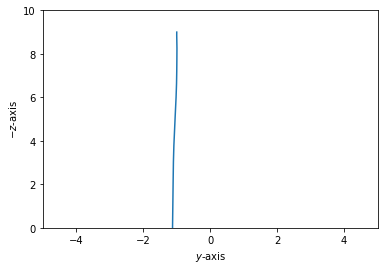

episode: 504/1000, score: -2522.061028274507  Average over last 100 episode: -2476.06 



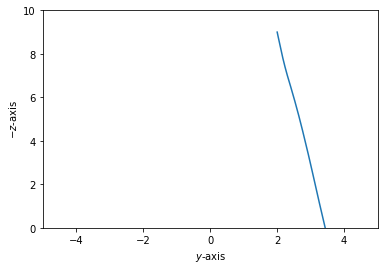

episode: 505/1000, score: -2248.1738462249245  Average over last 100 episode: -2466.48 



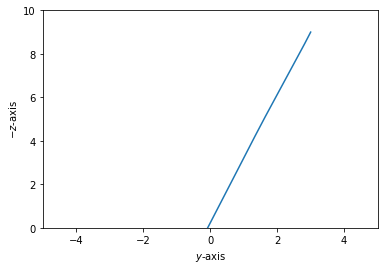

episode: 506/1000, score: -2446.8965762675016  Average over last 100 episode: -2469.04 



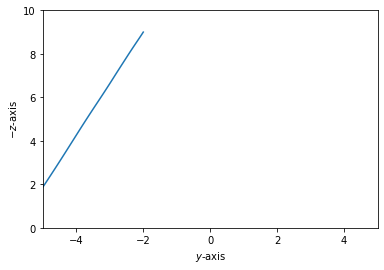

episode: 507/1000, score: -3221.7017013306818  Average over last 100 episode: -2484.02 



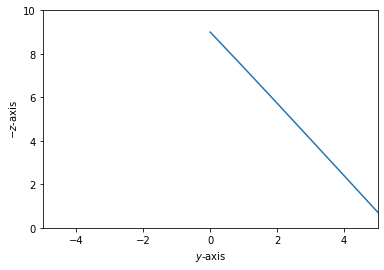

episode: 508/1000, score: -2098.8824429018396  Average over last 100 episode: -2479.17 



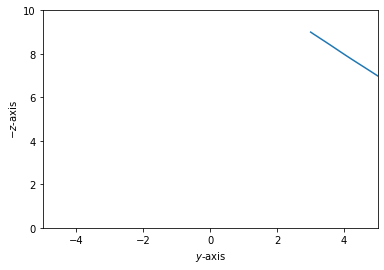

episode: 509/1000, score: -3327.2864040322766  Average over last 100 episode: -2488.58 



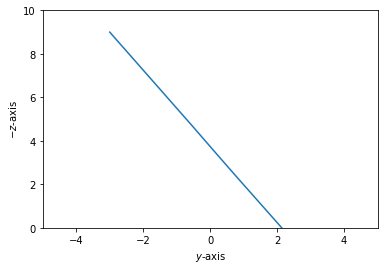

episode: 510/1000, score: -2291.75376979997  Average over last 100 episode: -2486.62 



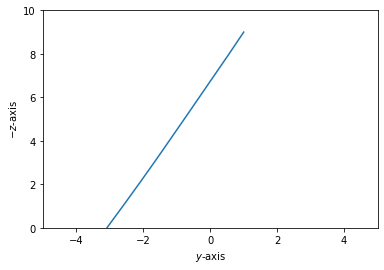

episode: 511/1000, score: -2171.5439577219595  Average over last 100 episode: -2480.84 



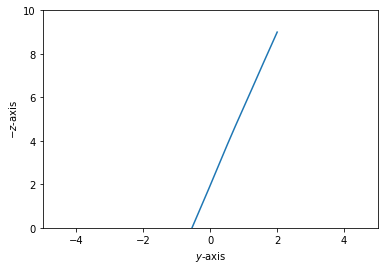

episode: 512/1000, score: -2577.412259521153  Average over last 100 episode: -2481.95 



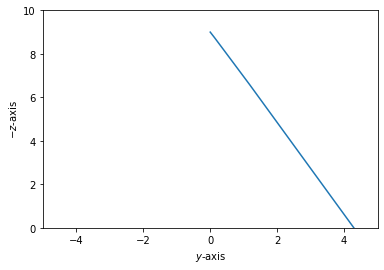

episode: 513/1000, score: -2289.9695171936196  Average over last 100 episode: -2472.65 



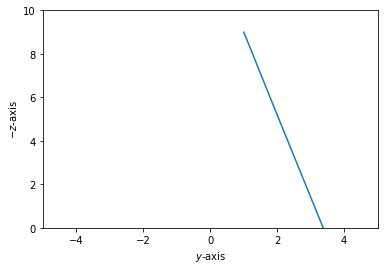

episode: 514/1000, score: -1951.1462629735588  Average over last 100 episode: -2459.96 



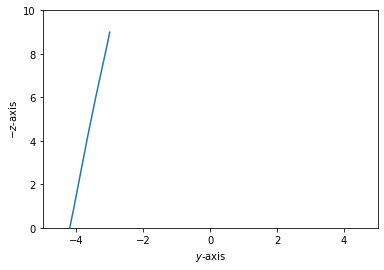

episode: 515/1000, score: -2065.8140373068372  Average over last 100 episode: -2457.63 



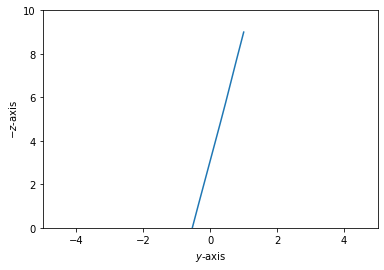

episode: 516/1000, score: -2646.4546928406803  Average over last 100 episode: -2464.97 



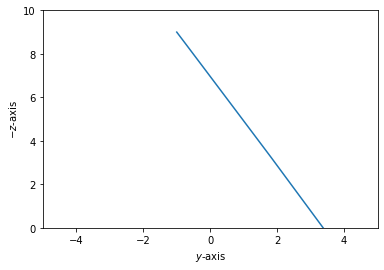

episode: 517/1000, score: -2176.0888548816793  Average over last 100 episode: -2465.31 



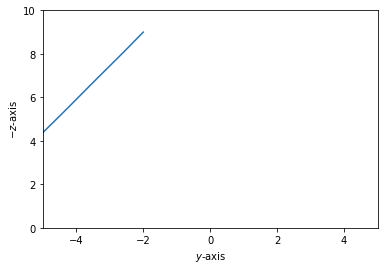

episode: 518/1000, score: -2057.941117186151  Average over last 100 episode: -2465.97 



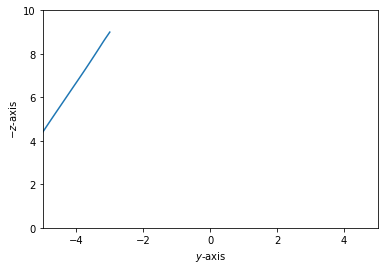

episode: 519/1000, score: -3171.850842395144  Average over last 100 episode: -2471.41 



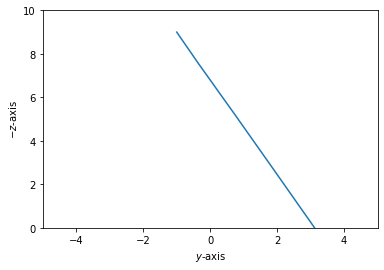

episode: 520/1000, score: -2483.290282876394  Average over last 100 episode: -2472.28 



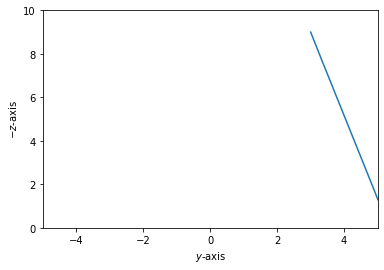

episode: 521/1000, score: -2416.7387034620438  Average over last 100 episode: -2471.59 



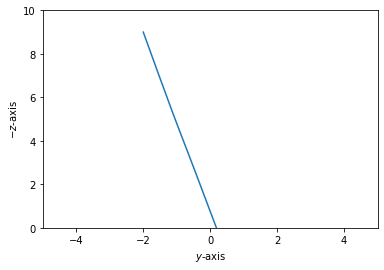

episode: 522/1000, score: -1920.2873380656547  Average over last 100 episode: -2465.98 



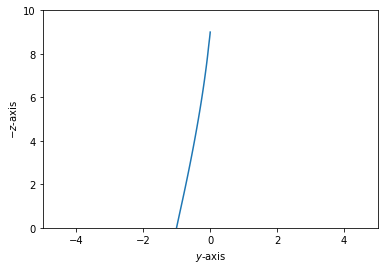

episode: 523/1000, score: -2695.4172316820795  Average over last 100 episode: -2468.29 



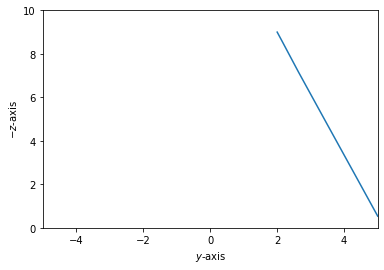

episode: 524/1000, score: -2847.144714384424  Average over last 100 episode: -2470.82 



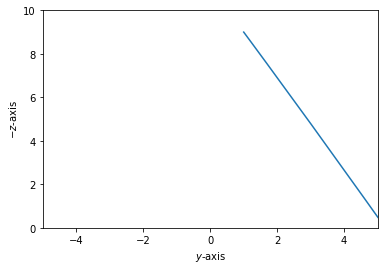

episode: 525/1000, score: -2433.376449499099  Average over last 100 episode: -2474.43 



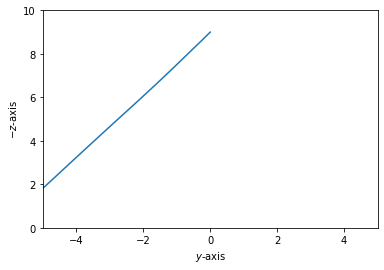

episode: 526/1000, score: -2211.3050901124175  Average over last 100 episode: -2464.83 



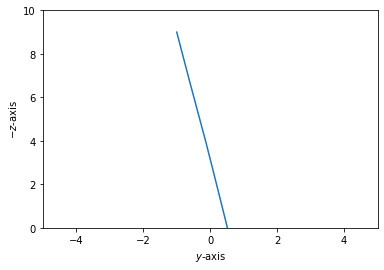

episode: 527/1000, score: -2764.750733882233  Average over last 100 episode: -2467.28 



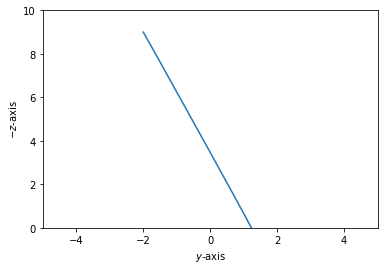

episode: 528/1000, score: -1861.8094784431316  Average over last 100 episode: -2460.04 



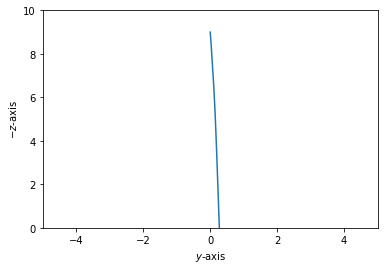

episode: 529/1000, score: -2841.3478117291534  Average over last 100 episode: -2456.67 



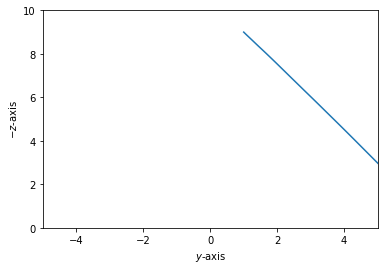

episode: 530/1000, score: -3309.239188859466  Average over last 100 episode: -2466.69 



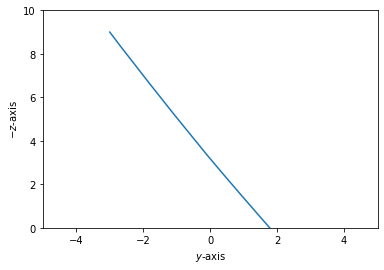

episode: 531/1000, score: -2303.8279390387843  Average over last 100 episode: -2463.28 



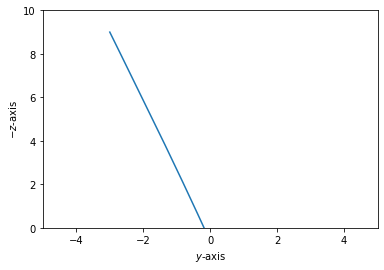

episode: 532/1000, score: -2904.1180713500953  Average over last 100 episode: -2465.68 



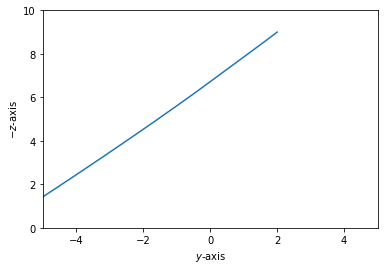

episode: 533/1000, score: -2784.890826058936  Average over last 100 episode: -2467.17 



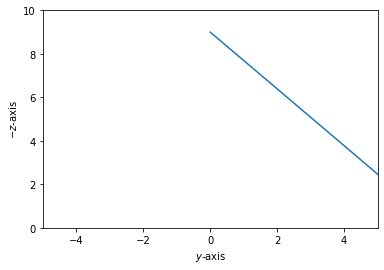

episode: 534/1000, score: -2090.370989931016  Average over last 100 episode: -2468.85 



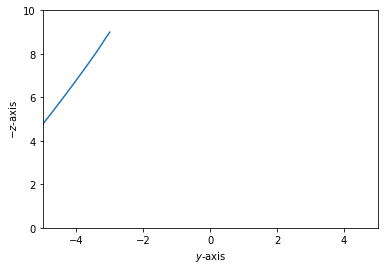

episode: 535/1000, score: -3215.6038340868813  Average over last 100 episode: -2479.18 



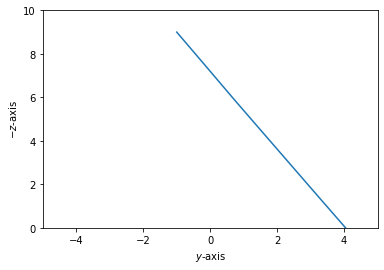

episode: 536/1000, score: -3129.968415378063  Average over last 100 episode: -2492.34 



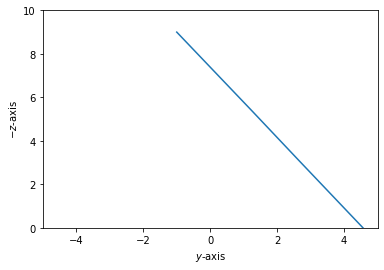

episode: 537/1000, score: -2259.923398531371  Average over last 100 episode: -2494.39 



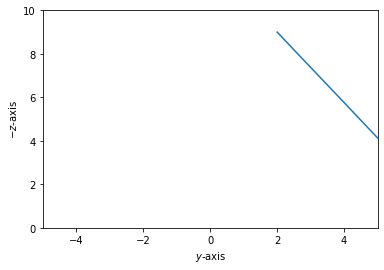

episode: 538/1000, score: -1837.5121197319233  Average over last 100 episode: -2489.00 



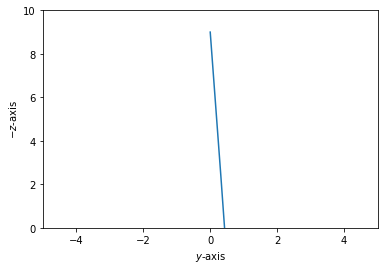

episode: 539/1000, score: -2378.103936974825  Average over last 100 episode: -2488.89 



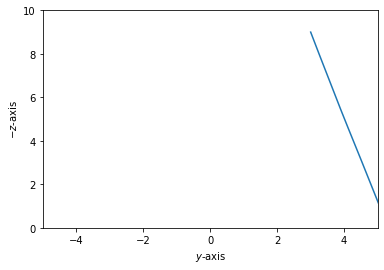

episode: 540/1000, score: -3515.110381717326  Average over last 100 episode: -2501.13 



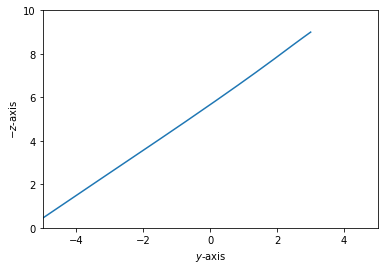

episode: 541/1000, score: -2024.6886229899878  Average over last 100 episode: -2502.13 



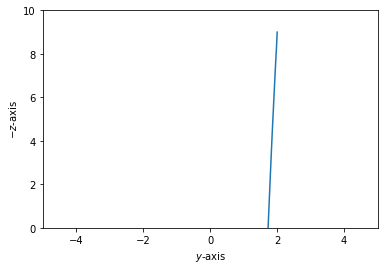

episode: 542/1000, score: -2247.068315181835  Average over last 100 episode: -2502.00 



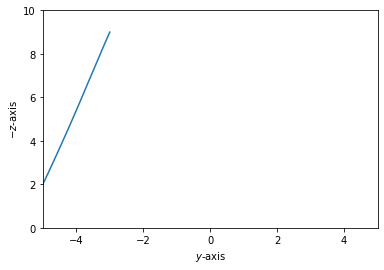

episode: 543/1000, score: -3274.085862017325  Average over last 100 episode: -2513.59 



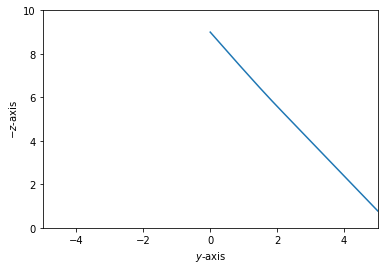

episode: 544/1000, score: -2701.394211457799  Average over last 100 episode: -2512.88 



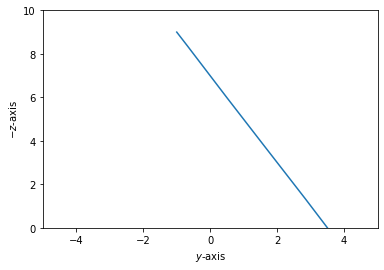

episode: 545/1000, score: -2642.83034943632  Average over last 100 episode: -2520.38 



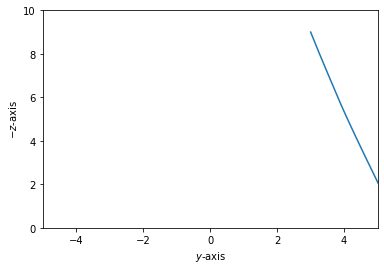

episode: 546/1000, score: -3166.88727515579  Average over last 100 episode: -2529.57 



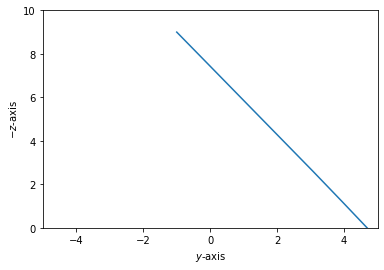

episode: 547/1000, score: -3153.8193707613364  Average over last 100 episode: -2533.53 



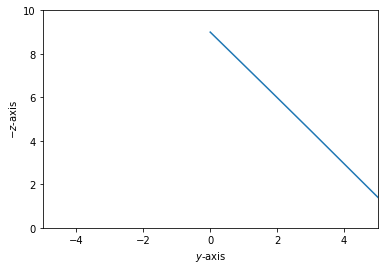

episode: 548/1000, score: -1838.6310026873448  Average over last 100 episode: -2531.70 



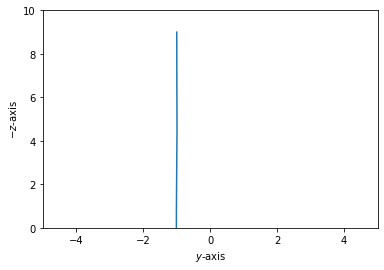

episode: 549/1000, score: -2304.7348136937767  Average over last 100 episode: -2524.97 



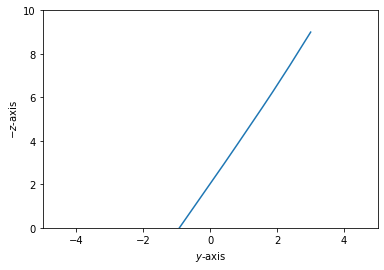

episode: 550/1000, score: -3118.46211687808  Average over last 100 episode: -2535.91 



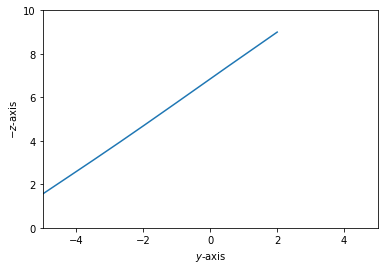

episode: 551/1000, score: -2502.0589773495476  Average over last 100 episode: -2542.33 



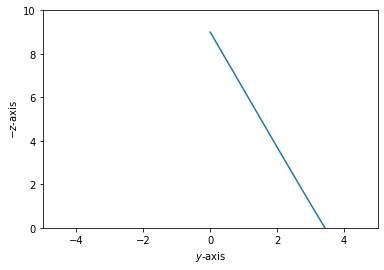

episode: 552/1000, score: -2080.9831086530166  Average over last 100 episode: -2541.57 



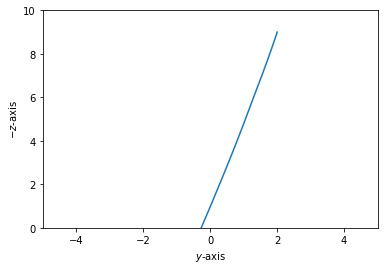

episode: 553/1000, score: -3188.41394282457  Average over last 100 episode: -2554.66 



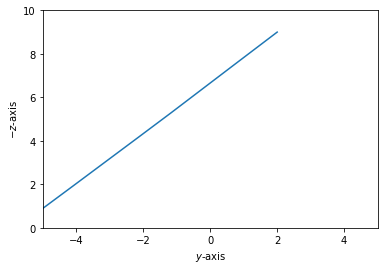

episode: 554/1000, score: -2437.204719984804  Average over last 100 episode: -2543.39 



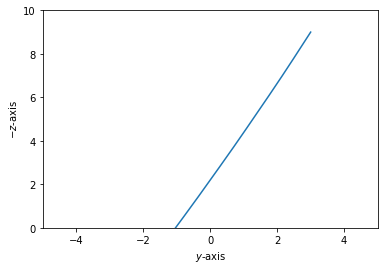

episode: 555/1000, score: -2198.1016139159597  Average over last 100 episode: -2546.64 



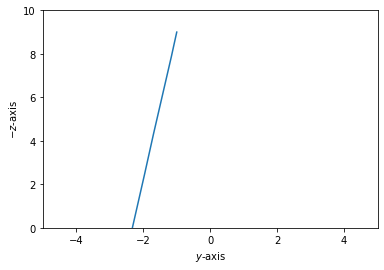

episode: 556/1000, score: -2193.1117606271  Average over last 100 episode: -2548.35 



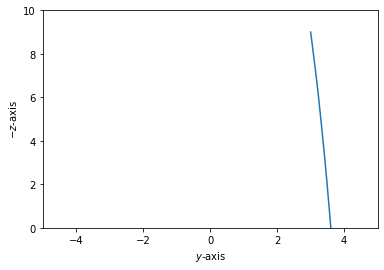

episode: 557/1000, score: -2455.1835175336446  Average over last 100 episode: -2551.79 



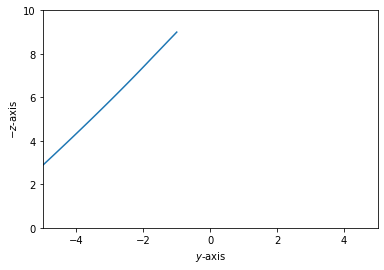

episode: 558/1000, score: -2784.1014229545017  Average over last 100 episode: -2554.74 



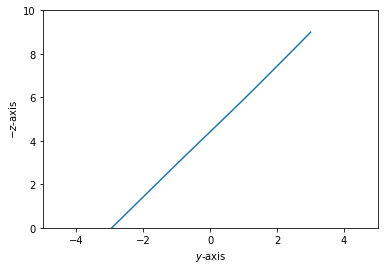

episode: 559/1000, score: -2543.1863380391446  Average over last 100 episode: -2557.92 



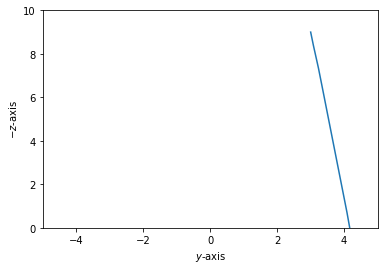

episode: 560/1000, score: -2833.830837523549  Average over last 100 episode: -2557.33 



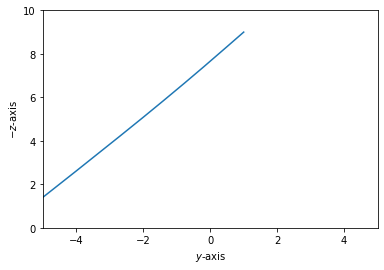

episode: 561/1000, score: -2672.326154829941  Average over last 100 episode: -2555.79 



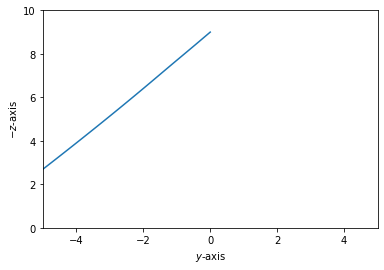

episode: 562/1000, score: -2528.6695408859337  Average over last 100 episode: -2557.07 



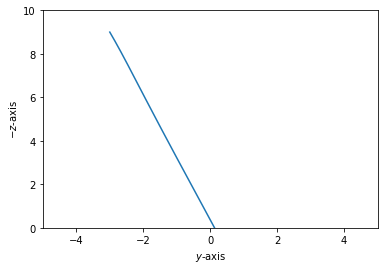

episode: 563/1000, score: -2074.0264566072346  Average over last 100 episode: -2549.41 



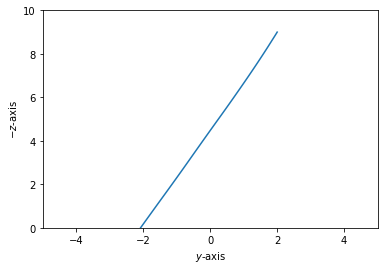

episode: 564/1000, score: -2297.978412493902  Average over last 100 episode: -2548.94 



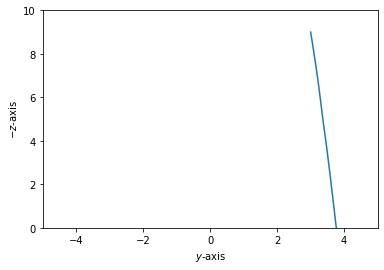

episode: 565/1000, score: -2177.2972569945823  Average over last 100 episode: -2547.09 



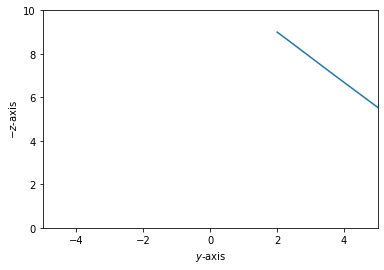

episode: 566/1000, score: -3301.407713204223  Average over last 100 episode: -2559.54 



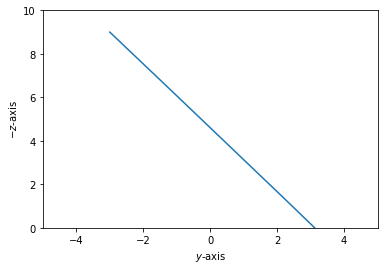

episode: 567/1000, score: -2880.975339213177  Average over last 100 episode: -2556.49 



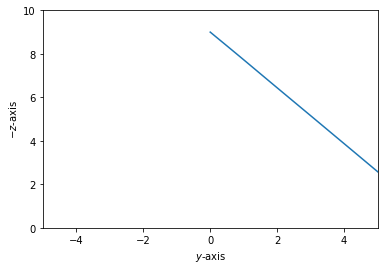

episode: 568/1000, score: -2025.1587752695132  Average over last 100 episode: -2547.19 



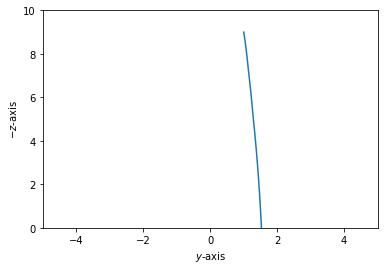

episode: 569/1000, score: -2021.236340023515  Average over last 100 episode: -2544.86 



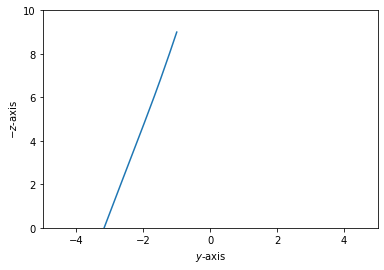

episode: 570/1000, score: -1768.7520575057608  Average over last 100 episode: -2535.04 



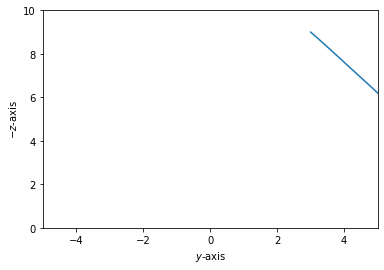

episode: 571/1000, score: -1946.8876710864697  Average over last 100 episode: -2532.77 



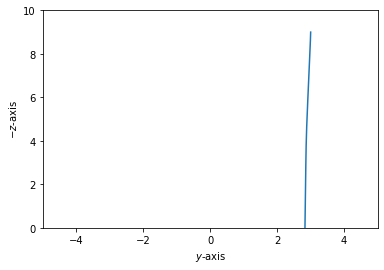

episode: 572/1000, score: -2026.7763597068058  Average over last 100 episode: -2532.23 



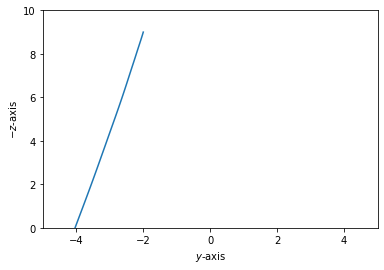

episode: 573/1000, score: -2078.399708252514  Average over last 100 episode: -2535.63 



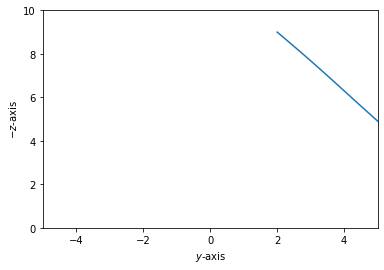

episode: 574/1000, score: -1829.8893900838916  Average over last 100 episode: -2531.15 



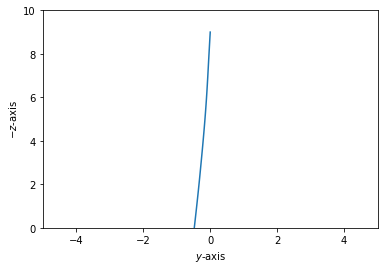

episode: 575/1000, score: -2366.273026700491  Average over last 100 episode: -2520.76 



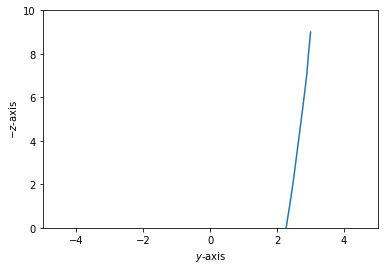

episode: 576/1000, score: -2646.553513048984  Average over last 100 episode: -2518.98 



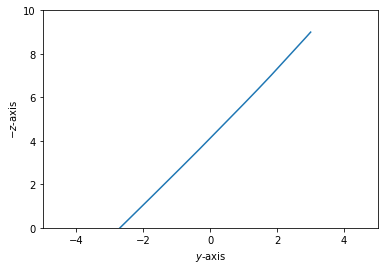

episode: 577/1000, score: -3602.7389926965307  Average over last 100 episode: -2524.99 



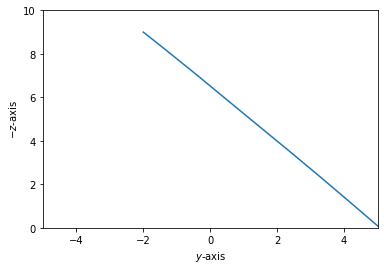

episode: 578/1000, score: -2143.6908665152982  Average over last 100 episode: -2523.71 



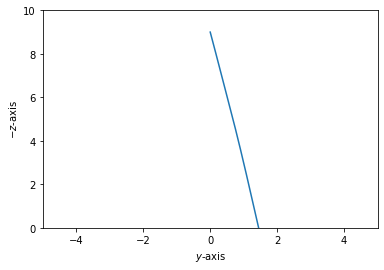

episode: 579/1000, score: -3164.0295441099993  Average over last 100 episode: -2532.47 



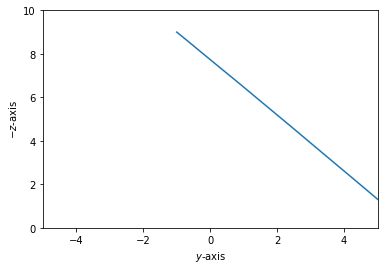

episode: 580/1000, score: -2691.719534197237  Average over last 100 episode: -2524.64 



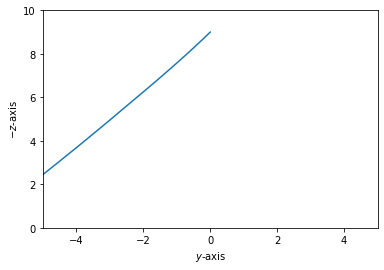

episode: 581/1000, score: -2066.4467644254837  Average over last 100 episode: -2512.69 



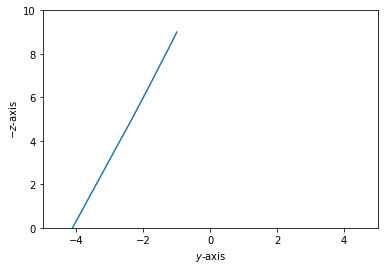

episode: 582/1000, score: -1906.9431274952883  Average over last 100 episode: -2501.72 



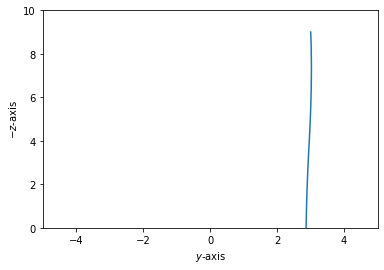

episode: 583/1000, score: -2017.4918003322964  Average over last 100 episode: -2494.02 



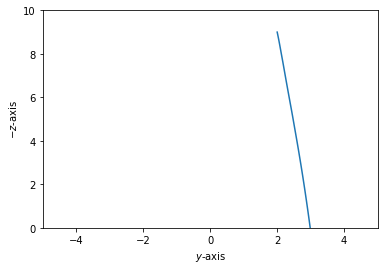

episode: 584/1000, score: -2107.1821680760017  Average over last 100 episode: -2490.07 



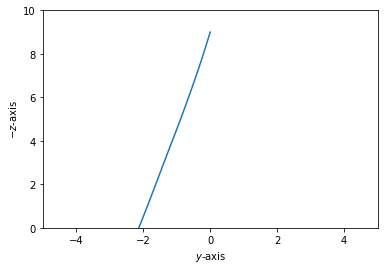

episode: 585/1000, score: -1898.1123221713387  Average over last 100 episode: -2487.66 



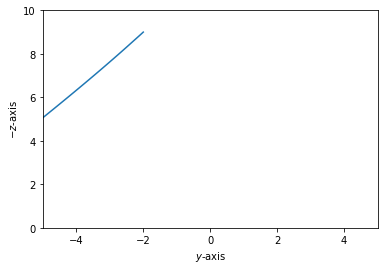

episode: 586/1000, score: -1925.4809818975612  Average over last 100 episode: -2483.89 



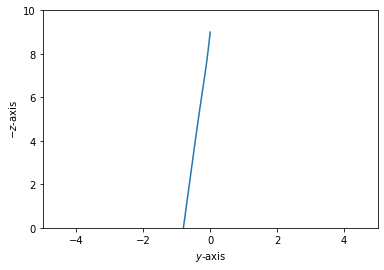

episode: 587/1000, score: -2029.9652442357697  Average over last 100 episode: -2472.44 



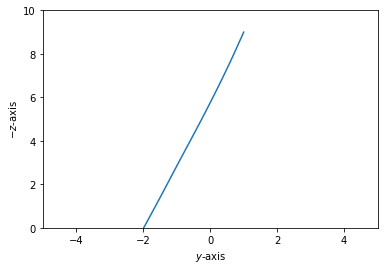

episode: 588/1000, score: -3562.6531227556334  Average over last 100 episode: -2486.95 



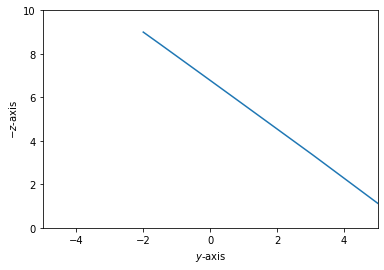

episode: 589/1000, score: -2811.4855201626383  Average over last 100 episode: -2491.83 



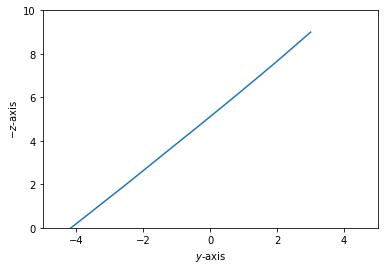

episode: 590/1000, score: -2703.656561547613  Average over last 100 episode: -2497.83 



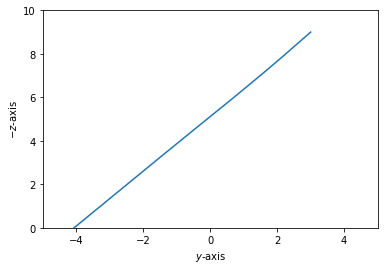

episode: 591/1000, score: -2423.7934487454468  Average over last 100 episode: -2495.43 



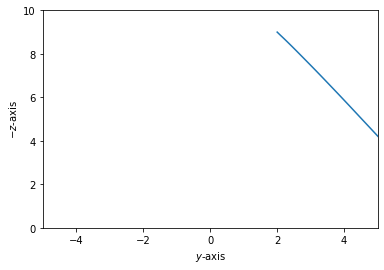

episode: 592/1000, score: -1783.4406626437758  Average over last 100 episode: -2491.65 



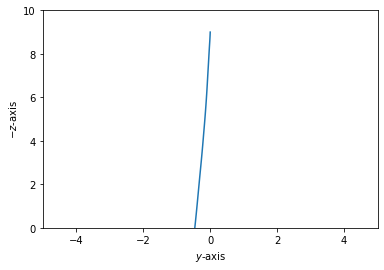

episode: 593/1000, score: -2624.696427691485  Average over last 100 episode: -2486.50 



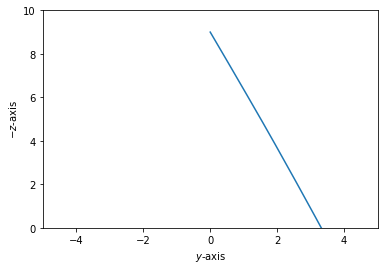

episode: 594/1000, score: -1856.2644542633816  Average over last 100 episode: -2485.74 



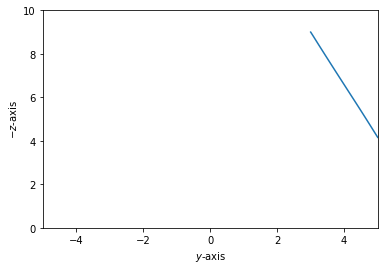

episode: 595/1000, score: -2275.1430275123043  Average over last 100 episode: -2486.67 



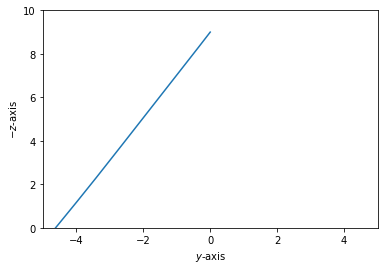

episode: 596/1000, score: -1592.6260618353806  Average over last 100 episode: -2471.60 



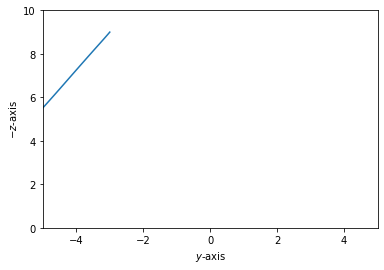

episode: 597/1000, score: -1778.5293032502932  Average over last 100 episode: -2458.68 



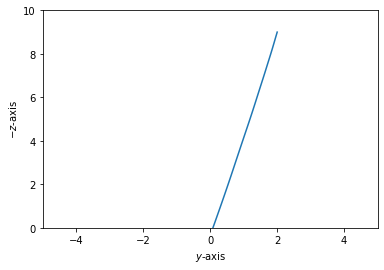

episode: 598/1000, score: -2626.8401583239056  Average over last 100 episode: -2458.35 



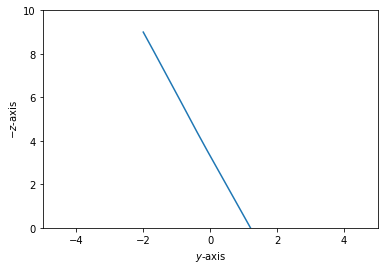

episode: 599/1000, score: -2650.629922405872  Average over last 100 episode: -2461.95 



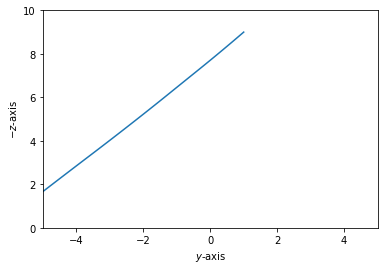

episode: 600/1000, score: -2949.207938094974  Average over last 100 episode: -2456.50 



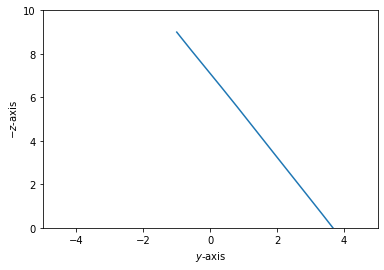

episode: 601/1000, score: -2793.1351532821996  Average over last 100 episode: -2461.84 



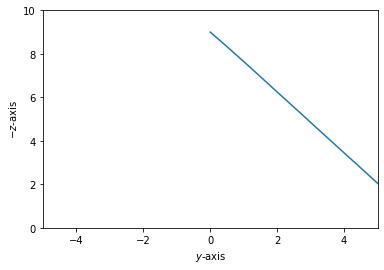

episode: 602/1000, score: -3158.9730468842563  Average over last 100 episode: -2470.03 



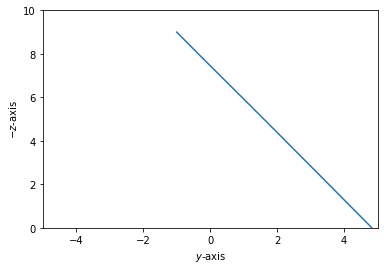

episode: 603/1000, score: -2368.5906810493075  Average over last 100 episode: -2473.14 



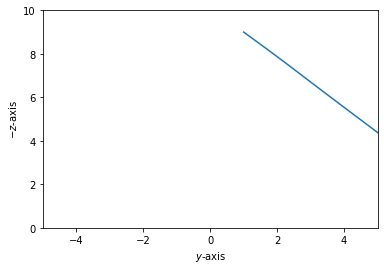

episode: 604/1000, score: -1952.223644626546  Average over last 100 episode: -2467.44 



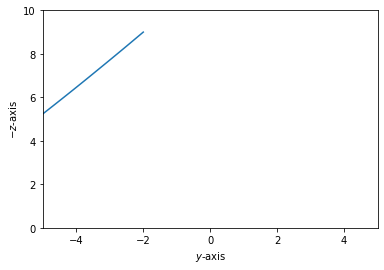

episode: 605/1000, score: -2214.340720596414  Average over last 100 episode: -2467.10 



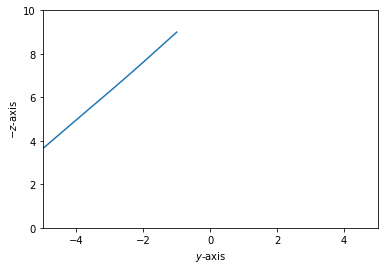

episode: 606/1000, score: -2886.3970326386193  Average over last 100 episode: -2471.50 



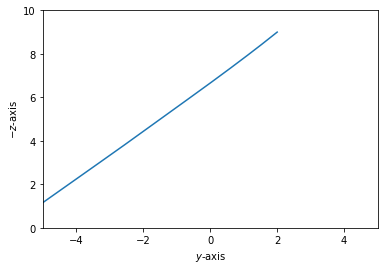

episode: 607/1000, score: -1645.475819868401  Average over last 100 episode: -2455.74 



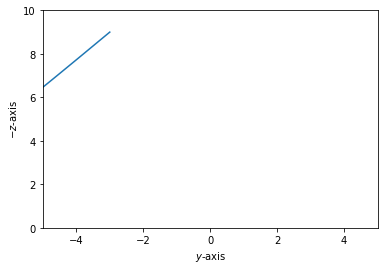

episode: 608/1000, score: -2750.520091065578  Average over last 100 episode: -2462.25 



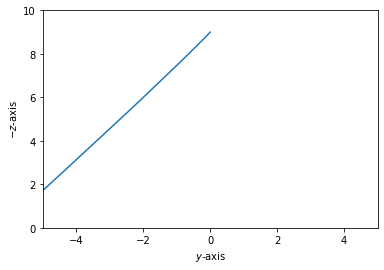

episode: 609/1000, score: -2723.521565126879  Average over last 100 episode: -2456.21 



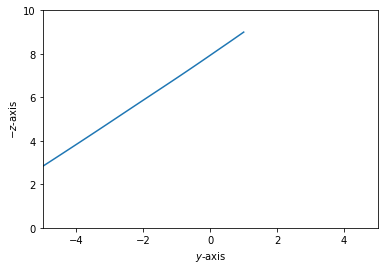

episode: 610/1000, score: -2193.141486815566  Average over last 100 episode: -2455.23 



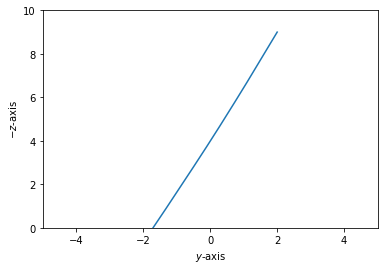

episode: 611/1000, score: -2491.119085096538  Average over last 100 episode: -2458.42 



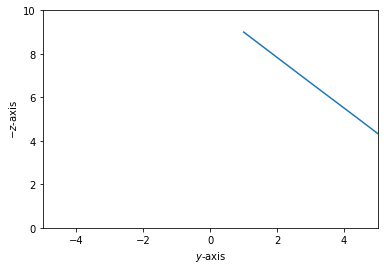

episode: 612/1000, score: -3301.992912639696  Average over last 100 episode: -2465.67 



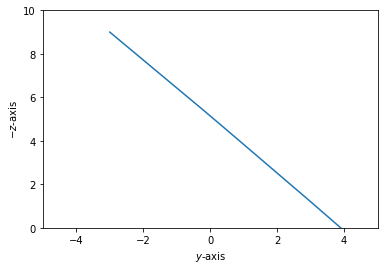

episode: 613/1000, score: -1665.696716269078  Average over last 100 episode: -2459.43 



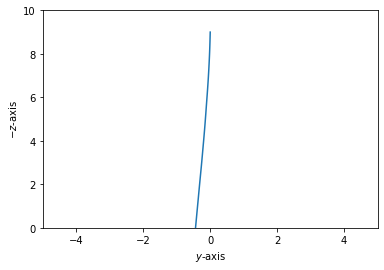

episode: 614/1000, score: -1804.92231951667  Average over last 100 episode: -2457.96 



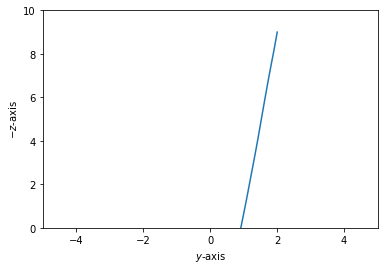

episode: 615/1000, score: -1868.2973778133955  Average over last 100 episode: -2455.99 



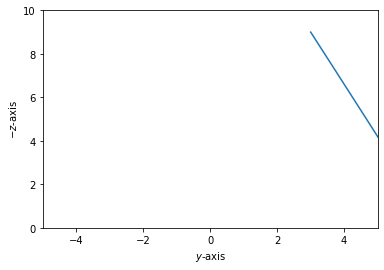

episode: 616/1000, score: -2481.794833462561  Average over last 100 episode: -2454.34 



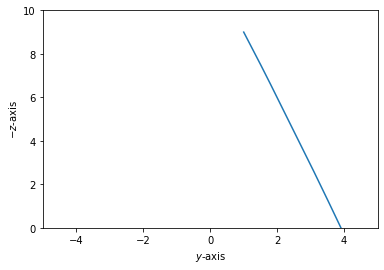

episode: 617/1000, score: -2241.009519296612  Average over last 100 episode: -2454.99 



episode: 618/1000, score: -2061.1438040480625  Average over last 100 episode: -2455.02 



episode: 619/1000, score: -2083.729948469716  Average over last 100 episode: -2444.14 



episode: 620/1000, score: -2386.2537832488833  Average over last 100 episode: -2443.17 



episode: 621/1000, score: -2124.3290890197277  Average over last 100 episode: -2440.25 



episode: 622/1000, score: -2733.8497093442875  Average over last 100 episode: -2448.38 



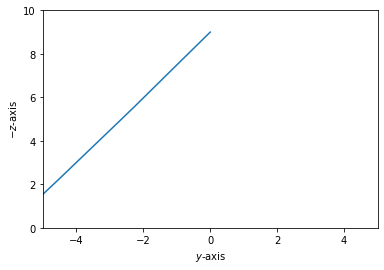

episode: 623/1000, score: -2144.71091657671  Average over last 100 episode: -2442.88 



episode: 624/1000, score: -2114.334569016271  Average over last 100 episode: -2435.55 



episode: 625/1000, score: -2099.476686248952  Average over last 100 episode: -2432.21 



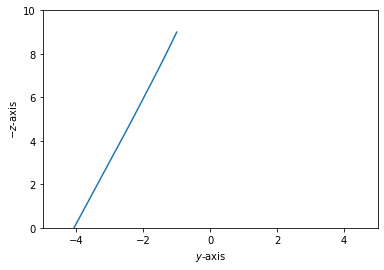

episode: 626/1000, score: -2409.115719666292  Average over last 100 episode: -2434.19 



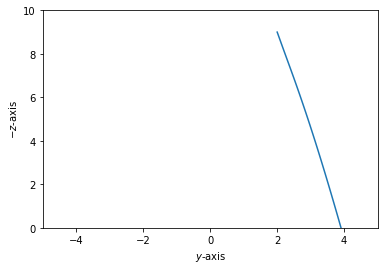

episode: 627/1000, score: -2138.597674889771  Average over last 100 episode: -2427.93 



episode: 628/1000, score: -2864.901392057191  Average over last 100 episode: -2437.96 



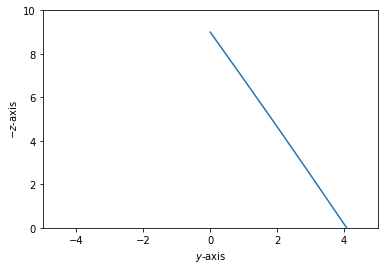

episode: 629/1000, score: -3564.232099213661  Average over last 100 episode: -2445.19 



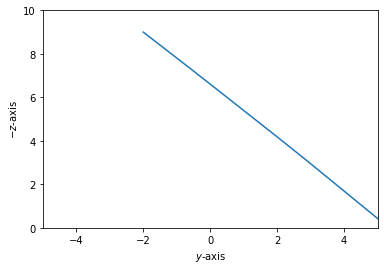

episode: 630/1000, score: -2753.965706893974  Average over last 100 episode: -2439.63 



episode: 631/1000, score: -1902.2757106937086  Average over last 100 episode: -2435.62 



episode: 632/1000, score: -2460.06499102616  Average over last 100 episode: -2431.18 



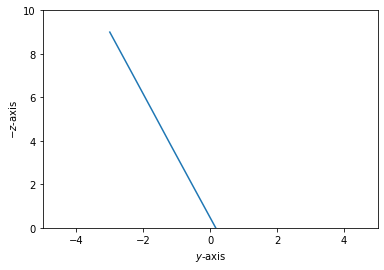

episode: 633/1000, score: -2795.530273926115  Average over last 100 episode: -2431.28 



episode: 634/1000, score: -2799.415835847047  Average over last 100 episode: -2438.37 



episode: 635/1000, score: -3362.496790875337  Average over last 100 episode: -2439.84 



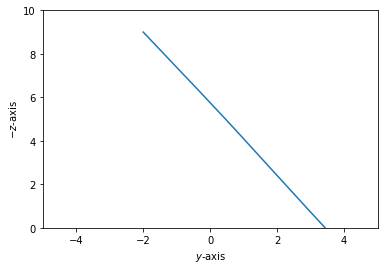

episode: 636/1000, score: -2087.9308675502343  Average over last 100 episode: -2429.42 



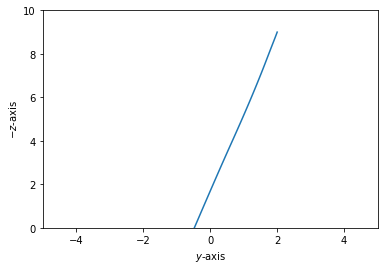

episode: 637/1000, score: -1724.228830982025  Average over last 100 episode: -2424.07 



episode: 638/1000, score: -2034.5047497190842  Average over last 100 episode: -2426.04 



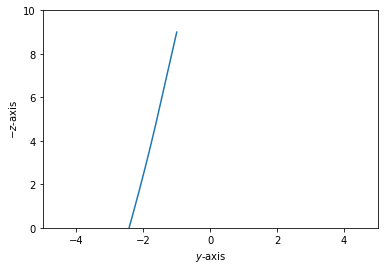

episode: 639/1000, score: -2880.58272450045  Average over last 100 episode: -2431.06 



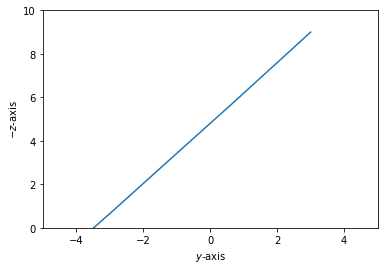

episode: 640/1000, score: -2236.6418823551235  Average over last 100 episode: -2418.28 



episode: 641/1000, score: -1881.4789994825135  Average over last 100 episode: -2416.84 



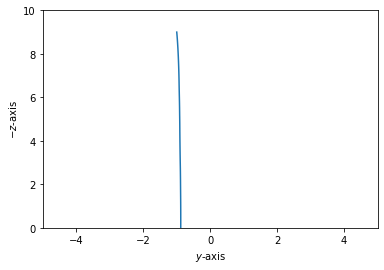

episode: 642/1000, score: -2097.655026451384  Average over last 100 episode: -2415.35 



episode: 643/1000, score: -1606.4199433857707  Average over last 100 episode: -2398.67 



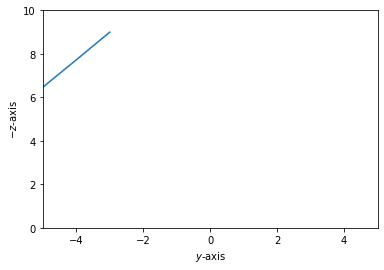

episode: 644/1000, score: -2744.8537789387124  Average over last 100 episode: -2399.11 



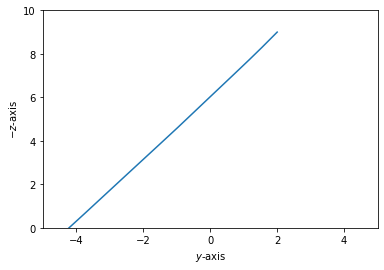

episode: 645/1000, score: -2447.3833467591235  Average over last 100 episode: -2397.15 



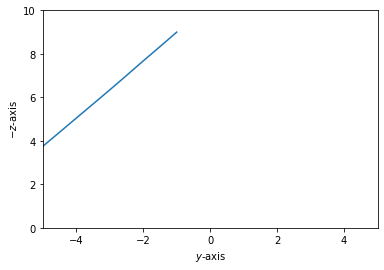

episode: 646/1000, score: -2473.9464882647194  Average over last 100 episode: -2390.22 



episode: 647/1000, score: -2736.6949275854586  Average over last 100 episode: -2386.05 



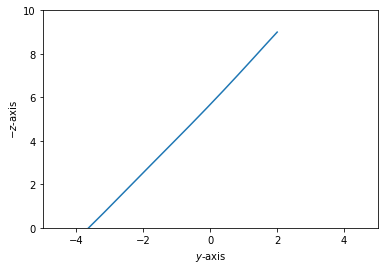

episode: 648/1000, score: -2379.578454019653  Average over last 100 episode: -2391.46 



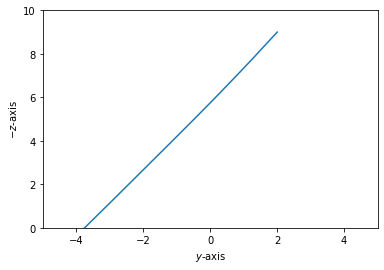

episode: 649/1000, score: -2354.197298139207  Average over last 100 episode: -2391.96 



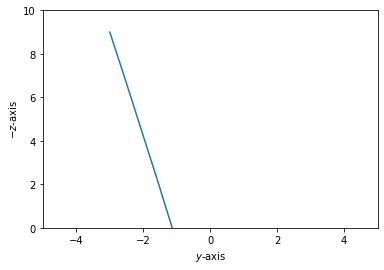

episode: 650/1000, score: -2594.9921914573556  Average over last 100 episode: -2386.72 



episode: 651/1000, score: -1822.5407775197598  Average over last 100 episode: -2379.93 



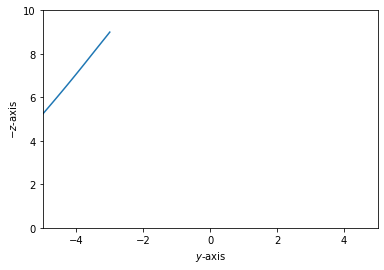

episode: 652/1000, score: -1995.5566534979685  Average over last 100 episode: -2379.07 



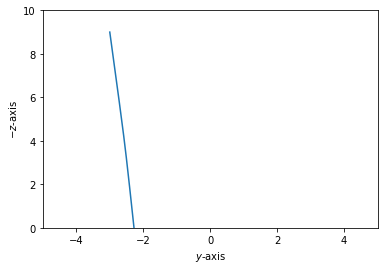

episode: 653/1000, score: -1680.688550898539  Average over last 100 episode: -2364.00 



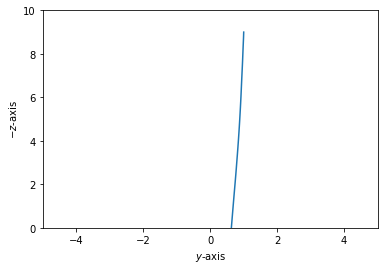

episode: 654/1000, score: -1852.4408602350013  Average over last 100 episode: -2358.15 



episode: 655/1000, score: -2304.0739695873876  Average over last 100 episode: -2359.21 



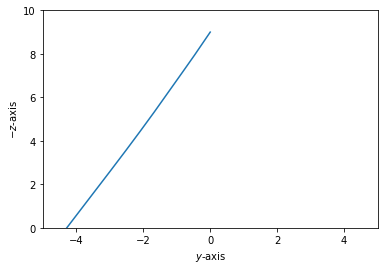

episode: 656/1000, score: -2282.5906956919944  Average over last 100 episode: -2360.10 



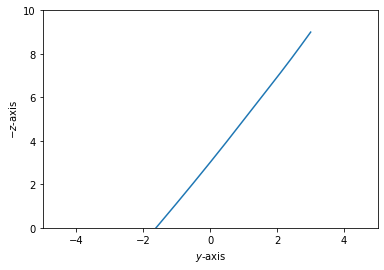

episode: 657/1000, score: -2681.5445503963415  Average over last 100 episode: -2362.37 



episode: 658/1000, score: -1773.1516706659127  Average over last 100 episode: -2352.26 



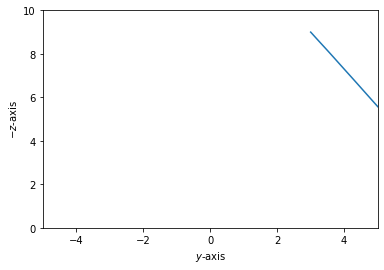

episode: 659/1000, score: -2009.0184328429318  Average over last 100 episode: -2346.91 



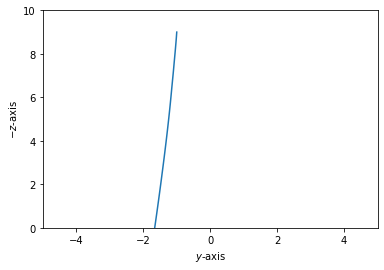

episode: 660/1000, score: -2058.3197583831757  Average over last 100 episode: -2339.16 



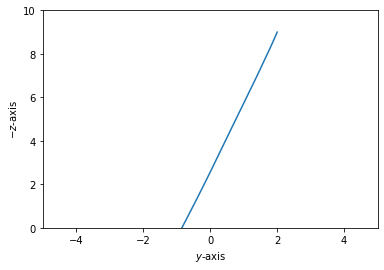

episode: 661/1000, score: -2545.896313888683  Average over last 100 episode: -2337.90 



episode: 662/1000, score: -2201.2721336459454  Average over last 100 episode: -2334.62 



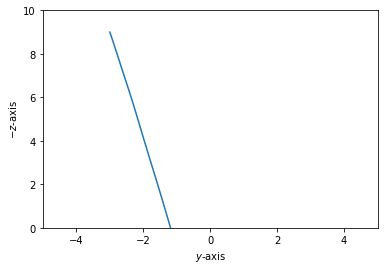

episode: 663/1000, score: -1827.4100277127504  Average over last 100 episode: -2332.16 



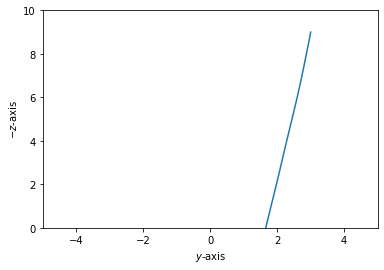

episode: 664/1000, score: -1955.2891870868323  Average over last 100 episode: -2328.73 



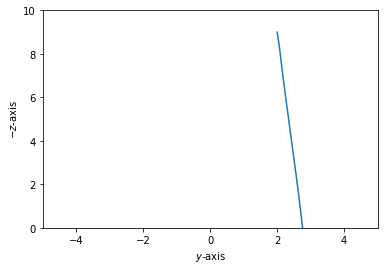

episode: 665/1000, score: -2566.200348699062  Average over last 100 episode: -2332.62 



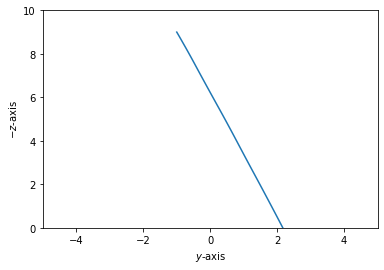

episode: 666/1000, score: -1766.7933473377805  Average over last 100 episode: -2317.27 



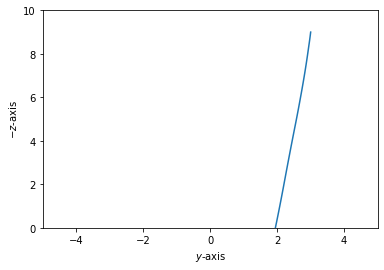

episode: 667/1000, score: -2483.061683068625  Average over last 100 episode: -2313.29 



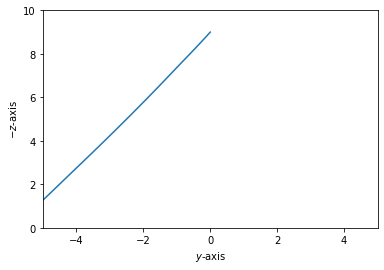

episode: 668/1000, score: -2069.8200616474155  Average over last 100 episode: -2313.74 



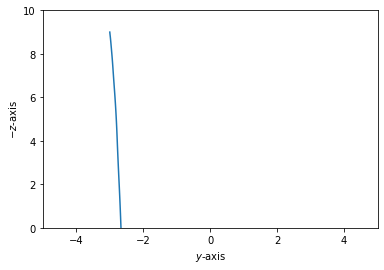

episode: 669/1000, score: -3108.668678140179  Average over last 100 episode: -2324.61 



episode: 670/1000, score: -2304.0710388636303  Average over last 100 episode: -2329.97 



episode: 671/1000, score: -2415.0953590628405  Average over last 100 episode: -2334.65 



episode: 672/1000, score: -2152.087413440422  Average over last 100 episode: -2335.90 



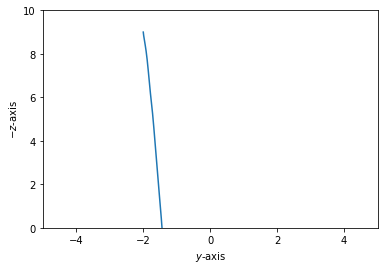

episode: 673/1000, score: -2885.9803161033033  Average over last 100 episode: -2343.98 



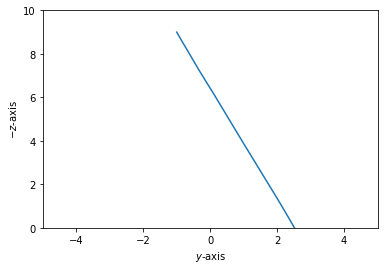

episode: 674/1000, score: -2815.720596307062  Average over last 100 episode: -2353.84 



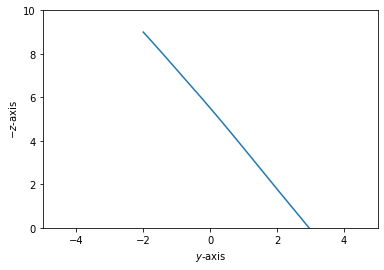

episode: 675/1000, score: -1683.5490074388842  Average over last 100 episode: -2347.01 



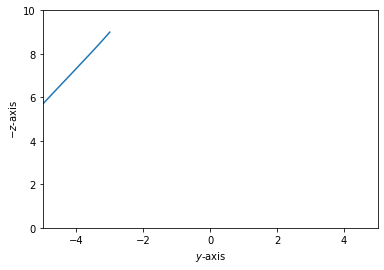

episode: 676/1000, score: -2083.4046701987836  Average over last 100 episode: -2341.38 



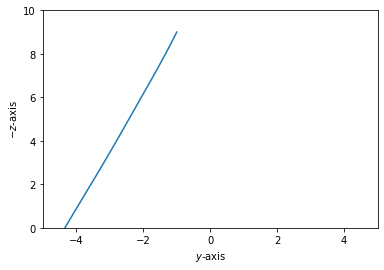

episode: 677/1000, score: -3351.1572834911185  Average over last 100 episode: -2338.86 



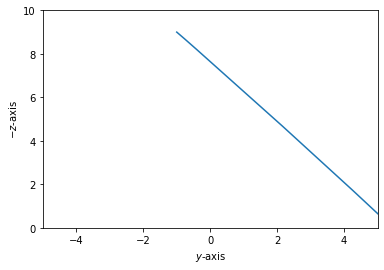

episode: 678/1000, score: -2500.7608215117743  Average over last 100 episode: -2342.43 



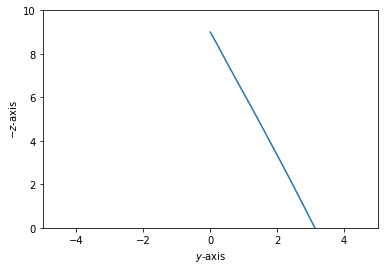

episode: 679/1000, score: -1889.9087971110966  Average over last 100 episode: -2329.69 



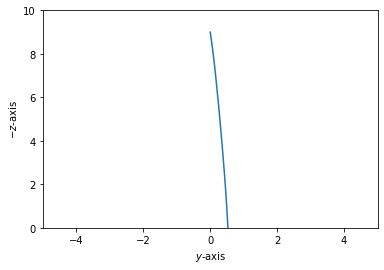

episode: 680/1000, score: -1669.2585829402658  Average over last 100 episode: -2319.47 



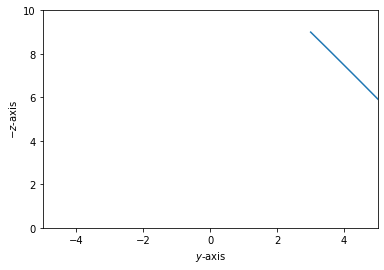

episode: 681/1000, score: -1935.5826558580598  Average over last 100 episode: -2318.16 



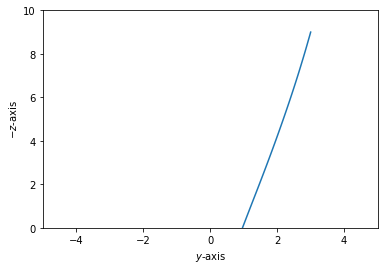

episode: 682/1000, score: -2245.9947385881096  Average over last 100 episode: -2321.55 



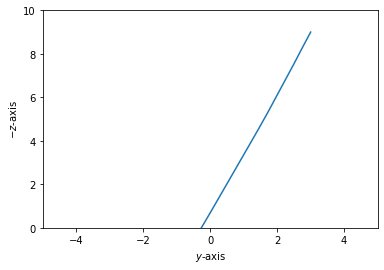

episode: 683/1000, score: -2346.948702719362  Average over last 100 episode: -2324.84 



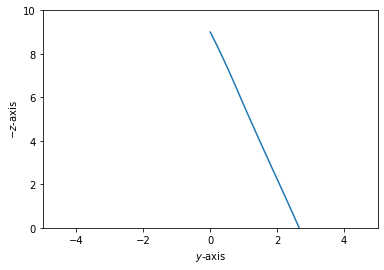

episode: 684/1000, score: -2298.4326154416885  Average over last 100 episode: -2326.75 



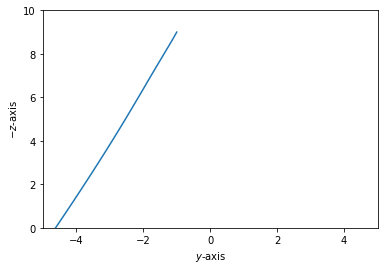

episode: 685/1000, score: -3022.4642327152906  Average over last 100 episode: -2338.00 



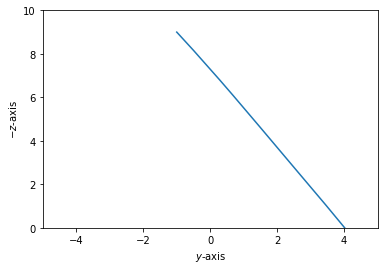

episode: 686/1000, score: -2046.4149172953696  Average over last 100 episode: -2339.21 



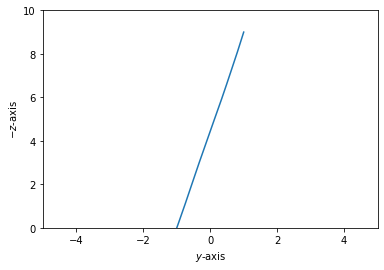

episode: 687/1000, score: -1944.0554211943436  Average over last 100 episode: -2338.35 



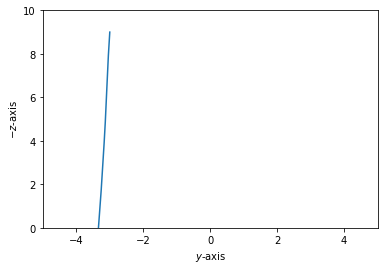

episode: 688/1000, score: -3150.0257615722194  Average over last 100 episode: -2334.22 



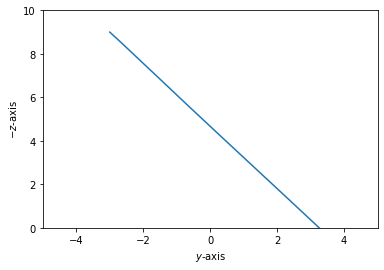

episode: 689/1000, score: -1704.2944281130656  Average over last 100 episode: -2323.15 



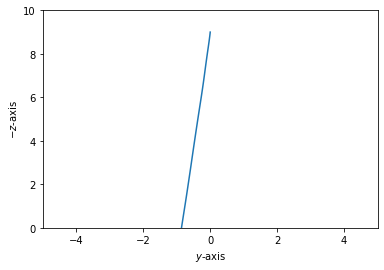

episode: 690/1000, score: -3537.720868766164  Average over last 100 episode: -2331.49 



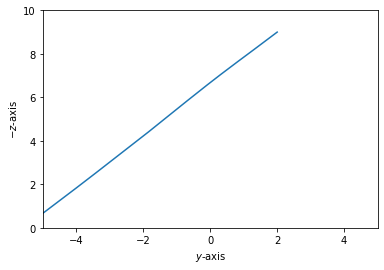

episode: 691/1000, score: -1992.0437444581244  Average over last 100 episode: -2327.17 



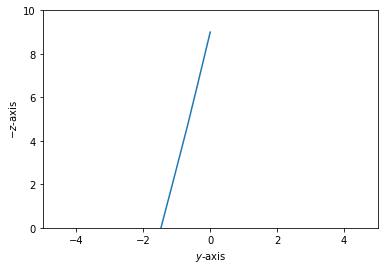

episode: 692/1000, score: -2894.2722847545024  Average over last 100 episode: -2338.28 



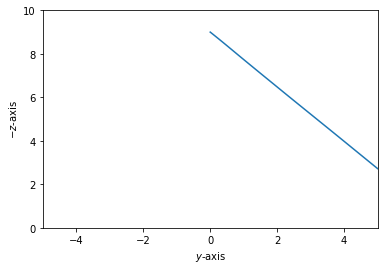

episode: 693/1000, score: -2497.553991433757  Average over last 100 episode: -2337.01 



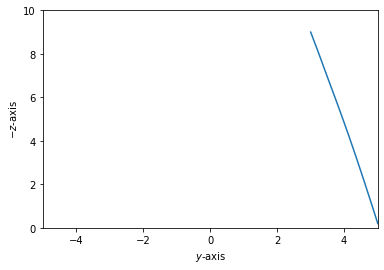

episode: 694/1000, score: -1564.6561927146058  Average over last 100 episode: -2334.09 



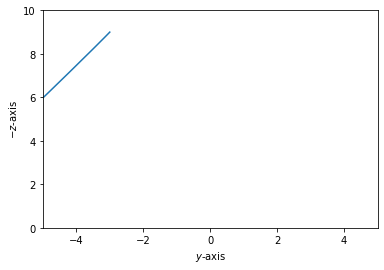

episode: 695/1000, score: -2675.7112318234713  Average over last 100 episode: -2338.10 



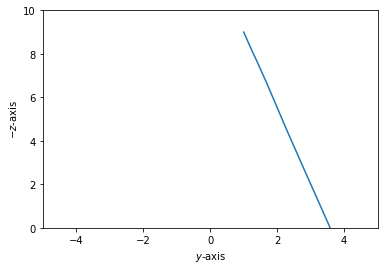

episode: 696/1000, score: -3285.712081364097  Average over last 100 episode: -2355.03 



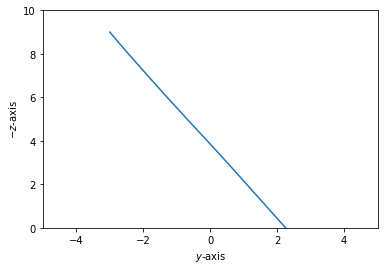

episode: 697/1000, score: -1548.772128470573  Average over last 100 episode: -2352.73 



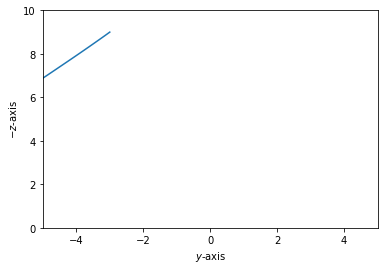

episode: 698/1000, score: -2403.7865887506023  Average over last 100 episode: -2350.50 



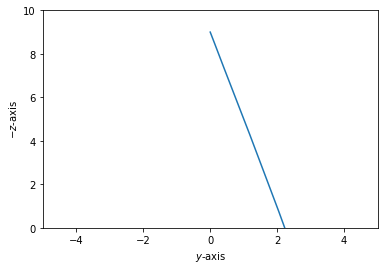

episode: 699/1000, score: -3668.5106644479233  Average over last 100 episode: -2360.68 



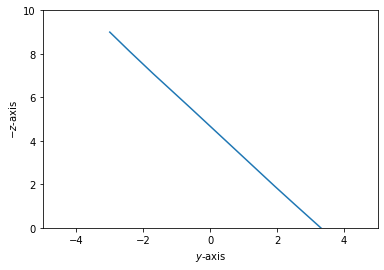

episode: 700/1000, score: -2081.482172460854  Average over last 100 episode: -2352.00 



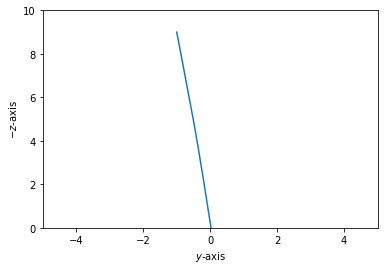

episode: 701/1000, score: -2051.518903629199  Average over last 100 episode: -2344.59 



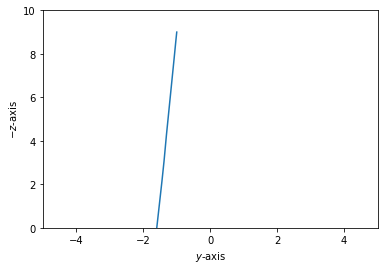

episode: 702/1000, score: -2182.406332383364  Average over last 100 episode: -2334.82 



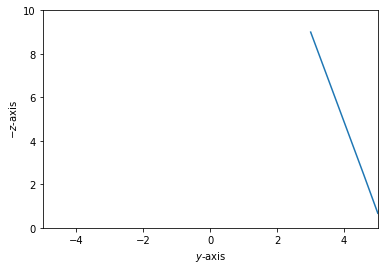

episode: 703/1000, score: -2188.258624096616  Average over last 100 episode: -2333.02 



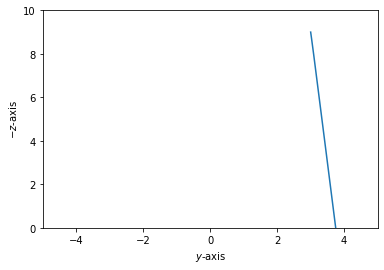

episode: 704/1000, score: -1998.568461328646  Average over last 100 episode: -2333.48 



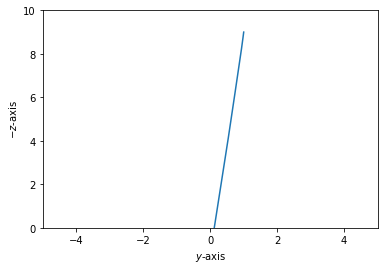

episode: 705/1000, score: -2130.67885579398  Average over last 100 episode: -2332.65 



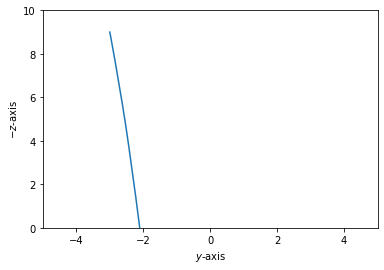

episode: 706/1000, score: -2320.1179843345267  Average over last 100 episode: -2326.98 



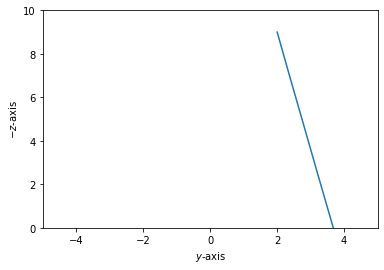

episode: 707/1000, score: -2726.6778207149155  Average over last 100 episode: -2337.80 



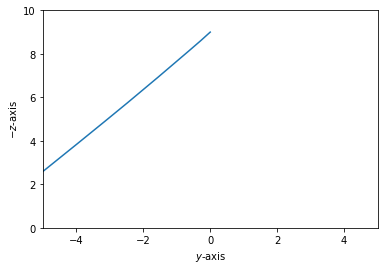

episode: 708/1000, score: -2746.4880929752694  Average over last 100 episode: -2337.75 



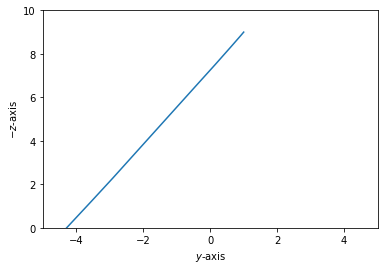

episode: 709/1000, score: -3637.7932049265282  Average over last 100 episode: -2346.90 



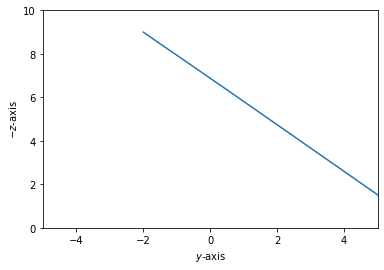

episode: 710/1000, score: -2060.6967095962955  Average over last 100 episode: -2345.57 



episode: 711/1000, score: -3221.3784016435134  Average over last 100 episode: -2352.88 



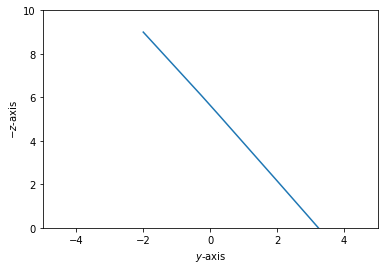

episode: 712/1000, score: -2120.350375576713  Average over last 100 episode: -2341.06 



episode: 713/1000, score: -2135.102088116981  Average over last 100 episode: -2345.75 



episode: 714/1000, score: -2487.8656153976585  Average over last 100 episode: -2352.58 



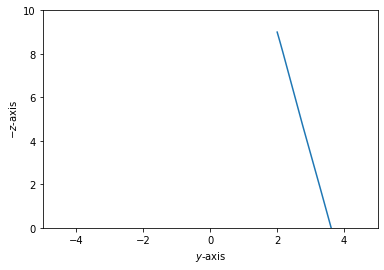

episode: 715/1000, score: -2412.8938842729613  Average over last 100 episode: -2358.03 



episode: 716/1000, score: -2107.0571271186295  Average over last 100 episode: -2354.28 



episode: 717/1000, score: -2632.070952650071  Average over last 100 episode: -2358.19 



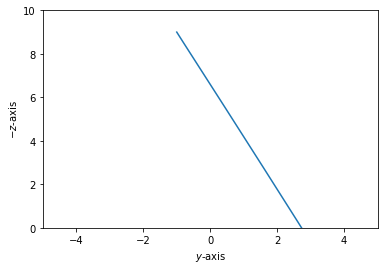

episode: 718/1000, score: -2820.143970931317  Average over last 100 episode: -2365.78 



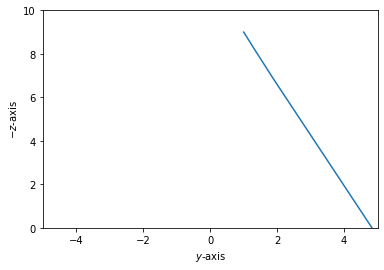

episode: 719/1000, score: -2326.752787707809  Average over last 100 episode: -2368.21 



episode: 720/1000, score: -2582.6409997655933  Average over last 100 episode: -2370.18 



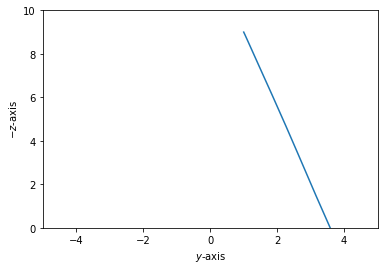

episode: 721/1000, score: -2590.290392734867  Average over last 100 episode: -2374.84 



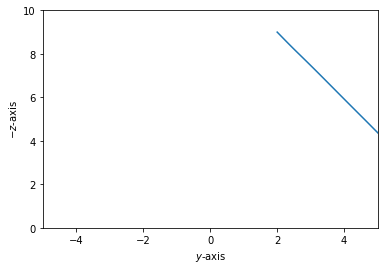

episode: 722/1000, score: -2957.7637655795793  Average over last 100 episode: -2377.07 



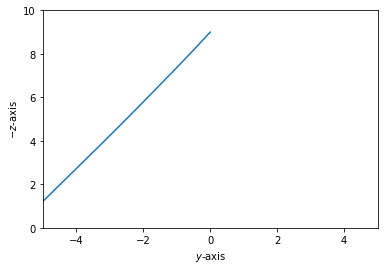

episode: 723/1000, score: -1841.3672092031775  Average over last 100 episode: -2374.04 



episode: 724/1000, score: -2778.183533118347  Average over last 100 episode: -2380.68 



episode: 725/1000, score: -3232.3278707501154  Average over last 100 episode: -2392.01 



episode: 726/1000, score: -2590.9065901615113  Average over last 100 episode: -2393.83 



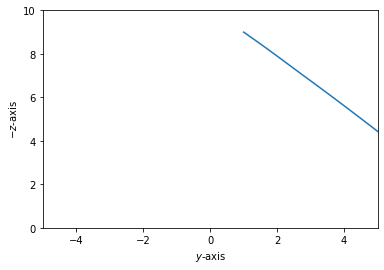

episode: 727/1000, score: -3811.318627653791  Average over last 100 episode: -2410.55 



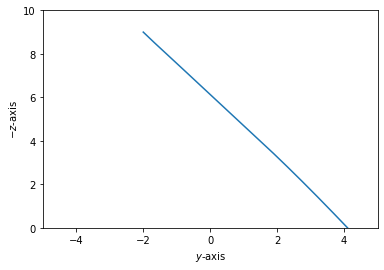

episode: 728/1000, score: -2659.7225076565096  Average over last 100 episode: -2408.50 



episode: 729/1000, score: -2192.9661772320173  Average over last 100 episode: -2394.79 



episode: 730/1000, score: -2683.185027132678  Average over last 100 episode: -2394.08 



episode: 731/1000, score: -2861.9307095135923  Average over last 100 episode: -2403.68 



episode: 732/1000, score: -2828.922051456732  Average over last 100 episode: -2407.37 



episode: 733/1000, score: -3380.7228926037797  Average over last 100 episode: -2413.22 



episode: 734/1000, score: -2355.0833112274604  Average over last 100 episode: -2408.78 



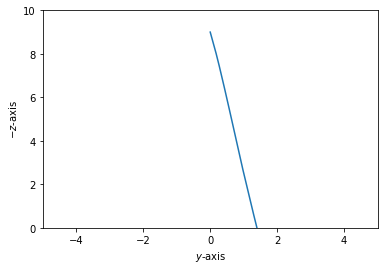

episode: 735/1000, score: -1735.03057687456  Average over last 100 episode: -2392.50 



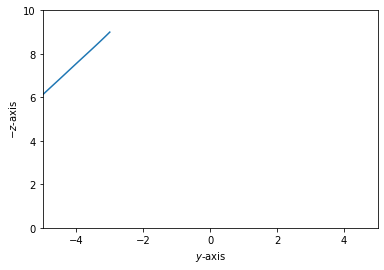

episode: 736/1000, score: -2503.983493247114  Average over last 100 episode: -2396.66 



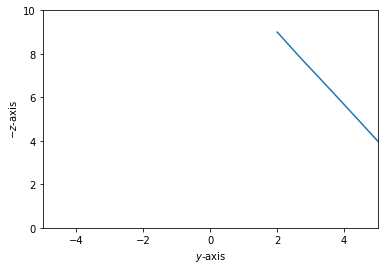

episode: 737/1000, score: -2255.9050949317  Average over last 100 episode: -2401.98 



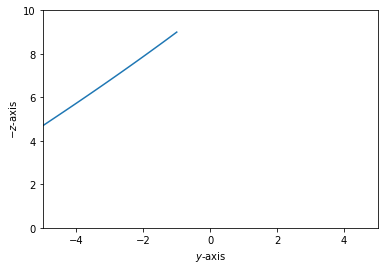

episode: 738/1000, score: -1865.5988514331284  Average over last 100 episode: -2400.29 



episode: 739/1000, score: -2096.752234630568  Average over last 100 episode: -2392.45 



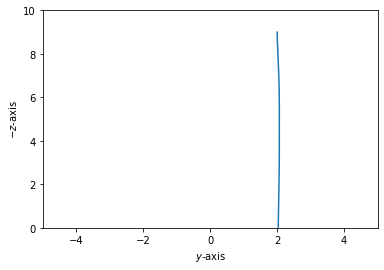

episode: 740/1000, score: -1718.0640175194378  Average over last 100 episode: -2387.26 



episode: 741/1000, score: -2495.299354617136  Average over last 100 episode: -2393.40 



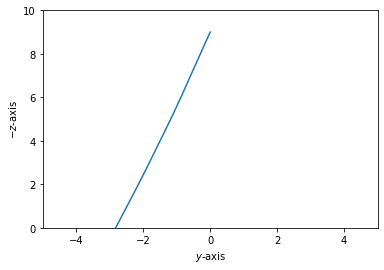

episode: 742/1000, score: -2226.4869708540327  Average over last 100 episode: -2394.69 



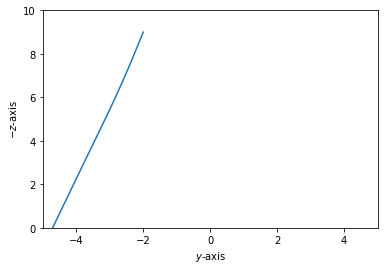

episode: 743/1000, score: -2970.2463469169134  Average over last 100 episode: -2408.33 



episode: 744/1000, score: -2108.3338603629686  Average over last 100 episode: -2401.96 



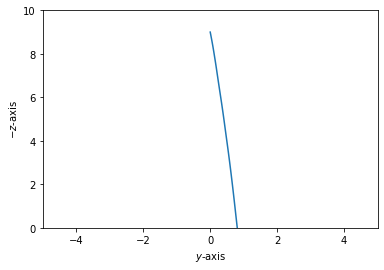

episode: 745/1000, score: -2637.7202570509044  Average over last 100 episode: -2403.87 



episode: 746/1000, score: -2106.853038047602  Average over last 100 episode: -2400.20 



episode: 747/1000, score: -1787.3005919130621  Average over last 100 episode: -2390.70 



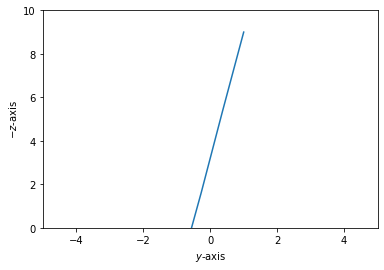

episode: 748/1000, score: -2128.4475017130203  Average over last 100 episode: -2388.19 



episode: 749/1000, score: -2730.7225240899656  Average over last 100 episode: -2391.96 



episode: 750/1000, score: -2257.043146012084  Average over last 100 episode: -2388.58 



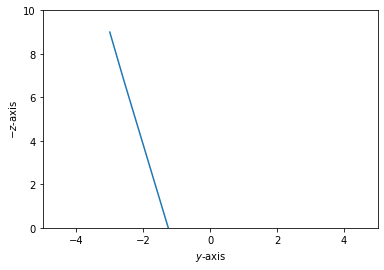

episode: 751/1000, score: -2015.79977692713  Average over last 100 episode: -2390.51 



episode: 752/1000, score: -2055.604393395068  Average over last 100 episode: -2391.11 



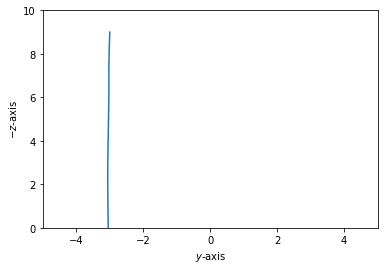

episode: 753/1000, score: -3450.6994049052455  Average over last 100 episode: -2408.81 



episode: 754/1000, score: -3327.010237179325  Average over last 100 episode: -2423.56 



episode: 755/1000, score: -2506.792690251449  Average over last 100 episode: -2425.58 



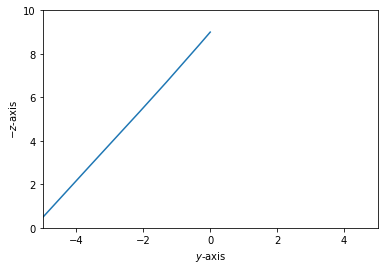

episode: 756/1000, score: -1912.468180922526  Average over last 100 episode: -2421.88 



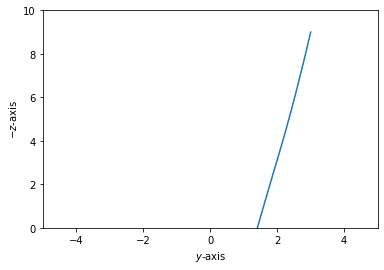

episode: 757/1000, score: -1810.3843301115214  Average over last 100 episode: -2413.17 



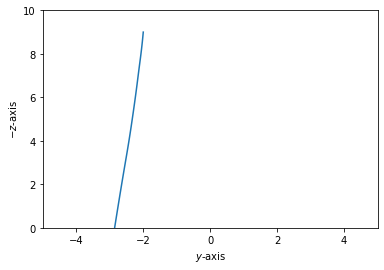

episode: 758/1000, score: -2270.671981814124  Average over last 100 episode: -2418.15 



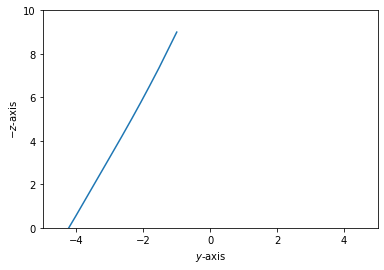

episode: 759/1000, score: -2298.19600199248  Average over last 100 episode: -2421.04 



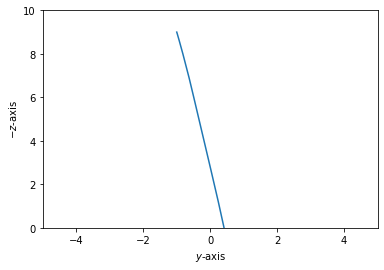

episode: 760/1000, score: -2282.0837429690123  Average over last 100 episode: -2423.27 



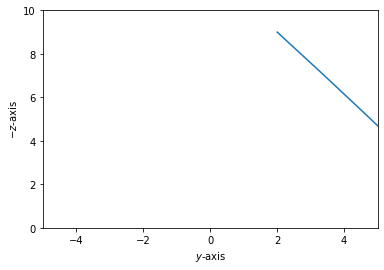

episode: 761/1000, score: -2007.1234234582382  Average over last 100 episode: -2417.89 



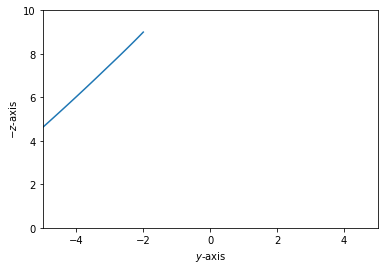

episode: 762/1000, score: -3423.389289037919  Average over last 100 episode: -2430.11 



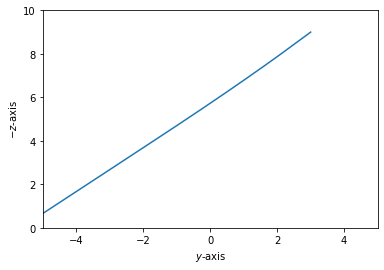

episode: 763/1000, score: -2930.617181605056  Average over last 100 episode: -2441.14 



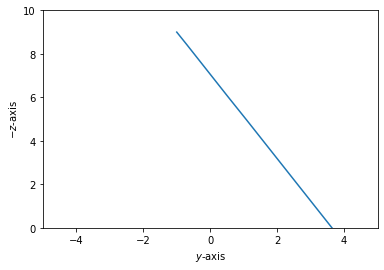

episode: 764/1000, score: -2720.7545469131546  Average over last 100 episode: -2448.80 



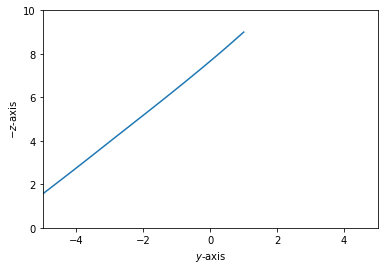

episode: 765/1000, score: -2088.4323923935276  Average over last 100 episode: -2444.02 



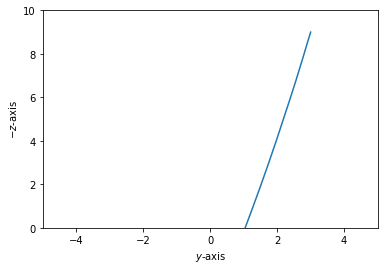

episode: 766/1000, score: -3223.8602269095704  Average over last 100 episode: -2458.59 



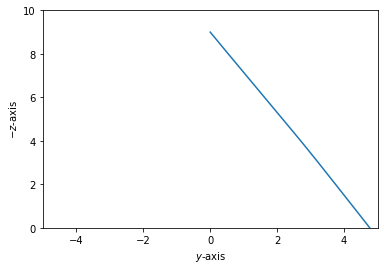

episode: 767/1000, score: -2195.2447607862623  Average over last 100 episode: -2455.71 



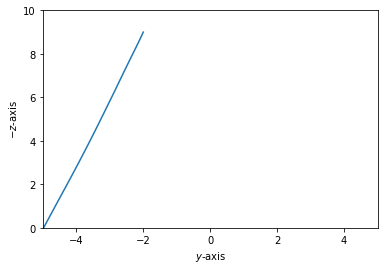

episode: 768/1000, score: -2643.968659689677  Average over last 100 episode: -2461.45 



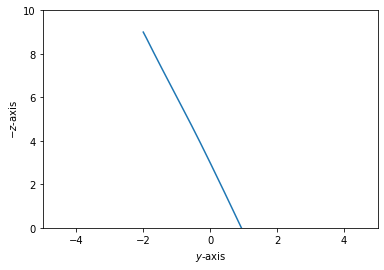

episode: 769/1000, score: -3136.407011821571  Average over last 100 episode: -2461.73 



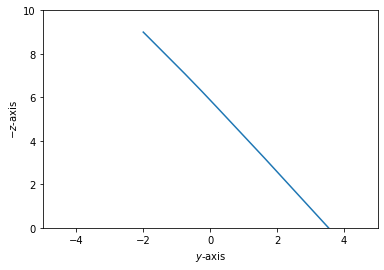

episode: 770/1000, score: -1871.7455125580202  Average over last 100 episode: -2457.41 



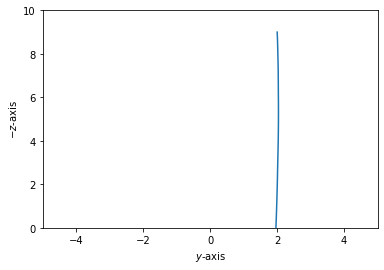

episode: 771/1000, score: -2700.3002786509333  Average over last 100 episode: -2460.26 



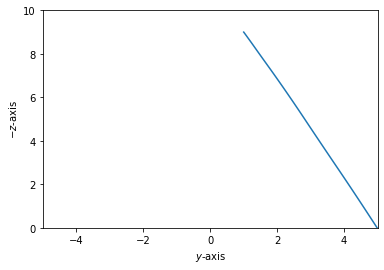

episode: 772/1000, score: -2000.8400781803225  Average over last 100 episode: -2458.75 



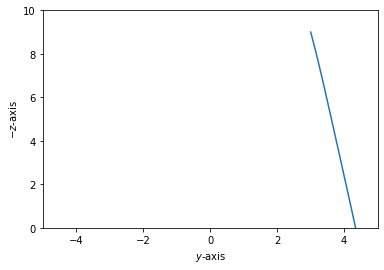

episode: 773/1000, score: -3408.4855662690857  Average over last 100 episode: -2463.97 



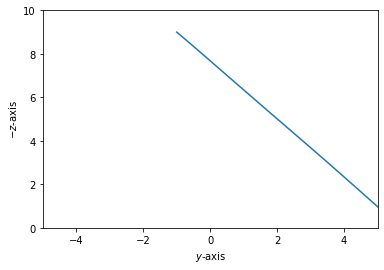

episode: 774/1000, score: -1924.4826631026926  Average over last 100 episode: -2455.06 



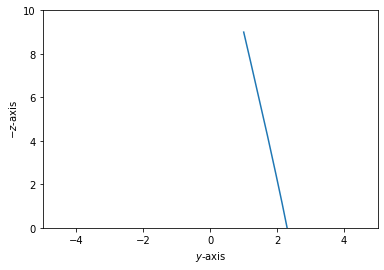

episode: 775/1000, score: -1783.3304544993973  Average over last 100 episode: -2456.06 



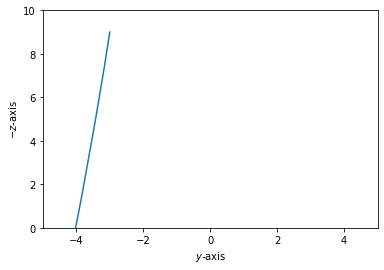

episode: 776/1000, score: -2900.2958212683534  Average over last 100 episode: -2464.22 



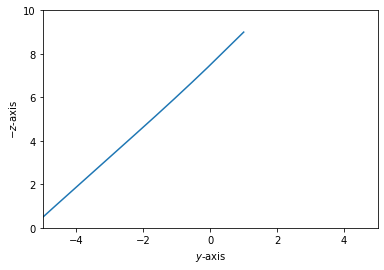

episode: 777/1000, score: -3781.0109075839146  Average over last 100 episode: -2468.52 



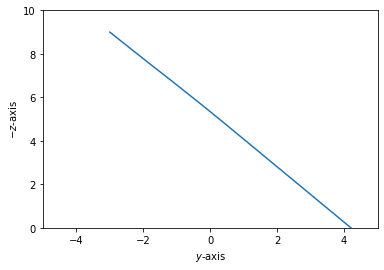

episode: 778/1000, score: -1961.0089720376393  Average over last 100 episode: -2463.13 



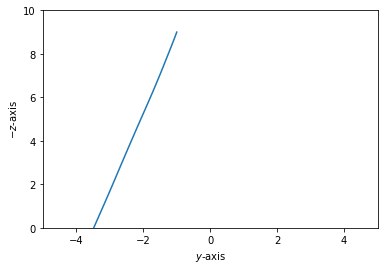

episode: 779/1000, score: -2495.7192081702037  Average over last 100 episode: -2469.18 



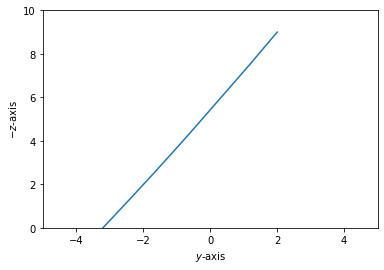

episode: 780/1000, score: -1903.2788124881774  Average over last 100 episode: -2471.52 



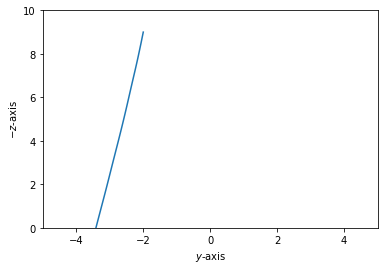

episode: 781/1000, score: -4560.227527437348  Average over last 100 episode: -2497.77 



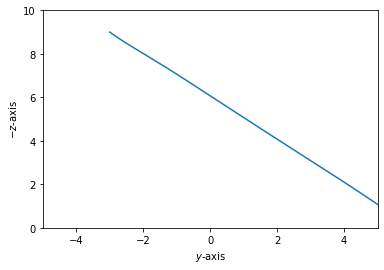

episode: 782/1000, score: -2070.8451592334677  Average over last 100 episode: -2496.02 



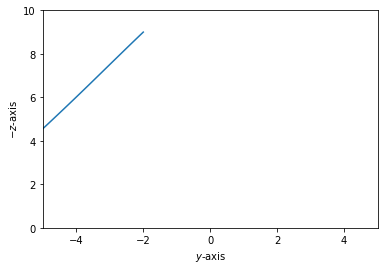

episode: 783/1000, score: -2127.991472030038  Average over last 100 episode: -2493.83 



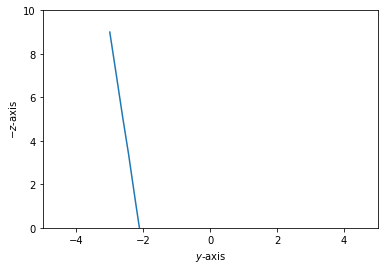

episode: 784/1000, score: -2065.8097747649  Average over last 100 episode: -2491.50 



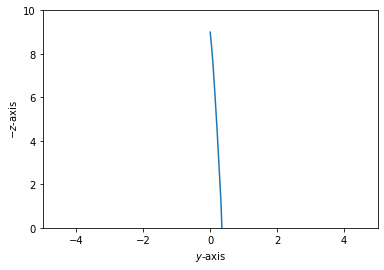

episode: 785/1000, score: -2288.2378534874624  Average over last 100 episode: -2484.16 



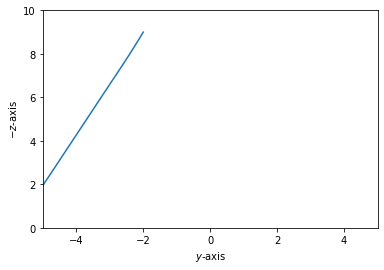

episode: 786/1000, score: -2306.9488233451175  Average over last 100 episode: -2486.77 



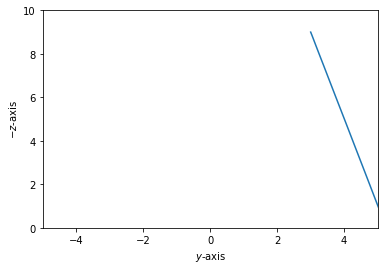

episode: 787/1000, score: -2218.6361867734418  Average over last 100 episode: -2489.51 



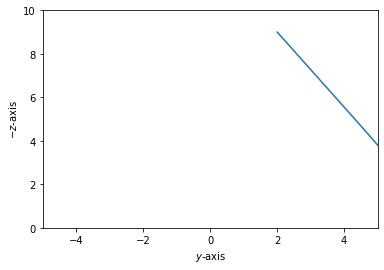

episode: 788/1000, score: -1724.2961193116525  Average over last 100 episode: -2475.25 



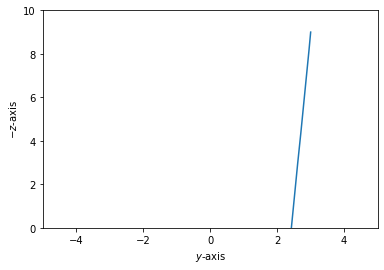

episode: 789/1000, score: -2135.3112518641783  Average over last 100 episode: -2479.56 



episode: 790/1000, score: -3275.519866214114  Average over last 100 episode: -2476.94 



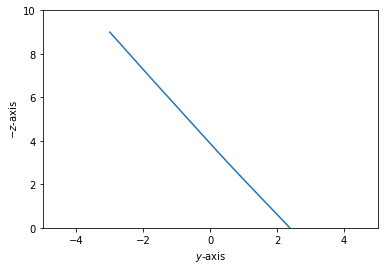

episode: 791/1000, score: -2282.726370091937  Average over last 100 episode: -2479.85 



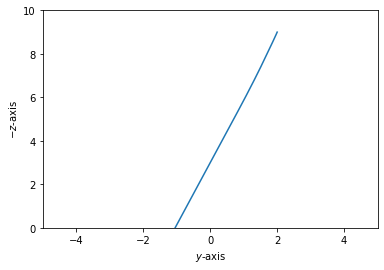

episode: 792/1000, score: -2704.2827764936565  Average over last 100 episode: -2477.95 



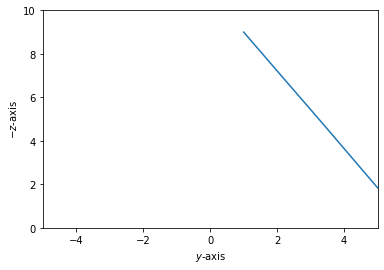

episode: 793/1000, score: -2517.285147928177  Average over last 100 episode: -2478.15 



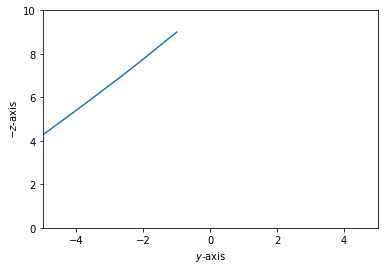

episode: 794/1000, score: -2527.8885221460637  Average over last 100 episode: -2487.78 



episode: 795/1000, score: -2128.047801758384  Average over last 100 episode: -2482.30 



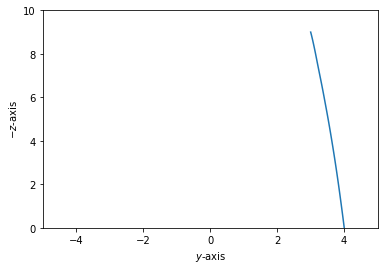

episode: 796/1000, score: -3646.7726408231524  Average over last 100 episode: -2485.91 



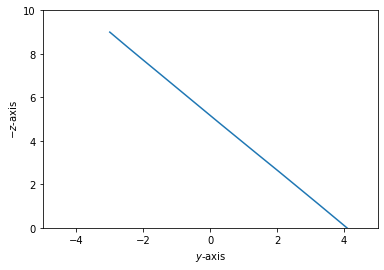

episode: 797/1000, score: -2720.195342611809  Average over last 100 episode: -2497.63 



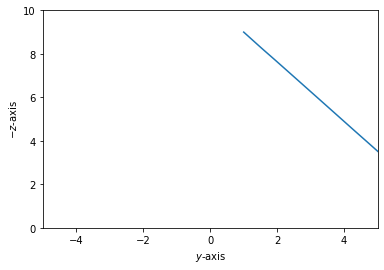

episode: 798/1000, score: -2120.785682685027  Average over last 100 episode: -2494.80 



episode: 799/1000, score: -1999.3665032586964  Average over last 100 episode: -2478.11 



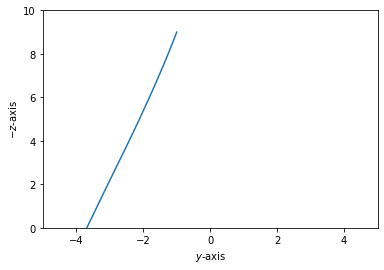

episode: 800/1000, score: -2717.681076300732  Average over last 100 episode: -2484.47 



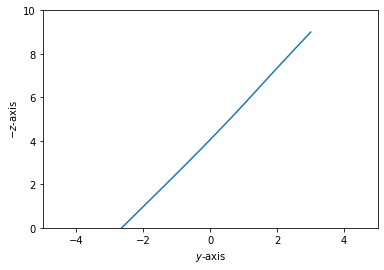

episode: 801/1000, score: -3227.621283000924  Average over last 100 episode: -2496.23 



episode: 802/1000, score: -2387.4554726072884  Average over last 100 episode: -2498.28 



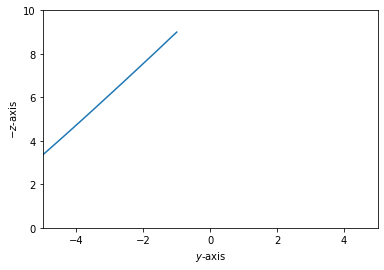

episode: 803/1000, score: -2430.586494911566  Average over last 100 episode: -2500.70 



episode: 804/1000, score: -2463.5477715971647  Average over last 100 episode: -2505.35 



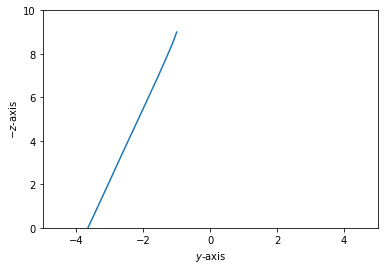

episode: 805/1000, score: -4158.9316428081265  Average over last 100 episode: -2525.64 



episode: 806/1000, score: -2553.38141257885  Average over last 100 episode: -2527.97 



episode: 807/1000, score: -3206.572180685841  Average over last 100 episode: -2532.77 



episode: 808/1000, score: -2913.218355343274  Average over last 100 episode: -2534.43 



episode: 809/1000, score: -2817.10254432819  Average over last 100 episode: -2526.23 



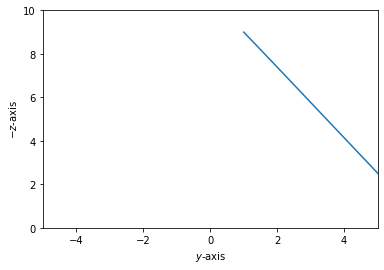

episode: 810/1000, score: -2442.1756083068212  Average over last 100 episode: -2530.04 



episode: 811/1000, score: -3305.9014050063734  Average over last 100 episode: -2530.89 



episode: 812/1000, score: -2263.6446665957515  Average over last 100 episode: -2532.32 



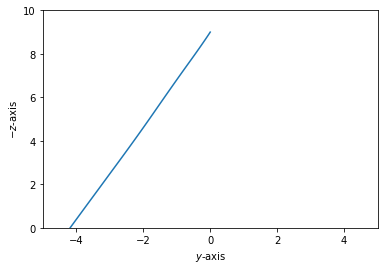

episode: 813/1000, score: -2475.6175436920494  Average over last 100 episode: -2535.73 



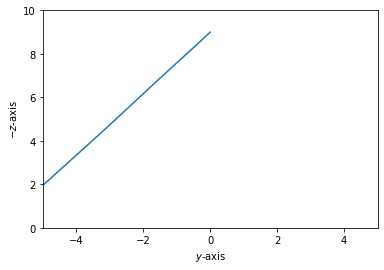

episode: 814/1000, score: -2094.91867934158  Average over last 100 episode: -2531.80 



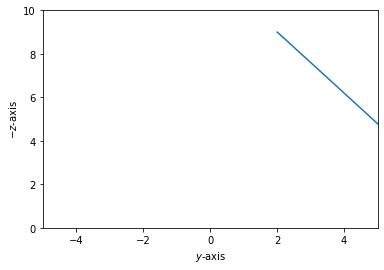

episode: 815/1000, score: -2148.3820923823932  Average over last 100 episode: -2529.15 



episode: 816/1000, score: -2321.425312252779  Average over last 100 episode: -2531.29 



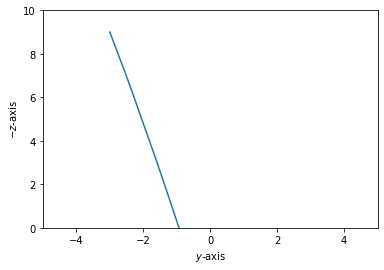

episode: 817/1000, score: -2133.755017322458  Average over last 100 episode: -2526.31 



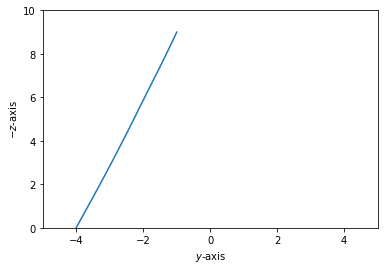

episode: 818/1000, score: -2243.8733161700507  Average over last 100 episode: -2520.55 



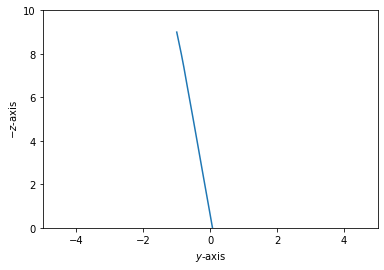

episode: 819/1000, score: -2551.413038160715  Average over last 100 episode: -2522.80 



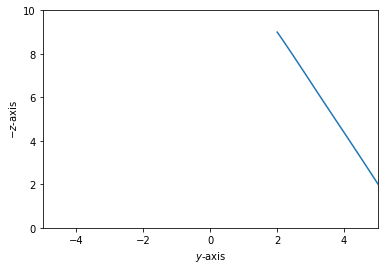

episode: 820/1000, score: -3232.143582308325  Average over last 100 episode: -2529.29 



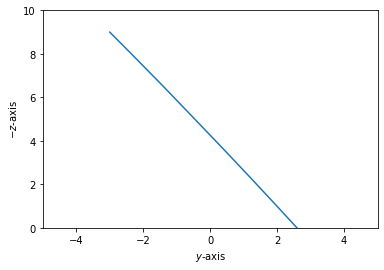

episode: 821/1000, score: -2046.2774882243982  Average over last 100 episode: -2523.85 



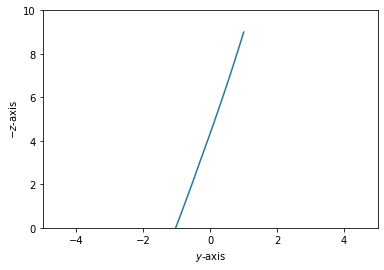

episode: 822/1000, score: -2384.926774290262  Average over last 100 episode: -2518.12 



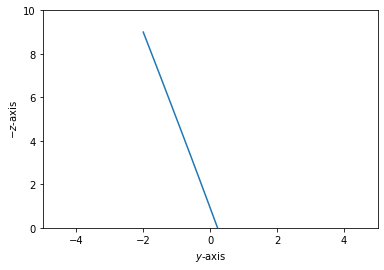

episode: 823/1000, score: -3083.1479045556025  Average over last 100 episode: -2530.54 



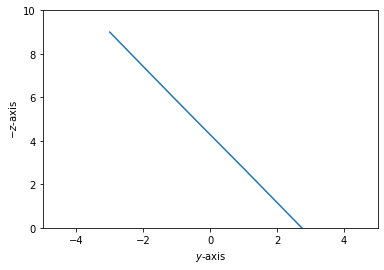

episode: 824/1000, score: -2668.3000883221953  Average over last 100 episode: -2529.44 



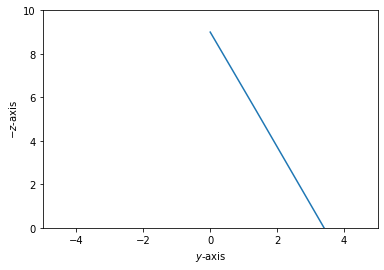

episode: 825/1000, score: -3540.242454508975  Average over last 100 episode: -2532.52 



episode: 826/1000, score: -2316.6418065650123  Average over last 100 episode: -2529.78 



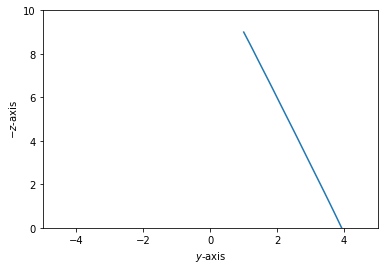

episode: 827/1000, score: -1852.3230938622507  Average over last 100 episode: -2510.19 



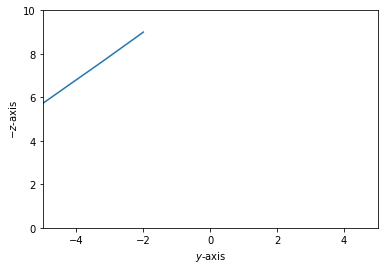

episode: 828/1000, score: -2696.636481019765  Average over last 100 episode: -2510.56 



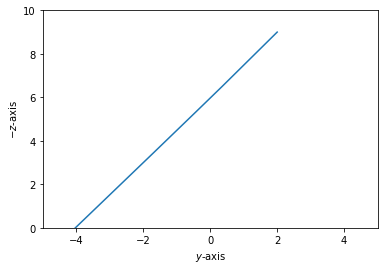

episode: 829/1000, score: -2181.973765464482  Average over last 100 episode: -2510.45 



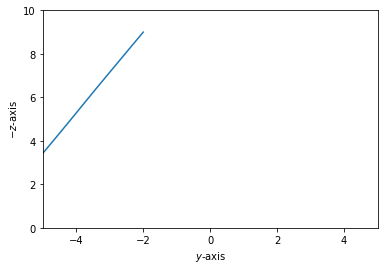

episode: 830/1000, score: -2535.8793770930556  Average over last 100 episode: -2508.97 



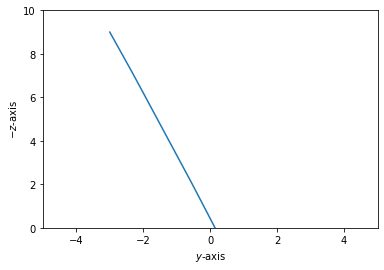

episode: 831/1000, score: -2390.8151981781666  Average over last 100 episode: -2504.26 



episode: 832/1000, score: -1983.89721016702  Average over last 100 episode: -2495.81 



episode: 833/1000, score: -3143.384661915801  Average over last 100 episode: -2493.44 



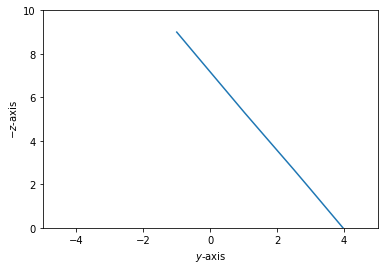

episode: 834/1000, score: -2468.038326662668  Average over last 100 episode: -2494.57 



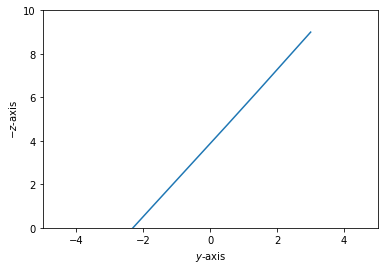

episode: 835/1000, score: -2007.0261698765148  Average over last 100 episode: -2497.29 



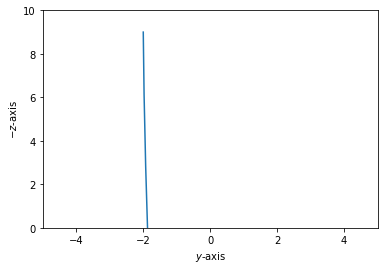

episode: 836/1000, score: -2506.5081227984656  Average over last 100 episode: -2497.31 



episode: 837/1000, score: -2216.2443045925447  Average over last 100 episode: -2496.92 



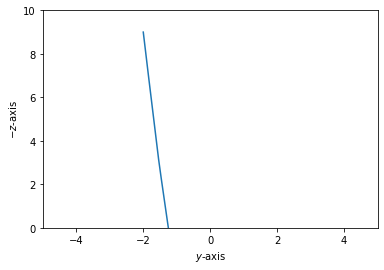

episode: 838/1000, score: -2164.3135242755584  Average over last 100 episode: -2499.90 



episode: 839/1000, score: -2371.253899456693  Average over last 100 episode: -2502.65 



episode: 840/1000, score: -1861.2068311349753  Average over last 100 episode: -2504.08 



episode: 841/1000, score: -1768.1762614366396  Average over last 100 episode: -2496.81 



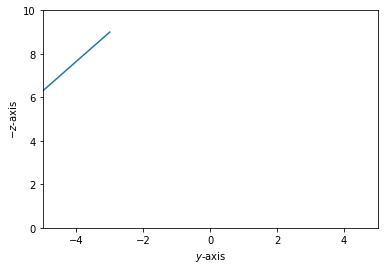

episode: 842/1000, score: -2288.309750837006  Average over last 100 episode: -2497.43 



episode: 843/1000, score: -1879.17534146365  Average over last 100 episode: -2486.52 



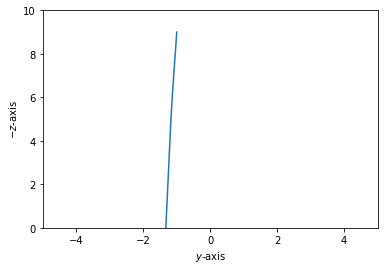

episode: 844/1000, score: -1957.151036393763  Average over last 100 episode: -2485.00 



episode: 845/1000, score: -2417.209235396587  Average over last 100 episode: -2482.80 



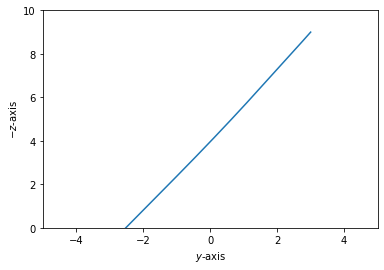

episode: 846/1000, score: -2014.1203763760611  Average over last 100 episode: -2481.87 



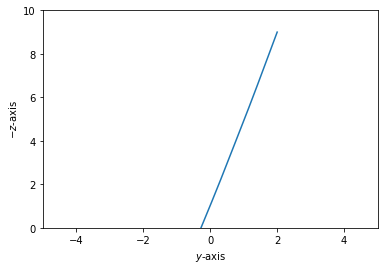

episode: 847/1000, score: -2529.247616364363  Average over last 100 episode: -2489.29 



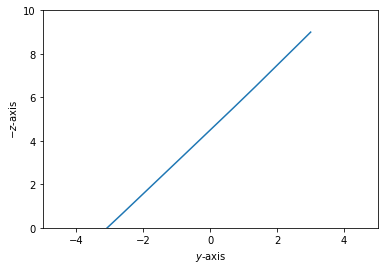

episode: 848/1000, score: -1941.8146162932355  Average over last 100 episode: -2487.43 



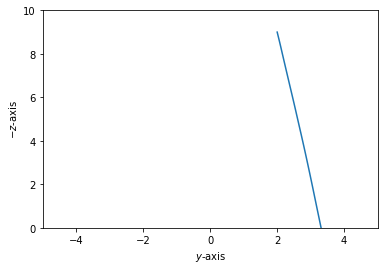

episode: 849/1000, score: -2027.074119006991  Average over last 100 episode: -2480.39 



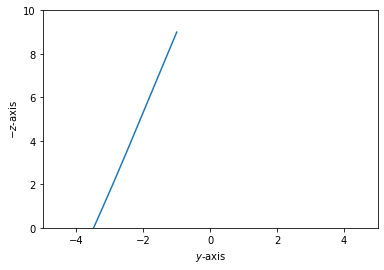

episode: 850/1000, score: -2532.718412509643  Average over last 100 episode: -2483.15 



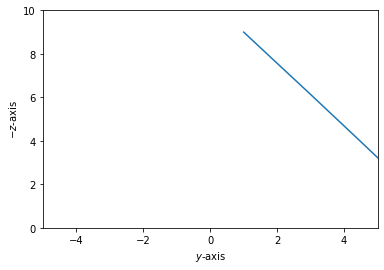

episode: 851/1000, score: -2224.5830795342827  Average over last 100 episode: -2485.23 



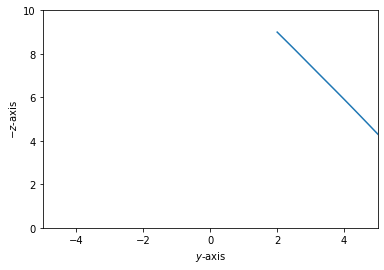

episode: 852/1000, score: -2830.7780233291337  Average over last 100 episode: -2492.99 



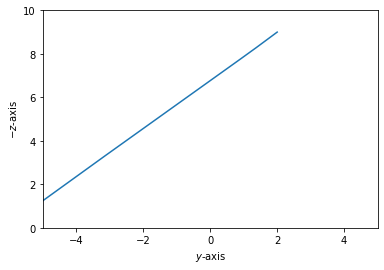

episode: 853/1000, score: -3078.3081495253264  Average over last 100 episode: -2489.26 



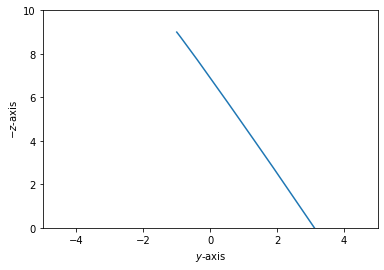

episode: 854/1000, score: -3127.9732799125672  Average over last 100 episode: -2487.27 



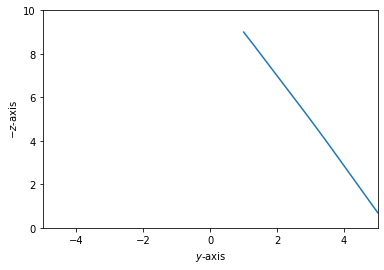

episode: 855/1000, score: -2257.578303900556  Average over last 100 episode: -2484.78 



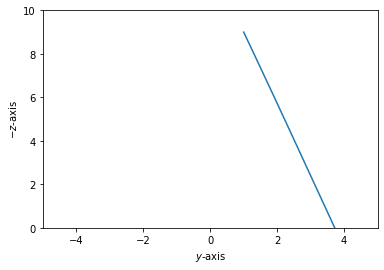

episode: 856/1000, score: -2004.78796117146  Average over last 100 episode: -2485.70 



episode: 857/1000, score: -2318.968151939868  Average over last 100 episode: -2490.79 



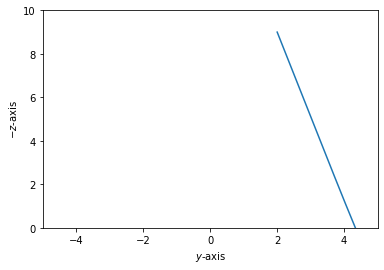

episode: 858/1000, score: -3127.4270982250973  Average over last 100 episode: -2499.36 



episode: 859/1000, score: -2218.413493440607  Average over last 100 episode: -2498.56 



episode: 860/1000, score: -2125.7080234893965  Average over last 100 episode: -2496.99 



episode: 861/1000, score: -2460.7229005704644  Average over last 100 episode: -2501.53 



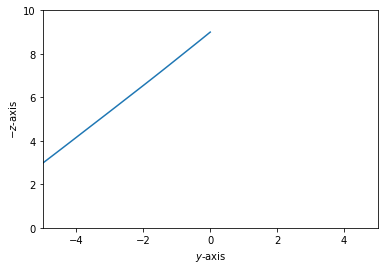

episode: 862/1000, score: -3087.991626795673  Average over last 100 episode: -2498.18 



episode: 863/1000, score: -2028.3592777712843  Average over last 100 episode: -2489.15 



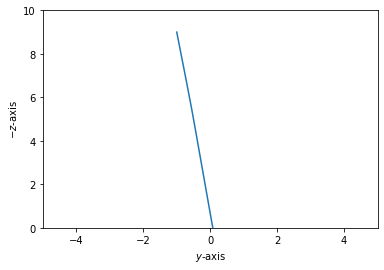

episode: 864/1000, score: -2527.5580605724986  Average over last 100 episode: -2487.22 



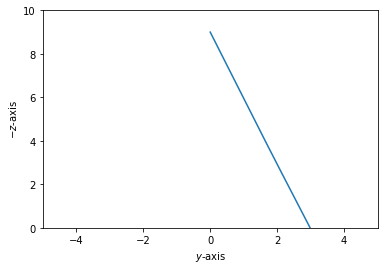

episode: 865/1000, score: -3013.272814682659  Average over last 100 episode: -2496.47 



episode: 866/1000, score: -2541.9477804028497  Average over last 100 episode: -2489.65 



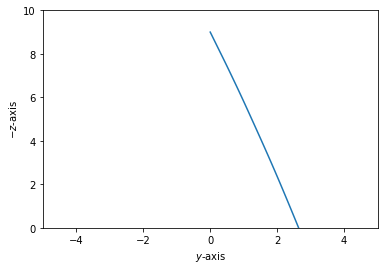

episode: 867/1000, score: -2048.4687691508766  Average over last 100 episode: -2488.18 



episode: 868/1000, score: -2077.9885476799304  Average over last 100 episode: -2482.52 



episode: 869/1000, score: -1701.9861066348037  Average over last 100 episode: -2468.18 



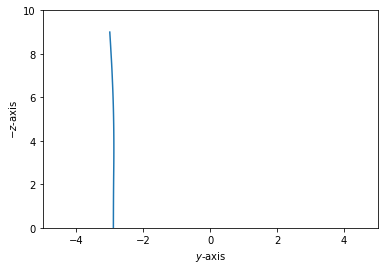

episode: 870/1000, score: -2381.522232875329  Average over last 100 episode: -2473.28 



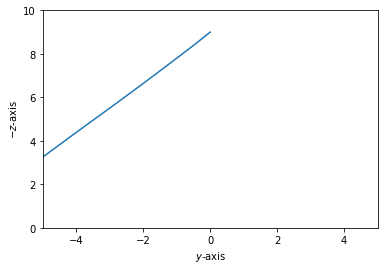

episode: 871/1000, score: -2588.718380715542  Average over last 100 episode: -2472.16 



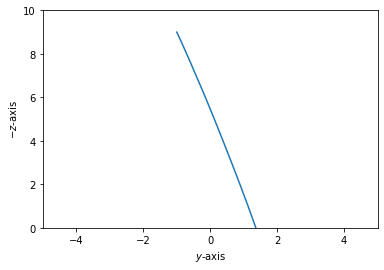

episode: 872/1000, score: -2057.1376289911323  Average over last 100 episode: -2472.72 



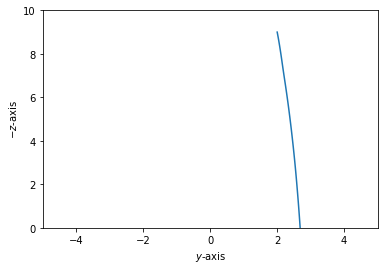

episode: 873/1000, score: -2558.9596870550376  Average over last 100 episode: -2464.23 



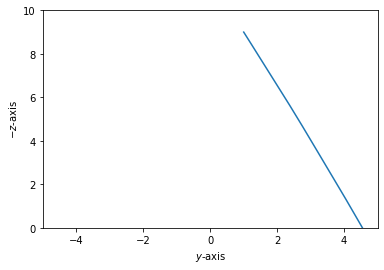

episode: 874/1000, score: -2036.3371052312532  Average over last 100 episode: -2465.35 



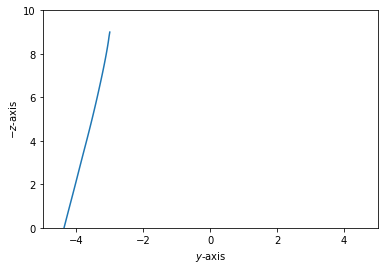

episode: 875/1000, score: -2170.4779128962796  Average over last 100 episode: -2469.22 



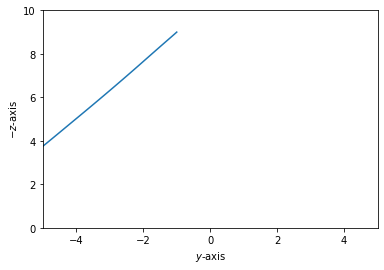

episode: 876/1000, score: -2703.7100639686555  Average over last 100 episode: -2467.25 



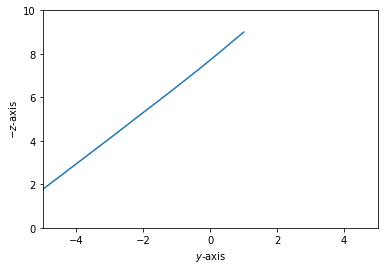

episode: 877/1000, score: -2702.950802660695  Average over last 100 episode: -2456.47 



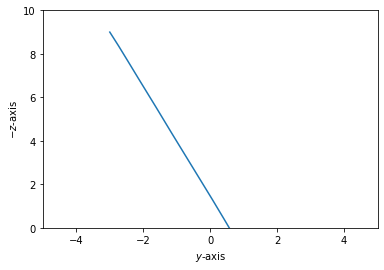

episode: 878/1000, score: -2884.2504606465577  Average over last 100 episode: -2465.70 



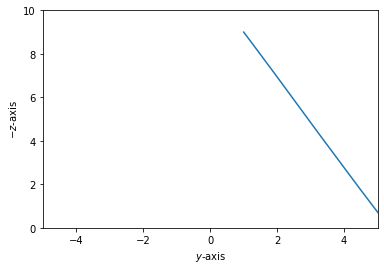

episode: 879/1000, score: -1997.2642218561691  Average over last 100 episode: -2460.72 



episode: 880/1000, score: -1948.4104300498439  Average over last 100 episode: -2461.17 



episode: 881/1000, score: -1988.66799519789  Average over last 100 episode: -2435.46 



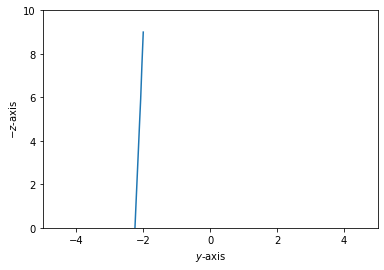

episode: 882/1000, score: -1961.8653834050551  Average over last 100 episode: -2434.37 



episode: 883/1000, score: -2047.2149529248393  Average over last 100 episode: -2433.56 



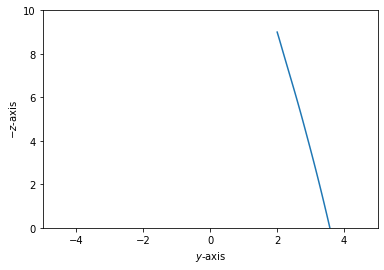

episode: 884/1000, score: -1783.5252141112442  Average over last 100 episode: -2430.74 



episode: 885/1000, score: -1924.3629893611721  Average over last 100 episode: -2427.10 



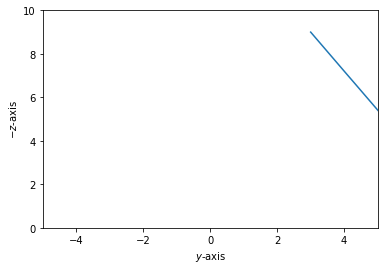

episode: 886/1000, score: -3144.9753199795373  Average over last 100 episode: -2435.48 



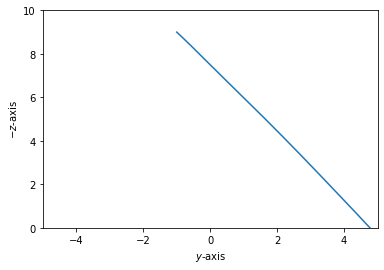

episode: 887/1000, score: -2535.3627646348045  Average over last 100 episode: -2438.64 



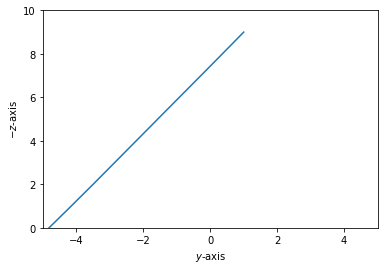

episode: 888/1000, score: -2786.6384173559873  Average over last 100 episode: -2449.27 



episode: 889/1000, score: -1768.2572735322933  Average over last 100 episode: -2445.60 



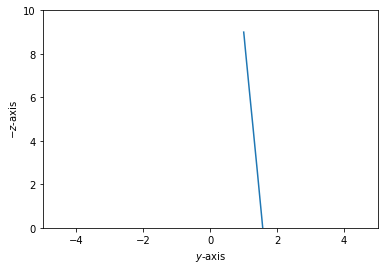

episode: 890/1000, score: -1996.071094729957  Average over last 100 episode: -2432.80 



episode: 891/1000, score: -2193.6623455572135  Average over last 100 episode: -2431.91 



episode: 892/1000, score: -2186.308956186163  Average over last 100 episode: -2426.73 



episode: 893/1000, score: -2555.968576549769  Average over last 100 episode: -2427.12 



episode: 894/1000, score: -1804.8070705251007  Average over last 100 episode: -2419.89 



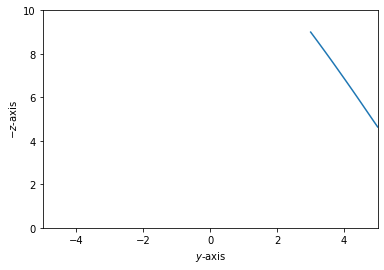

episode: 895/1000, score: -1572.9964606424269  Average over last 100 episode: -2414.34 



episode: 896/1000, score: -2255.844121306993  Average over last 100 episode: -2400.43 



episode: 897/1000, score: -2393.963336342159  Average over last 100 episode: -2397.17 



episode: 898/1000, score: -1746.322979488114  Average over last 100 episode: -2393.42 



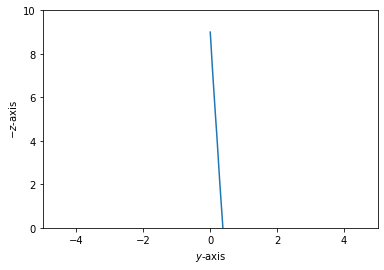

episode: 899/1000, score: -2071.0367782930816  Average over last 100 episode: -2394.14 



episode: 900/1000, score: -1942.05176420887  Average over last 100 episode: -2386.38 



episode: 901/1000, score: -2140.3729944121174  Average over last 100 episode: -2375.51 



episode: 902/1000, score: -2373.849822290848  Average over last 100 episode: -2375.37 



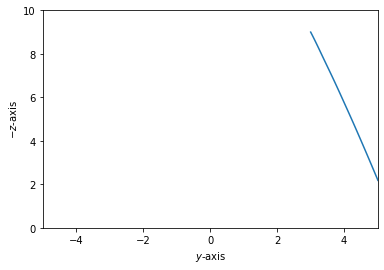

episode: 903/1000, score: -2276.453656884527  Average over last 100 episode: -2373.83 



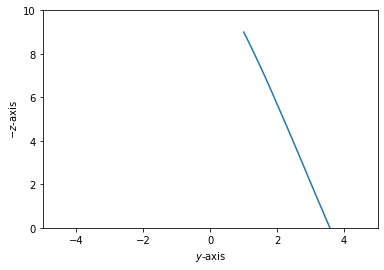

episode: 904/1000, score: -1529.2568849663357  Average over last 100 episode: -2364.49 



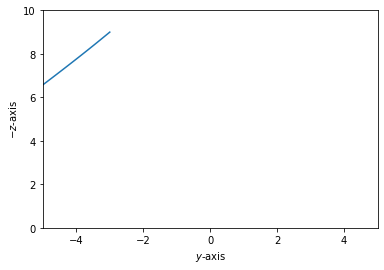

episode: 905/1000, score: -2283.1710722721596  Average over last 100 episode: -2345.73 



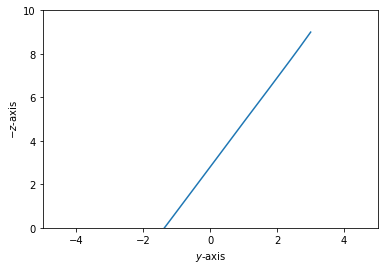

episode: 906/1000, score: -2829.038400950133  Average over last 100 episode: -2348.49 



episode: 907/1000, score: -2200.065060426229  Average over last 100 episode: -2338.42 



episode: 908/1000, score: -3332.4886371315342  Average over last 100 episode: -2342.62 



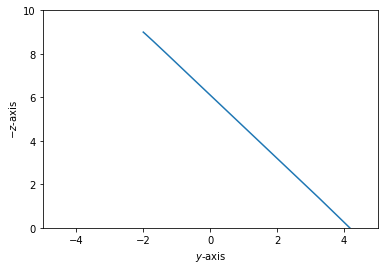

episode: 909/1000, score: -1913.5128572456654  Average over last 100 episode: -2333.58 



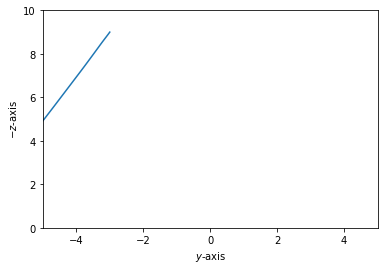

episode: 910/1000, score: -3346.4948218589197  Average over last 100 episode: -2342.62 



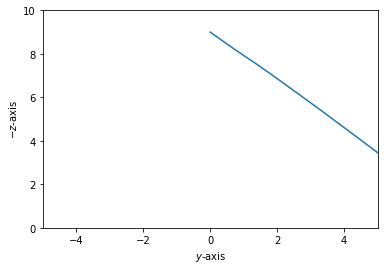

episode: 911/1000, score: -2151.0203111790847  Average over last 100 episode: -2331.07 



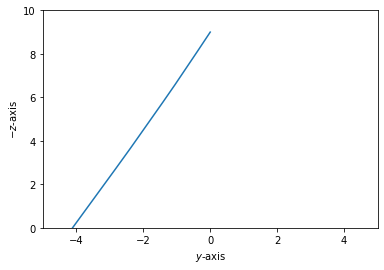

episode: 912/1000, score: -2233.2065811185253  Average over last 100 episode: -2330.77 



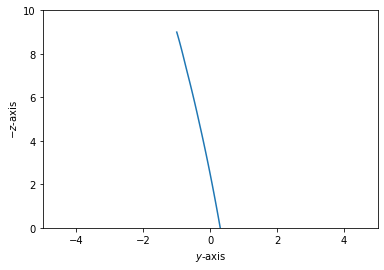

episode: 913/1000, score: -1757.8307855765736  Average over last 100 episode: -2323.59 



episode: 914/1000, score: -1807.9608190670092  Average over last 100 episode: -2320.72 



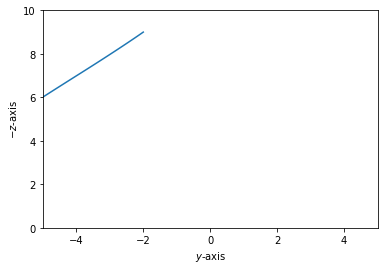

episode: 915/1000, score: -2314.7060001155705  Average over last 100 episode: -2322.39 



episode: 916/1000, score: -1944.6846420281413  Average over last 100 episode: -2318.62 



episode: 917/1000, score: -2282.9750187356854  Average over last 100 episode: -2320.11 



episode: 918/1000, score: -1808.7103467475572  Average over last 100 episode: -2315.76 



episode: 919/1000, score: -2989.988689987139  Average over last 100 episode: -2320.14 



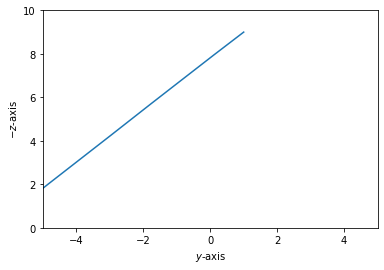

episode: 920/1000, score: -2364.856490250865  Average over last 100 episode: -2311.47 



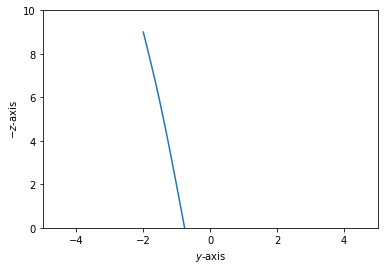

episode: 921/1000, score: -1963.7552785248306  Average over last 100 episode: -2310.65 



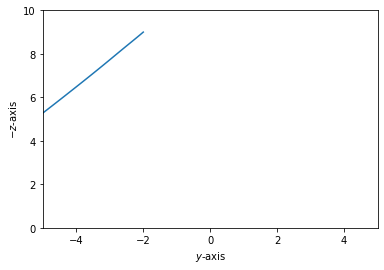

episode: 922/1000, score: -2007.554218424683  Average over last 100 episode: -2306.87 



episode: 923/1000, score: -1903.534442711275  Average over last 100 episode: -2295.08 



episode: 924/1000, score: -2563.579188571246  Average over last 100 episode: -2294.03 



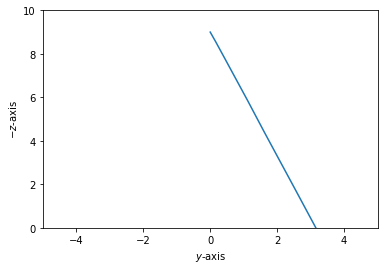

episode: 925/1000, score: -2480.9147742508885  Average over last 100 episode: -2283.44 



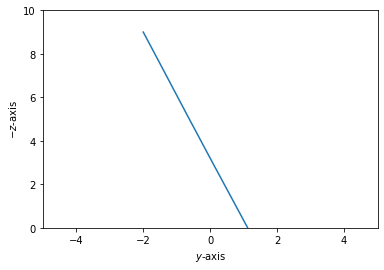

episode: 926/1000, score: -2515.9918495666598  Average over last 100 episode: -2285.43 



episode: 927/1000, score: -3109.1360399382584  Average over last 100 episode: -2298.00 



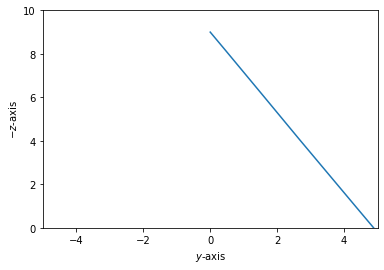

episode: 928/1000, score: -2908.6256671608508  Average over last 100 episode: -2300.12 



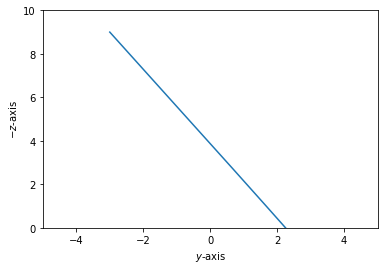

episode: 929/1000, score: -2437.8591290204236  Average over last 100 episode: -2302.68 



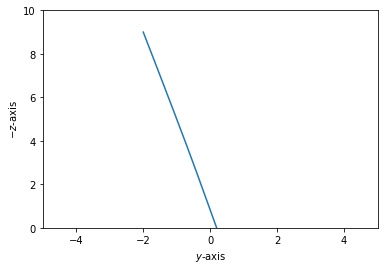

episode: 930/1000, score: -2466.92248435798  Average over last 100 episode: -2301.99 



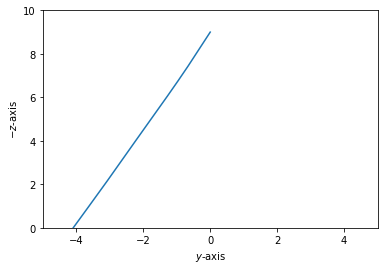

episode: 931/1000, score: -1786.5912368265567  Average over last 100 episode: -2295.94 



episode: 932/1000, score: -3692.2591244023533  Average over last 100 episode: -2313.03 



episode: 933/1000, score: -1796.3688155974412  Average over last 100 episode: -2299.56 



episode: 934/1000, score: -2243.870158581441  Average over last 100 episode: -2297.32 



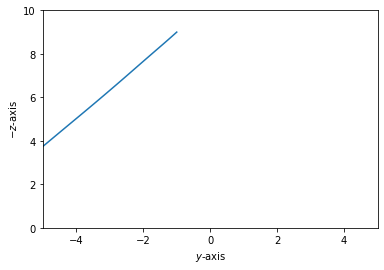

episode: 935/1000, score: -1906.386939158104  Average over last 100 episode: -2296.31 



episode: 936/1000, score: -2027.2998041128506  Average over last 100 episode: -2291.52 



episode: 937/1000, score: -1983.1335791540112  Average over last 100 episode: -2289.19 



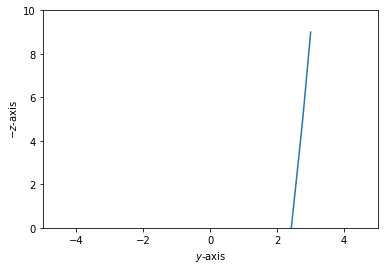

episode: 938/1000, score: -2233.2627822460668  Average over last 100 episode: -2289.88 



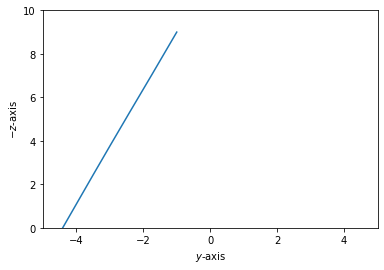

episode: 939/1000, score: -1890.948021725574  Average over last 100 episode: -2285.07 



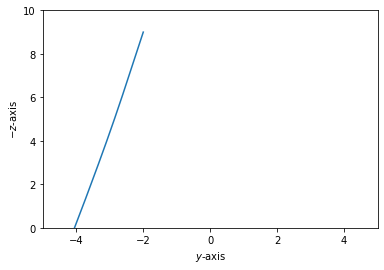

episode: 940/1000, score: -2277.751308067854  Average over last 100 episode: -2289.24 



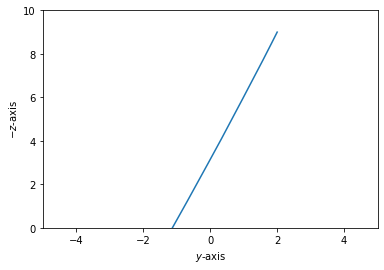

episode: 941/1000, score: -2135.95209618165  Average over last 100 episode: -2292.92 



episode: 942/1000, score: -1860.787409486516  Average over last 100 episode: -2288.64 



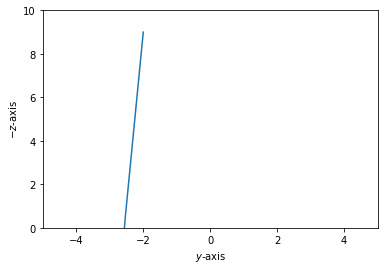

episode: 943/1000, score: -2836.2778347195485  Average over last 100 episode: -2298.21 



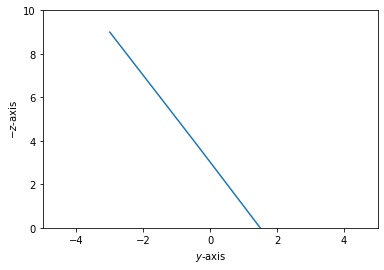

episode: 944/1000, score: -2127.0570994268337  Average over last 100 episode: -2299.91 



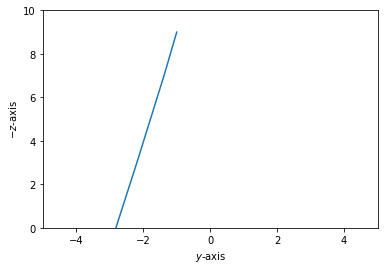

episode: 945/1000, score: -2268.830594250624  Average over last 100 episode: -2298.43 



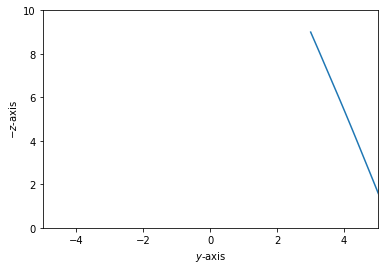

episode: 946/1000, score: -1722.6453301099014  Average over last 100 episode: -2295.51 



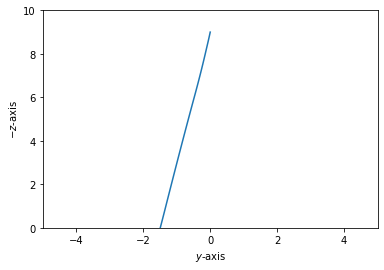

episode: 947/1000, score: -1827.2928086166162  Average over last 100 episode: -2288.49 



episode: 948/1000, score: -2531.6224943240086  Average over last 100 episode: -2294.39 



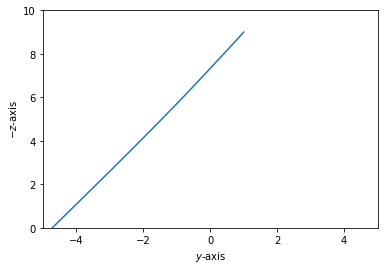

episode: 949/1000, score: -1746.8231551291888  Average over last 100 episode: -2291.59 



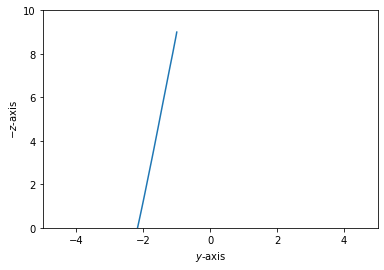

episode: 950/1000, score: -2045.5431311574089  Average over last 100 episode: -2286.72 



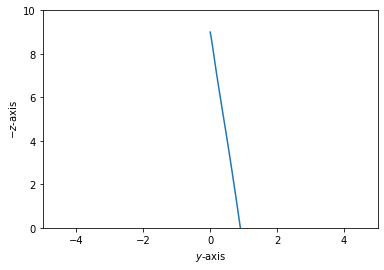

episode: 951/1000, score: -1828.957709149958  Average over last 100 episode: -2282.76 



episode: 952/1000, score: -2956.3827466339017  Average over last 100 episode: -2284.02 



episode: 953/1000, score: -2474.675859163163  Average over last 100 episode: -2277.98 



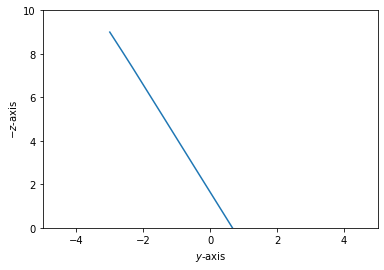

episode: 954/1000, score: -2885.8004573098997  Average over last 100 episode: -2275.56 



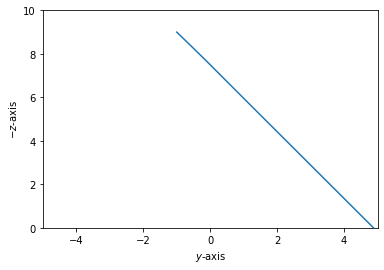

episode: 955/1000, score: -2101.5871344858374  Average over last 100 episode: -2274.00 



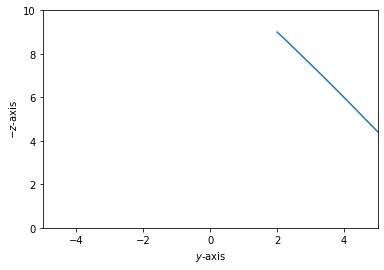

episode: 956/1000, score: -1470.6178065304946  Average over last 100 episode: -2268.66 



episode: 957/1000, score: -1982.5693176480188  Average over last 100 episode: -2265.29 



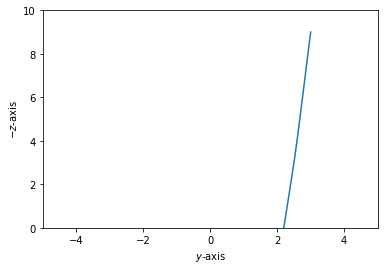

episode: 958/1000, score: -2977.452755375392  Average over last 100 episode: -2263.79 



episode: 959/1000, score: -1544.797511893878  Average over last 100 episode: -2257.06 



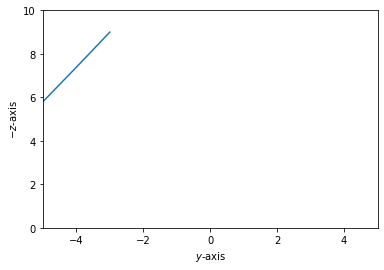

episode: 960/1000, score: -1931.8065562896127  Average over last 100 episode: -2255.12 



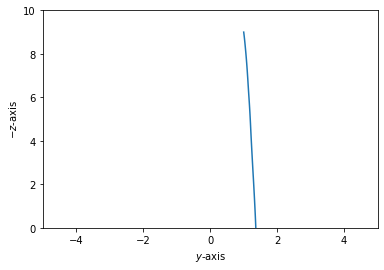

episode: 961/1000, score: -2634.1056231181005  Average over last 100 episode: -2256.85 



episode: 962/1000, score: -2437.139623265212  Average over last 100 episode: -2250.34 



episode: 963/1000, score: -2297.9799859170967  Average over last 100 episode: -2253.04 



episode: 964/1000, score: -2364.296242430115  Average over last 100 episode: -2251.41 



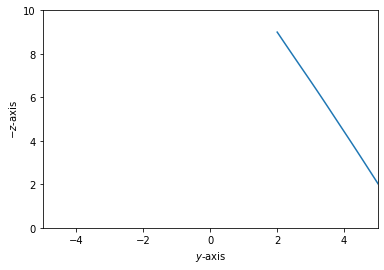

episode: 965/1000, score: -1860.0062918351127  Average over last 100 episode: -2239.87 



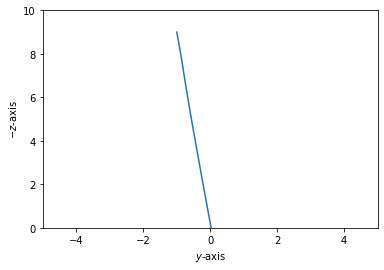

episode: 966/1000, score: -1910.7773025991014  Average over last 100 episode: -2233.56 



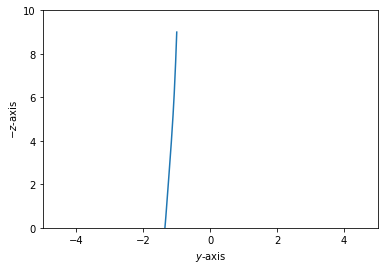

episode: 967/1000, score: -2023.3442361478114  Average over last 100 episode: -2233.31 



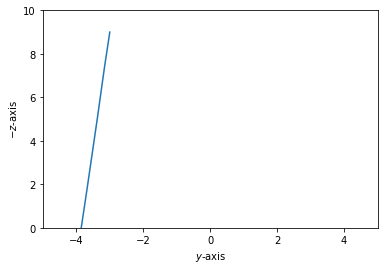

episode: 968/1000, score: -2360.4163235435385  Average over last 100 episode: -2236.14 



episode: 969/1000, score: -1547.7197609261066  Average over last 100 episode: -2234.59 



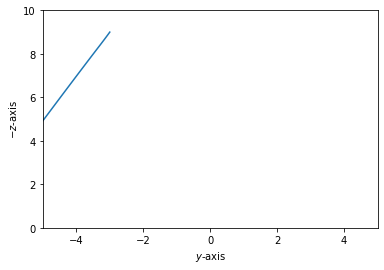

episode: 970/1000, score: -2058.019752328081  Average over last 100 episode: -2231.36 



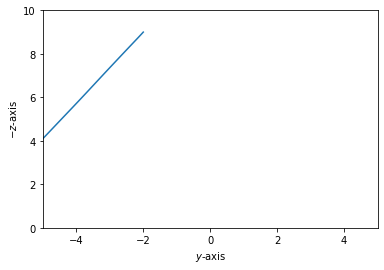

episode: 971/1000, score: -1930.0833466076674  Average over last 100 episode: -2224.77 



episode: 972/1000, score: -2357.030231689168  Average over last 100 episode: -2227.77 



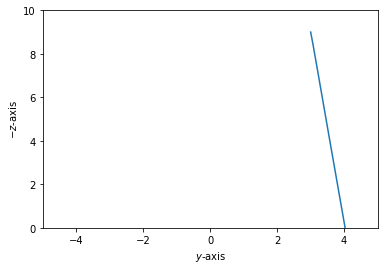

episode: 973/1000, score: -1698.383711125028  Average over last 100 episode: -2219.16 



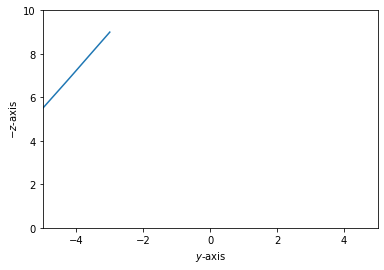

episode: 974/1000, score: -2287.887948228205  Average over last 100 episode: -2221.68 



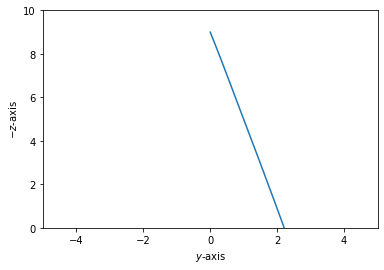

episode: 975/1000, score: -2341.6116746203197  Average over last 100 episode: -2223.39 



episode: 976/1000, score: -3200.948509722906  Average over last 100 episode: -2228.36 



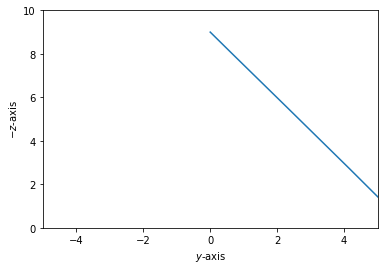

episode: 977/1000, score: -1516.0004879094827  Average over last 100 episode: -2216.49 



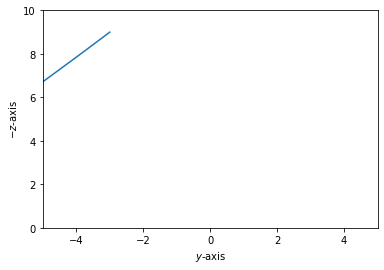

episode: 978/1000, score: -2680.424319435786  Average over last 100 episode: -2214.46 



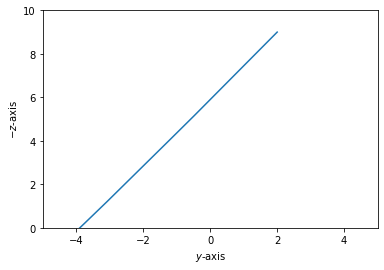

episode: 979/1000, score: -1982.2808472341471  Average over last 100 episode: -2214.31 



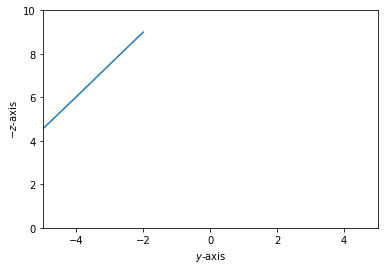

episode: 980/1000, score: -2463.262830635976  Average over last 100 episode: -2219.45 



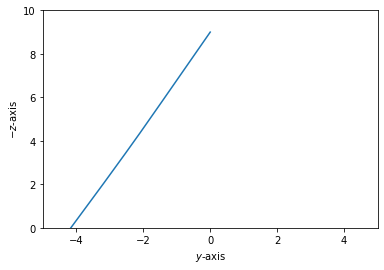

episode: 981/1000, score: -1811.3654284643085  Average over last 100 episode: -2217.68 



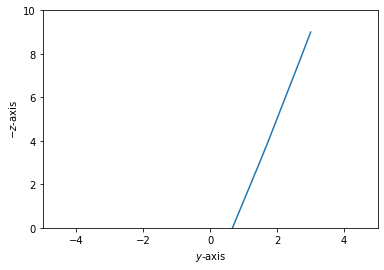

episode: 982/1000, score: -2133.583141605078  Average over last 100 episode: -2219.40 



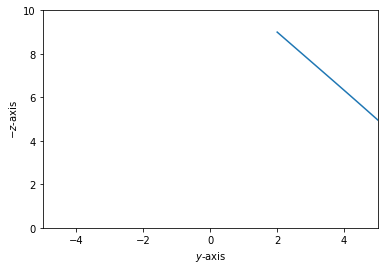

episode: 983/1000, score: -2117.6604594674163  Average over last 100 episode: -2220.10 



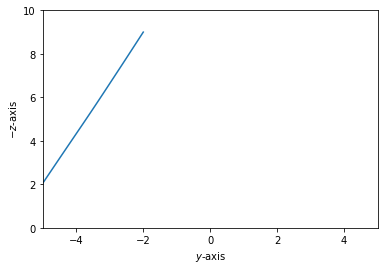

episode: 984/1000, score: -2783.098286035592  Average over last 100 episode: -2230.10 



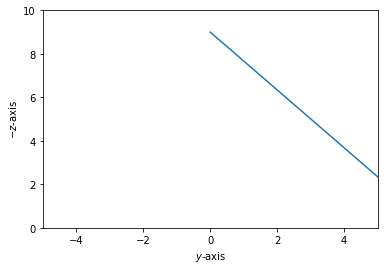

episode: 985/1000, score: -3071.7209073894496  Average over last 100 episode: -2241.57 



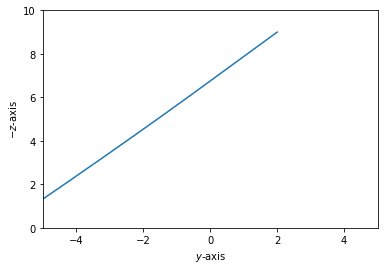

episode: 986/1000, score: -1939.9628090367928  Average over last 100 episode: -2229.52 



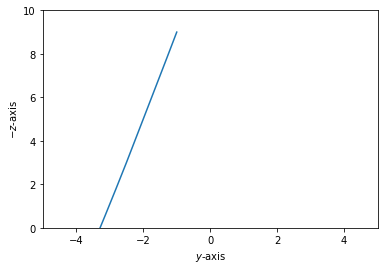

episode: 987/1000, score: -2493.2498158133244  Average over last 100 episode: -2229.10 



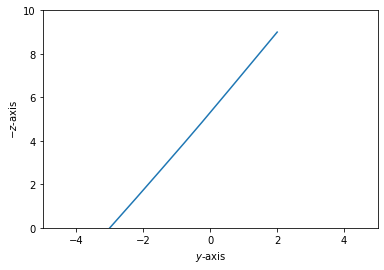

episode: 988/1000, score: -2878.992307536158  Average over last 100 episode: -2230.03 



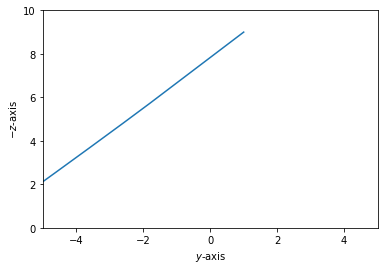

episode: 989/1000, score: -2478.711497838629  Average over last 100 episode: -2237.13 



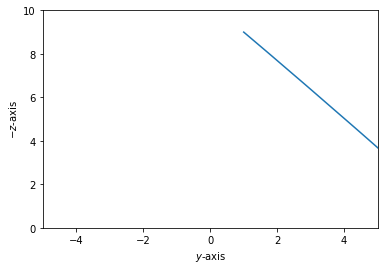

episode: 990/1000, score: -1680.904756322133  Average over last 100 episode: -2233.98 



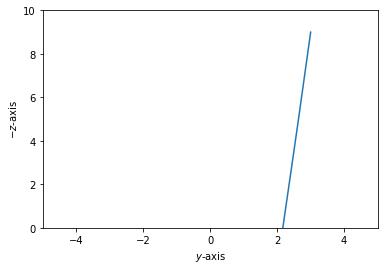

episode: 991/1000, score: -2230.5453457888634  Average over last 100 episode: -2234.35 



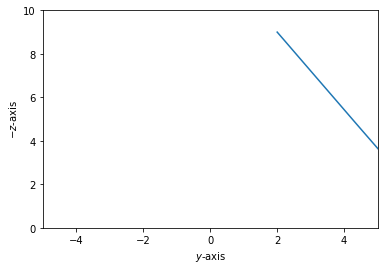

episode: 992/1000, score: -2253.3661435569934  Average over last 100 episode: -2235.02 



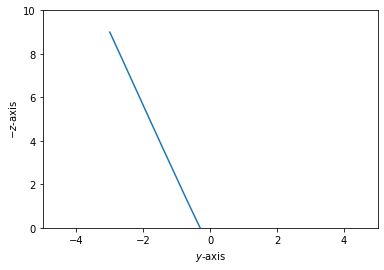

episode: 993/1000, score: -3200.5786187648705  Average over last 100 episode: -2241.46 



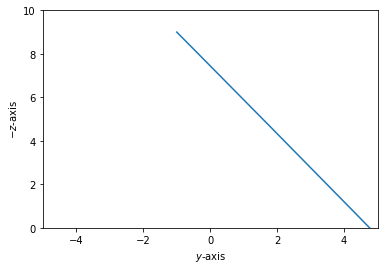

episode: 994/1000, score: -2376.1254400169523  Average over last 100 episode: -2247.18 



episode: 995/1000, score: -2056.486600925713  Average over last 100 episode: -2252.01 



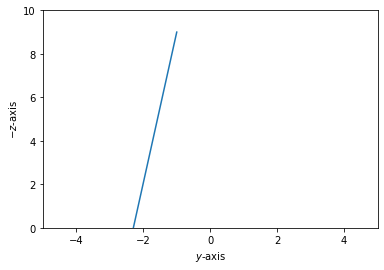

episode: 996/1000, score: -2447.1243654611285  Average over last 100 episode: -2253.92 



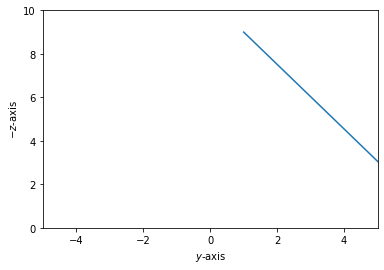

episode: 997/1000, score: -2084.4831127717807  Average over last 100 episode: -2250.83 



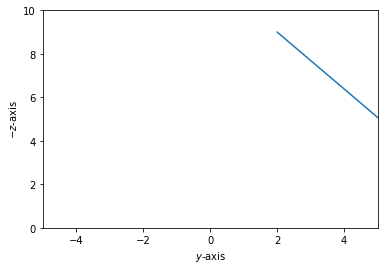

episode: 998/1000, score: -1840.338215881689  Average over last 100 episode: -2251.77 



episode: 999/1000, score: -3256.8985277435577  Average over last 100 episode: -2263.63 



In [6]:
env = LanderEnv()
episodes = 1000
loss = train_dqn(episodes)
plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
plt.show()